# Probabilistic PCA Tutorial
This tutorial will demonstrate Probabilistic PCA, a  factor analysis technique. 

Maths and notation following [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/gp/product/0262018020).

## Installation
Follow the instrallation instructions in the [README](../../README.md) file to get setup.

```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```


## Probabalistic Modeling Introduction

Probabilistic Models can be
categorized into directed graphical models (DGM, Bayes Net) and undirected
graphical models (UGM). Most popular probabilistic models
are DGMs, so MXFusion will only support the definition of
DGMs unless there is a strong customer need of UGMs in future.

A DGM can be fully defined using 3 basic components: deterministic functions,
probabilistic distributions, and random variables. We show the interface for
defining a model using each of the three components below.

First lets import the basic libraries we'll need to train our model and visualize some data.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Generation
We'll take as our function to learn components of the [log spiral function](https://en.wikipedia.org/wiki/Logarithmic_spiral) because it's 2-dimensional and easy to visualize.

In [2]:
def log_spiral(a,b,t):
    x = a * np.exp(b*t) * np.cos(t)
    y = a * np.exp(b*t) * np.sin(t)
    return np.vstack([x,y]).T

We parameterize the function with 100 data points and plot the resulting function.

In [3]:
N = 100
D = 100
K = 2

a = 1
b = 0.1
t = np.linspace(0,6*np.pi,N)
r = log_spiral(a,b,t)

In [4]:
r.shape

(100, 2)

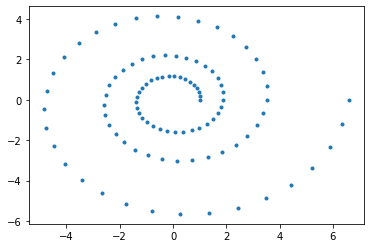

In [5]:
plt.plot(r[:,0], r[:,1],'.')

We now project our $K$ dimensional ```r``` into a high-dimensional $D$ space using a random matrix of random weights $W$. Now that ```r``` is embedded in a $D$ dimensional space the goal of PPCA will be to recover ```r``` in it's original low-dimensional $K$ space.

In [6]:
w = np.random.randn(K,N)
x_train = np.dot(r,w) + np.random.randn(N,N) * 1e-3

In [7]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# new_r = pca.fit_transform(x_train)
# plt.plot(new_r[:,0], new_r[:,1],'.')

You can explore the higher dimensional data manually by changing ```dim1``` and ```dim2``` in the following cell.

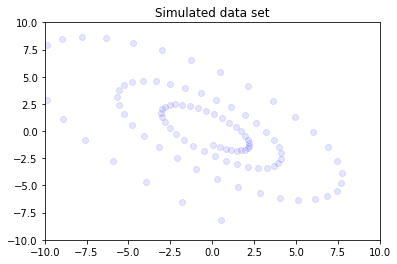

In [8]:
dim1 = 79
dim2 = 11
plt.scatter(x_train[:,dim1], x_train[:,dim2], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

## MXFusion Model Definition
Import MXFusion and MXNet modelling components

In [9]:
from mxfusion.models import Model
import mxnet.gluon.nn as nn
from mxfusion.components import Variable
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.functions.operators import broadcast_to

The primary data structure in MXFusion is the Model. Models hold ModelComponents, such as Variables, Distributions, and Functions which are the what define a probabilistic model. 

The model we'll be defining for PPCA is:

$p(z)$ ~ $N(\mathbf{\mu}, \mathbf{\Sigma)}$

$p(x | z,\theta)$ ~ $N(\mathbf{Wz} + \mu, \Psi)$

where:

$z \in \mathbb{R}^{N x K}, \mathbf{\mu} \in \mathbb{R}^K, \mathbf{\Sigma} \in \mathbb{R}^{NxKxK}, x \in \mathbb{R}^{NxD}$

$\Psi \in \mathbb{R}^{NxDxD}, \Psi = [\Psi_0, \dots, \Psi_N], \Psi_i = \sigma^2\mathbf{I}$

$z$ here is our latent variable of interest, $x$ is the observed data, and all other variables are parameters or constants of the model.

First we create an MXFusion Model object to build our PPCA model on. 

In [10]:
m = Model()

We attach ```Variable``` objects to our model to collect them in a centralized place. Internally, these are organized into a factor graph which is used during Inference. 

In [11]:
m.w = Variable(shape=(K,D), initial_value=mx.nd.array(np.random.randn(K,D)))

Because the mean of $x$'s distribution is composed of the dot product of $z$ and $W$, we need to create a dot product function. First we create a dot product function in MXNet and then wrap the function into MXFusion using the MXFusionGluonFunction class. ```m.dot``` can then be called like a normal python function and will apply to the variables it is called on.

In [12]:
dot = nn.HybridLambda(function='dot')
m.dot = mf.functions.MXFusionGluonFunction(dot, num_outputs=1, broadcastable=False)

Now we define ```m.z``` which has an identity matrix covariance ```cov``` and zero mean.

```m.z``` and ```sigma_2``` are then used to define ```m.x```.

Note that both ```sigma_2``` and ```cov``` will be added implicitly into the ```Model``` because they are inputs to ```m.x```.

In [13]:
cov = mx.nd.broadcast_to(mx.nd.expand_dims(mx.nd.array(np.eye(K,K)), 0),shape=(N,K,K))
m.z = mf.distributions.MultivariateNormal.define_variable(mean=mx.nd.zeros(shape=(N,K)), covariance=cov, shape=(N,K))
m.sigma_2 = Variable(shape=(1,), transformation=PositiveTransformation())
m.x = mf.distributions.Normal.define_variable(mean=m.dot(m.z, m.w), variance=broadcast_to(m.sigma_2, (N,D)), shape=(N,D))

## Posterior Definition

Now that we have our model, we need to define a posterior with parameters for the inference algorithm to optimize. When constructing a Posterior, we pass in the Model it is defined over and ModelComponent's from the original Model are accessible and visible in the Posterior.

The covariance matrix must continue to be positive definite throughout the optimization process in order to succeed in the Cholesky decomposition when drawing samples or computing the log pdf of ```q.z```. To satisfy this, we pass the covariance matrix parameters through a Gluon function that forces it into a Symmetric matrix for which suitable initialization values should maintain positive definite-ness throughout the optimization procedure. 

In [14]:
from mxfusion.inference import BatchInferenceLoop, GradBasedInference, GeneralizedVariationalInference, StochasticVariationalInference, RenyiAlpha, GammaLoss
from mxfusion.inference.gvi import KullbackLeibler, StandardLoss
class SymmetricMatrix(mx.gluon.HybridBlock):
    def hybrid_forward(self, F, x, *args, **kwargs):
        return F.sum((F.expand_dims(x, 3)*F.expand_dims(x, 2)), axis=-3)

While this model has an analytical solution, we will run Variational Inference to find the posterior to demonstrate inference in a setting where the answer is known. 

We place a multivariate normal prior over $z$ because that is $z$'s prior in the model and we don't need to approximate anything in this case. Because the form we're optimizing over is the true model, the optimization is convex and will always converge to the same answer given by classical PCA given enough iterations.


In [15]:
q = mf.models.Posterior(m)
sym = mf.components.functions.MXFusionGluonFunction(SymmetricMatrix(), num_outputs=1, broadcastable=False)
cov = Variable(shape=(N,K,K), initial_value=mx.nd.broadcast_to(mx.nd.expand_dims(mx.nd.array(np.eye(K,K) * 1e-2), 0),shape=(N,K,K)))
q.post_cov = sym(cov)
q.post_mean = Variable(shape=(N,K), initial_value=mx.nd.array(np.random.randn(N,K)))
q.z.set_prior(mf.distributions.MultivariateNormal(mean=q.post_mean, covariance=q.post_cov))

We now take our posterior and model, along with an observation pattern (in our case only ```m.x``` is observed) and create an inference algorithm. This inference algorithm is combined with a gradient loop to create the Inference method ```infr```.

In [16]:
observed = [m.x]
loss_function = GammaLoss(1.01) # this worked :)
#loss_function = StandardLoss() # this worked once :)
divergence = RenyiAlpha(0.5)
# divergence = KullbackLeibler()
num_samples = 30 

alg = GeneralizedVariationalInference(num_samples=num_samples, model=m, posterior=q, observed=observed,
                                      prior_vars=None, likelihood_vars=[m.z, m.x],
                                      divergence=divergence, loss_function=loss_function, data_size=len(x_train))
# alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)

infr = GradBasedInference(inference_algorithm=alg,  grad_loop=BatchInferenceLoop())

The inference method is then initialized with our training data and we run optimiziation for a while until convergence.

In [17]:
pdb

Automatic pdb calling has been turned ON


In [18]:
infr.initialize(x=mx.nd.array(x_train))

In [ ]:
infr.run(max_iter=1000, learning_rate=1e-2, x=mx.nd.array(x_train))

total_likelihood: 
[[ -8741.415   -8619.11    -8688.044  ... -11539.77   -11425.165
  -11705.833 ]
 [ -8745.509   -8617.629   -8686.496  ... -11538.189  -11424.948
  -11704.822 ]
 [ -8744.607   -8619.609   -8681.514  ... -11539.388  -11424.751
  -11704.388 ]
 ...
 [ -8745.557   -8615.264   -8683.648  ... -11541.888  -11425.5625
  -11704.929 ]
 [ -8750.559   -8617.095   -8680.995  ... -11536.093  -11424.926
  -11704.202 ]
 [ -8741.792   -8618.086   -8689.451  ... -11538.938  -11424.389
  -11706.498 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-100158.57  -100161.03  -100166.98  -100201.25  -100158.76  -100174.85
 -100166.445 -100154.29  -100189.016 -100156.48  -100158.68  -100154.72
 -100168.805 -100209.64  -100153.766 -100154.04  -100172.625 -100173.53
 -100191.336 -100182.65  -100175.516 -100158.86  -100155.91  -100184.42
 -100155.6   -100208.83  -100178.41  -100164.81  -100217.73  -100193.17 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[630.4839  644.3456  625.9227  645.6839  637

total_likelihood: 
[[ -8567.494  -8435.097  -8494.15  ... -11265.053 -11169.803 -11453.856]
 [ -8538.124  -8426.284  -8482.592 ... -11225.219 -11170.122 -11453.693]
 [ -8536.804  -8429.211  -8485.734 ... -11224.378 -11168.203 -11448.291]
 ...
 [ -8525.58   -8435.164  -8488.899 ... -11238.389 -11170.694 -11448.3  ]
 [ -8538.246  -8429.241  -8498.875 ... -11222.545 -11170.455 -11453.653]
 [ -8522.286  -8448.228  -8503.027 ... -11215.316 -11171.203 -11450.336]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-96159.016 -95875.25  -96072.47  -96039.35  -96075.99  -96105.89
 -96033.414 -96067.23  -96024.21  -96066.58  -95950.26  -95948.375
 -95950.586 -96144.016 -96086.11  -96016.56  -96174.95  -95979.32
 -95939.66  -96218.41  -95995.836 -96172.92  -95957.54  -96051.37
 -96121.92  -95978.12  -96142.57  -96012.75  -96032.08  -96049.48 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[366.39993 367.76218 383.05936 365.16864 376.83585 355.25974 363.49554
 343.9595  387.1814  374.2075  374.1589  386.

total_likelihood: 
[[ -8363.987  -8252.675  -8326.456 ... -10927.857 -10941.745 -11216.359]
 [ -8340.291  -8275.019  -8322.526 ... -10979.209 -10937.755 -11211.014]
 [ -8339.658  -8260.11   -8306.956 ... -10906.212 -10952.336 -11211.139]
 ...
 [ -8332.931  -8261.066  -8298.897 ... -10945.717 -10939.379 -11206.019]
 [ -8360.741  -8274.952  -8322.437 ... -10979.127 -10932.724 -11205.828]
 [ -8325.213  -8254.238  -8303.213 ... -10972.056 -10944.871 -11206.183]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-92196.2   -92354.78  -91920.05  -92283.69  -92213.64  -92413.86
 -92069.805 -92374.05  -92299.914 -92478.305 -92414.98  -92303.98
 -92278.195 -92373.22  -92243.055 -92321.29  -92418.016 -92331.23
 -92501.19  -92088.78  -92307.12  -92479.    -92482.49  -92242.83
 -92346.44  -92446.84  -92243.67  -92544.36  -92441.29  -92305.17 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[280.40656 288.5738  263.4805  288.6444  269.93082 306.48227 289.24722
 293.50882 264.14832 283.78952 289.049   287.2

total_likelihood: 
[[ -8171.9604  -8111.3213  -8165.583  ... -10646.666  -10725.65
  -10990.778 ]
 [ -8216.777   -8108.921   -8159.9727 ... -10710.309  -10716.152
  -10989.226 ]
 [ -8193.853   -8091.9805  -8160.223  ... -10687.743  -10728.548
  -10988.955 ]
 ...
 [ -8146.962   -8097.098   -8148.6514 ... -10617.1875 -10730.822
  -10984.783 ]
 [ -8176.0225  -8111.2773  -8159.79   ... -10701.788  -10732.537
  -10987.295 ]
 [ -8168.0684  -8107.5244  -8150.549  ... -10724.842  -10725.057
  -10989.048 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-89074.67  -88962.766 -89074.76  -88888.37  -88950.68  -88610.59
 -88772.83  -89027.16  -88891.05  -88913.09  -89007.766 -89157.27
 -89175.54  -89130.46  -88974.87  -88925.62  -88954.875 -89009.57
 -89121.84  -89046.55  -88851.14  -88743.91  -89031.336 -89157.766
 -89012.02  -88578.516 -88905.79  -88865.11  -88954.86  -88987.516]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[240.1328  240.41997 248.41997 234.37604 241.85675 244.89987 227.15974
 231

total_likelihood: 
[[ -8028.083   -7980.7476  -8033.2285 ... -10532.616  -10544.449
  -10792.707 ]
 [ -8047.7188  -7986.557   -8028.5225 ... -10483.08   -10533.791
  -10790.188 ]
 [ -8020.5513  -7971.1694  -8034.001  ... -10474.1455 -10529.701
  -10794.059 ]
 ...
 [ -8034.613   -7982.5938  -8019.8228 ... -10461.77   -10535.646
  -10794.094 ]
 [ -8034.9673  -7969.45    -8051.3623 ... -10497.848  -10537.246
  -10794.225 ]
 [ -8040.3994  -7976.882   -8027.4097 ... -10496.219  -10533.9375
  -10790.018 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-85740.72  -85739.28  -86110.836 -85908.15  -85981.555 -85788.22
 -86034.27  -86259.13  -85948.04  -86014.26  -86013.21  -85524.23
 -85928.01  -85953.33  -86057.56  -85834.15  -86401.32  -86272.41
 -86260.24  -85998.28  -85548.305 -86065.34  -85592.17  -86009.664
 -86112.85  -85901.336 -85965.35  -85814.99  -85919.1   -85657.14 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[192.00471 230.0745  214.30597 202.36592 197.13794 220.92879 205.8658
 21

total_prior_loss: 
[-83999.9   -83429.305 -84044.78  -83953.8   -84197.13  -83819.734
 -83934.59  -83783.21  -83821.375 -83528.12  -83932.82  -83674.77
 -83789.336 -83837.305 -83894.83  -83782.68  -83910.53  -83837.13
 -83699.91  -83757.625 -83658.79  -84092.734 -83766.85  -84020.08
 -83560.22  -83614.47  -83713.85  -83932.53  -84051.695 -83794.67 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[184.81487 192.21725 191.98431 195.24815 188.6321  185.31544 203.13156
 207.00983 190.89098 185.51349 200.62454 197.26086 179.03264 193.83575
 200.92859 193.7367  204.39142 180.65897 206.98016 199.92876 194.3501
 183.92879 209.90164 170.13509 184.16872 190.13121 186.98785 188.23431
 204.50787 194.16096]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-78.219925]
 [-78.2194  ]
 [-78.22209 ]
 [-78.2294  ]
 [-78.25775 ]
 [-78.20936 ]
 [-78.22378 ]
 [-78.22445 ]
 [-78.23418 ]
 [-78.22143 ]
 [-78.22973 ]
 [-78.22868 ]
 [-78.228134]
 [-78.24808 ]
 [-78.2259  ]
 [-78.221695]
 [-78.23092 ]
 [-78.206116]
 [-78.22366 ]


log_p_bar: 
[[-77.5725  ]
 [-77.57238 ]
 [-77.57041 ]
 [-77.57906 ]
 [-77.582664]
 [-77.58103 ]
 [-77.58731 ]
 [-77.63498 ]
 [-77.59809 ]
 [-77.594955]
 [-77.576546]
 [-77.57169 ]
 [-77.5728  ]
 [-77.58176 ]
 [-77.57174 ]
 [-77.57003 ]
 [-77.568596]
 [-77.57469 ]
 [-77.61094 ]
 [-77.57402 ]
 [-77.58565 ]
 [-77.58727 ]
 [-77.59944 ]
 [-77.5761  ]
 [-77.59662 ]
 [-77.59452 ]
 [-77.56803 ]
 [-77.57864 ]
 [-77.589035]
 [-77.582344]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-156.10077 -155.49269 -155.97098 ... -178.80966 -180.25479 -182.74536]
 [-155.9473  -155.57803 -155.98169 ... -179.57286 -180.17581 -182.74081]
 [-156.14752 -155.62376 -155.8689  ... -178.63168 -180.26608 -182.74036]
 ...
 [-155.98917 -155.46103 -155.89319 ... -178.93301 -180.26614 -182.74915]
 [-155.86618 -155.62439 -156.03647 ... -178.3389  -180.25589 -182.76062]
 [-155.79181 -155.40707 -156.04396 ... -178.69977 -180.27109 -182.76675]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[152.28242]
<NDArray 1 @cpu(0)>
log_r_s: 
[-41101.4

total_prior_loss: 
[-79608.13  -79676.92  -79664.586 -79702.59  -79312.07  -79860.04
 -79562.37  -79492.73  -79611.336 -80151.6   -79358.99  -79163.65
 -79308.71  -79547.83  -79651.914 -79211.29  -79142.4   -79680.73
 -79639.83  -79486.984 -79505.74  -79604.81  -79410.086 -79584.125
 -79747.4   -79852.875 -79484.73  -79489.61  -79439.984 -79656.95 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[158.28659 164.57384 164.50508 170.50703 177.69872 153.56232 147.75584
 171.6938  168.65442 158.9705  155.82726 170.98035 159.45302 178.56172
 167.66724 177.4699  169.10388 168.72804 167.00261 159.20772 175.30934
 147.859   166.47966 179.77002 171.6495  148.05087 140.86632 164.0879
 168.19937 160.71812]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-76.56809 ]
 [-76.56515 ]
 [-76.5596  ]
 [-76.58373 ]
 [-76.5711  ]
 [-76.557884]
 [-76.5514  ]
 [-76.55704 ]
 [-76.56798 ]
 [-76.5715  ]
 [-76.55886 ]
 [-76.56765 ]
 [-76.56319 ]
 [-76.57707 ]
 [-76.58261 ]
 [-76.57    ]
 [-76.557724]
 [-76.56632 ]
 [-76.580376]


total_likelihood: 
[[ -7629.812   -7592.296   -7647.752  ...  -9866.768   -9965.143
  -10207.798 ]
 [ -7671.2236  -7617.0215  -7658.579  ...  -9743.419   -9971.466
  -10208.981 ]
 [ -7650.7046  -7584.388   -7637.9023 ...  -9803.009   -9969.922
  -10208.703 ]
 ...
 [ -7640.188   -7607.91    -7629.567  ...  -9844.571   -9991.157
  -10211.771 ]
 [ -7667.948   -7625.0527  -7652.4243 ...  -9779.548   -9991.396
  -10208.453 ]
 [ -7638.5273  -7605.046   -7627.04   ...  -9784.333   -9971.908
  -10207.777 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-77353.89  -77671.305 -77094.38  -77412.23  -77155.72  -77036.13
 -77638.836 -77344.445 -77254.984 -77096.86  -77639.586 -77261.11
 -77271.055 -77514.97  -76957.234 -77532.03  -77426.86  -77590.66
 -77331.42  -77158.45  -77316.414 -77179.08  -77219.66  -77741.555
 -77544.36  -77438.305 -77329.164 -77832.95  -77337.14  -77330.92 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[157.33124 151.91504 169.7711  150.20174 134.45555 148.21095 146.25438
 17

total_likelihood: 
[[ -7543.387   -7492.4043  -7534.4385 ...  -9622.086   -9830.454
  -10054.673 ]
 [ -7520.66    -7513.321   -7533.3555 ...  -9657.09    -9826.133
  -10054.261 ]
 [ -7527.09    -7515.761   -7551.795  ...  -9633.525   -9816.367
  -10052.988 ]
 ...
 [ -7513.024   -7501.334   -7535.8857 ...  -9598.735   -9815.238
  -10053.742 ]
 [ -7529.312   -7497.7607  -7524.516  ...  -9642.615   -9816.194
  -10052.928 ]
 [ -7549.3296  -7513.964   -7540.724  ...  -9683.63    -9824.415
  -10053.158 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-75493.11  -75213.695 -75215.54  -75216.5   -75281.62  -75476.55
 -75338.805 -75246.5   -75260.57  -75618.32  -75167.97  -75453.586
 -75154.67  -75283.08  -75228.82  -75318.04  -75294.31  -75302.39
 -75006.836 -75616.79  -75348.67  -75249.984 -75538.05  -75404.67
 -75337.55  -75129.76  -75502.62  -75130.055 -75406.25  -75438.43 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[147.28275 143.08353 158.43217 150.74344 148.04364 161.4541  145.19157
 14

total_likelihood: 
[[-7494.8228 -7471.1104 -7518.413  ... -9528.725  -9753.309  -9966.408 ]
 [-7491.2026 -7468.697  -7525.164  ... -9536.293  -9742.652  -9965.582 ]
 [-7489.202  -7463.33   -7515.5815 ... -9569.171  -9766.545  -9962.089 ]
 ...
 [-7502.8467 -7492.2935 -7499.8823 ... -9579.178  -9746.939  -9962.806 ]
 [-7494.9526 -7459.514  -7505.088  ... -9515.703  -9739.097  -9963.025 ]
 [-7486.106  -7458.89   -7517.3506 ... -9563.366  -9751.512  -9963.907 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-73278.39  -73475.984 -73146.51  -73258.62  -73408.82  -73466.164
 -73441.98  -73712.56  -73897.36  -73484.336 -73789.586 -73386.51
 -73343.69  -73680.53  -73354.164 -73367.055 -73277.91  -73269.3
 -73409.516 -73551.03  -73371.35  -73788.07  -73807.55  -73649.71
 -73707.99  -73629.12  -73930.836 -73547.66  -73731.7   -73180.74 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[140.0089  128.58665 131.57645 136.81857 158.65633 127.66834 150.29362
 154.7647  151.18219 147.41414 143.55966 150.3

total_likelihood: 
[[-7441.341  -7414.748  -7449.997  ... -9389.077  -9647.56   -9862.691 ]
 [-7451.9937 -7427.178  -7441.371  ... -9417.754  -9640.639  -9860.202 ]
 [-7448.1973 -7417.318  -7444.649  ... -9440.938  -9648.679  -9858.045 ]
 ...
 [-7438.3945 -7414.5054 -7465.9497 ... -9416.043  -9647.673  -9859.146 ]
 [-7434.031  -7406.0757 -7456.2812 ... -9408.66   -9652.204  -9862.271 ]
 [-7458.8096 -7400.605  -7448.9736 ... -9393.653  -9669.644  -9859.978 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-71913.45  -71654.5   -71741.52  -71744.914 -72141.85  -71756.06
 -71729.02  -71885.41  -72000.664 -71636.71  -72062.6   -72086.55
 -71775.53  -71845.914 -71649.06  -71636.61  -71704.83  -71843.24
 -71750.82  -71869.07  -71554.195 -71473.87  -71591.71  -71826.7
 -71387.63  -71808.75  -71594.38  -71587.85  -71742.55  -71693.914]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[151.38902  155.54218  133.58505  148.27237  141.46661  123.32644
 109.41972  134.0776   143.44084  123.852516 133.612

log_p_bar: 
[[-73.35957 ]
 [-73.374985]
 [-73.375435]
 [-73.37627 ]
 [-73.40416 ]
 [-73.385506]
 [-73.35894 ]
 [-73.35963 ]
 [-73.36427 ]
 [-73.36789 ]
 [-73.39273 ]
 [-73.40902 ]
 [-73.368385]
 [-73.390465]
 [-73.37013 ]
 [-73.36164 ]
 [-73.37439 ]
 [-73.38349 ]
 [-73.36791 ]
 [-73.35298 ]
 [-73.37249 ]
 [-73.38056 ]
 [-73.390434]
 [-73.36196 ]
 [-73.376144]
 [-73.37263 ]
 [-73.37126 ]
 [-73.39763 ]
 [-73.3801  ]
 [-73.35167 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-147.26076 -146.9638  -147.16757 ... -166.3523  -169.02686 -170.97461]
 [-147.09332 -146.83463 -147.25586 ... -166.61288 -168.93826 -170.9939 ]
 [-147.04587 -146.89774 -147.27554 ... -166.47018 -169.11815 -170.98236]
 ...
 [-147.2181  -146.86163 -147.29932 ... -166.4052  -169.04884 -171.01447]
 [-147.31549 -146.90656 -147.23254 ... -166.617   -168.9412  -171.03362]
 [-147.20067 -146.83234 -147.31757 ... -166.69815 -169.08078 -170.98227]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[143.64928]
<NDArray 1 @cpu(0)>
log_r_s: 
[-35407.6

log_p_bar: 
[[-72.969   ]
 [-72.98824 ]
 [-72.96737 ]
 [-72.975266]
 [-72.966034]
 [-72.97045 ]
 [-72.9817  ]
 [-72.989044]
 [-72.95278 ]
 [-73.01073 ]
 [-72.95893 ]
 [-72.967064]
 [-72.959625]
 [-72.97622 ]
 [-72.962715]
 [-72.96674 ]
 [-72.96329 ]
 [-72.99019 ]
 [-72.99054 ]
 [-72.97614 ]
 [-72.98989 ]
 [-72.97372 ]
 [-72.96256 ]
 [-72.94822 ]
 [-72.98842 ]
 [-72.98918 ]
 [-72.954155]
 [-72.96304 ]
 [-72.99331 ]
 [-72.96103 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-146.46042 -146.04332 -146.3914  ... -165.02818 -167.63315 -169.67871]
 [-146.323   -145.98611 -146.434   ... -165.19434 -167.6814  -169.7141 ]
 [-146.2752  -146.03824 -146.50864 ... -165.29155 -167.78725 -169.71846]
 ...
 [-146.37064 -146.19345 -146.53708 ... -165.04858 -167.67827 -169.68452]
 [-146.3884  -146.08377 -146.48914 ... -165.45438 -167.64713 -169.71048]
 [-146.26881 -146.24487 -146.50272 ... -165.07726 -167.5452  -169.71991]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[142.82674]
<NDArray 1 @cpu(0)>
log_r_s: 
[-34520.7

D_tilde: 
[-33564.09]
<NDArray 1 @cpu(0)>
D_bar: 
[67128.18]
<NDArray 1 @cpu(0)>
logL: 
[67270.06]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-7329.053  -7308.4907 -7350.987  ... -9154.741  -9423.376  -9621.86  ]
 [-7311.4985 -7312.919  -7338.765  ... -9152.961  -9420.098  -9621.881 ]
 [-7331.091  -7302.596  -7342.965  ... -9159.391  -9433.728  -9620.318 ]
 ...
 [-7326.4165 -7303.9604 -7343.597  ... -9171.417  -9407.617  -9628.798 ]
 [-7333.156  -7312.382  -7350.5645 ... -9165.469  -9428.448  -9621.0205]
 [-7325.5137 -7310.219  -7360.994  ... -9153.041  -9431.769  -9624.652 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-67303.74  -67343.48  -67366.31  -67340.18  -67389.64  -67102.16
 -66923.78  -67463.22  -67401.44  -67177.625 -67528.74  -67442.11
 -67209.79  -67614.85  -67069.09  -67779.59  -67221.82  -67510.14
 -67636.8   -67002.09  -67203.94  -67227.016 -67029.46  -67174.56
 -67361.19  -67826.59  -67010.875 -67209.83  -67434.07  -67052.39 ]
<NDArray 30 @cpu(0)>
total_posterior_loss:

logL_l_i_s: 
[[-145.4139  -145.23506 -145.70172 ... -163.4215  -166.22107 -168.14426]
 [-145.45044 -145.39743 -145.70255 ... -163.60788 -166.42503 -168.06424]
 [-145.54056 -145.27144 -145.59016 ... -163.43257 -166.21777 -168.11624]
 ...
 [-145.61429 -145.27594 -145.76205 ... -163.505   -166.21793 -168.04549]
 [-145.44128 -145.2558  -145.70964 ... -163.40448 -166.45175 -168.20625]
 [-145.84543 -145.36443 -145.68782 ... -163.54536 -166.17056 -168.12054]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[142.0343]
<NDArray 1 @cpu(0)>
log_r_s: 
[-32953.79  -33058.945 -33050.47  -33109.664 -33136.88  -32895.48
 -33100.848 -33059.17  -33220.82  -33025.918 -33182.48  -33020.176
 -33070.    -33261.215 -33257.465 -33222.703 -33355.46  -33039.414
 -33004.184 -33003.484 -33063.332 -33065.67  -33180.195 -33058.59
 -33135.086 -33130.28  -33207.754 -33252.137 -33124.92  -33172.29 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-32898.883]
<NDArray 1 @cpu(0)>
D_bar: 
[65797.766]
<NDArray 1 @cpu(0)>
logL: 
[65939.8]
<NDArray 1 

total_likelihood: 
[[-7295.1846 -7265.2124 -7305.8135 ... -9030.057  -9318.875  -9505.95  ]
 [-7294.111  -7263.995  -7316.097  ... -9034.436  -9320.268  -9492.65  ]
 [-7284.0913 -7264.0005 -7297.1445 ... -9030.809  -9331.459  -9502.293 ]
 ...
 [-7287.1504 -7269.1685 -7309.993  ... -9031.223  -9331.448  -9500.192 ]
 [-7280.4775 -7266.45   -7297.1177 ... -9038.726  -9332.56   -9499.144 ]
 [-7294.1636 -7267.414  -7316.2144 ... -9029.912  -9328.338  -9500.011 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-64395.992 -64271.36  -64460.875 -64195.348 -65094.36  -64221.406
 -64722.945 -64769.38  -64608.645 -64927.984 -64587.473 -64811.85
 -64429.918 -64707.508 -64761.89  -64433.227 -64492.168 -64731.95
 -64471.902 -64658.227 -64664.145 -64640.66  -64114.41  -64454.156
 -64593.598 -64812.566 -64716.    -64253.438 -65072.562 -64861.797]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[130.40427  121.53136  112.26796  105.05303  104.34853  102.047165
 123.1407   107.32209  113.30883  121.11083  102

total_likelihood: 
[[-7263.2617 -7258.1284 -7302.7705 ... -8979.307  -9248.919  -9432.147 ]
 [-7292.842  -7253.947  -7296.214  ... -8962.77   -9251.593  -9428.055 ]
 [-7295.678  -7269.961  -7298.6587 ... -8972.032  -9270.375  -9429.396 ]
 ...
 [-7288.9473 -7250.695  -7288.0537 ... -8964.084  -9262.441  -9430.389 ]
 [-7300.4624 -7252.4453 -7295.705  ... -8961.605  -9276.373  -9429.326 ]
 [-7267.045  -7248.5264 -7309.3574 ... -8963.158  -9263.118  -9432.697 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-62809.207 -62773.523 -62798.133 -62818.418 -63008.27  -62732.887
 -63069.55  -62660.754 -62818.92  -62522.04  -62691.535 -62595.645
 -62520.63  -62350.906 -62971.145 -62724.133 -62578.98  -62489.41
 -62462.31  -62446.934 -62987.418 -62699.31  -62882.316 -62476.598
 -62702.844 -62831.887 -62848.043 -62409.523 -62892.03  -62862.566]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[111.4966   108.57541  106.62111  119.40492  104.969185 112.541626
 104.688126 113.442345 113.67559  106.94804  11

D_tilde: 
[-30646.578]
<NDArray 1 @cpu(0)>
D_bar: 
[61293.156]
<NDArray 1 @cpu(0)>
logL: 
[61435.715]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-7313.1123 -7271.439  -7327.9277 ... -8943.963  -9247.754  -9405.76  ]
 [-7312.0566 -7270.6143 -7341.883  ... -8951.039  -9254.231  -9403.24  ]
 [-7312.3125 -7275.901  -7314.4336 ... -8945.288  -9246.05   -9399.696 ]
 ...
 [-7308.164  -7278.4365 -7323.6694 ... -8936.027  -9290.015  -9416.755 ]
 [-7315.2676 -7277.4526 -7341.994  ... -8938.368  -9242.029  -9410.461 ]
 [-7311.479  -7282.812  -7341.7456 ... -8953.176  -9224.588  -9409.099 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-61168.117 -61535.574 -61748.44  -61474.074 -61098.566 -61137.75
 -60777.016 -60823.74  -61071.58  -61365.71  -61434.945 -61462.17
 -61184.855 -60751.355 -61664.41  -61235.85  -61118.805 -61128.11
 -61187.516 -61355.812 -61085.652 -61940.293 -61298.414 -60996.13
 -61760.75  -61038.547 -61301.215 -61241.117 -61064.824 -61179.16 ]
<NDArray 30 @cpu(0)>
total_posterior_lo

total_likelihood: 
[[-7331.1445 -7317.755  -7376.3823 ... -8945.663  -9271.748  -9395.902 ]
 [-7353.676  -7312.929  -7361.346  ... -8935.413  -9247.738  -9392.751 ]
 [-7351.158  -7317.1465 -7358.1284 ... -8924.107  -9253.359  -9391.261 ]
 ...
 [-7347.456  -7329.1147 -7397.3657 ... -8939.451  -9313.17   -9417.858 ]
 [-7340.422  -7312.7666 -7372.0347 ... -8956.004  -9269.984  -9384.684 ]
 [-7343.3022 -7313.821  -7375.2544 ... -8936.466  -9269.145  -9408.347 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-60488.645 -59656.3   -59523.832 -59713.83  -59956.156 -59963.543
 -59757.074 -60260.37  -59581.715 -59688.84  -60100.203 -59808.867
 -60122.906 -59807.07  -59723.75  -59202.78  -59564.535 -60156.945
 -60021.145 -59938.52  -59611.76  -59605.33  -60354.777 -59341.2
 -59827.55  -59661.754 -59790.258 -59731.652 -60122.06  -60106.547]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 96.11654   97.72814   99.826775 108.17803   87.50882  102.49418
  94.36117  101.4881    97.712036 119.63711   95.

logL_bar: 
[143.76895]
<NDArray 1 @cpu(0)>
log_r_s: 
[-29476.979 -29349.424 -29320.986 -29580.44  -29767.738 -29187.014
 -29424.188 -29209.455 -29556.135 -29348.904 -29446.5   -29588.69
 -29460.885 -29629.545 -29462.045 -29209.918 -29428.338 -29426.621
 -29716.994 -29721.482 -29449.375 -29422.582 -29551.75  -29542.854
 -29318.912 -29077.297 -29368.846 -29238.791 -29693.328 -29721.676]
<NDArray 30 @cpu(0)>
D_tilde: 
[-29080.697]
<NDArray 1 @cpu(0)>
D_bar: 
[58161.395]
<NDArray 1 @cpu(0)>
logL: 
[58305.164]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-7398.007  -7367.473  -7423.6895 ... -8959.509  -9287.621  -9388.633 ]
 [-7404.293  -7361.6665 -7425.7383 ... -8950.868  -9266.375  -9397.417 ]
 [-7385.979  -7360.9775 -7411.4453 ... -8943.198  -9292.6    -9395.314 ]
 ...
 [-7386.5024 -7364.779  -7421.246  ... -8948.881  -9259.081  -9409.516 ]
 [-7408.0825 -7359.572  -7424.0337 ... -8927.961  -9296.637  -9388.953 ]
 [-7414.0527 -7358.191  -7424.012  ... -8950.386  -9236.569  -9385.501 ]]
<NDArr

total_likelihood: 
[[-7466.596  -7432.56   -7497.0854 ... -8949.793  -9296.457  -9436.359 ]
 [-7459.591  -7435.4995 -7492.7983 ... -8997.889  -9294.618  -9410.951 ]
 [-7481.5903 -7433.874  -7517.918  ... -8959.381  -9304.428  -9427.949 ]
 ...
 [-7472.859  -7430.3813 -7517.7993 ... -8965.646  -9300.936  -9408.717 ]
 [-7468.738  -7433.5557 -7486.507  ... -8956.254  -9344.57   -9417.695 ]
 [-7461.565  -7431.9106 -7498.253  ... -8956.29   -9288.373  -9417.252 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-56496.94  -56697.22  -56754.4   -56232.797 -56246.004 -57031.91
 -56403.68  -56431.344 -56757.953 -56009.67  -56518.293 -56836.09
 -57222.656 -56767.156 -56633.418 -56530.934 -57452.17  -56148.902
 -56773.254 -56635.754 -56372.766 -56042.004 -56625.08  -57165.7
 -56209.305 -56115.582 -56539.766 -57430.816 -56151.516 -56567.613]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[106.90492  105.58498   97.12605   96.48182  124.66146  103.23423
 101.9559    85.748764 103.40816  100.7859   105.85

total_prior_loss: 
[-55058.797 -54714.934 -55169.754 -54914.83  -55148.09  -54811.715
 -54839.707 -54710.055 -54888.82  -54650.574 -55243.27  -54688.223
 -55237.64  -55320.434 -55493.96  -54807.    -56000.984 -54970.656
 -55536.824 -55325.984 -55145.95  -54894.355 -55212.57  -55286.28
 -55563.61  -55002.812 -55396.83  -55340.28  -54461.844 -54296.637]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 94.61182   92.335655 108.77288  118.27922   95.75863   94.32921
 103.22502   99.28534  104.63931  123.29692  109.44976   97.52877
  95.06553  102.26078   90.1773    96.652275  92.022896  97.79744
  87.6139   106.0018   104.60438   98.623146 111.08547   91.80489
 107.11454   93.331024  82.363625  80.64189  114.5307    78.173775]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-74.70816 ]
 [-74.72157 ]
 [-74.726135]
 [-74.7321  ]
 [-74.72523 ]
 [-74.70782 ]
 [-74.70968 ]
 [-74.704956]
 [-74.70223 ]
 [-74.71328 ]
 [-74.72589 ]
 [-74.71112 ]
 [-74.7166  ]
 [-74.73017 ]
 [-74.70692 ]
 [-74.7221  ]
 [-74.74082 ]

logL_l_i_s: 
[[-151.89378 -151.51263 -152.12051 ... -166.20255 -169.62408 -170.31192]
 [-151.91008 -151.47592 -152.42581 ... -166.1987  -169.69003 -170.12979]
 [-151.97617 -151.51517 -152.21931 ... -166.00157 -169.13956 -170.21869]
 ...
 [-151.93777 -151.56491 -152.39334 ... -165.79294 -169.14465 -170.19   ]
 [-152.04312 -151.49203 -152.03937 ... -166.39967 -169.08784 -170.10522]
 [-151.79129 -151.48355 -152.33514 ... -166.43767 -169.42178 -170.40327]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[148.13797]
<NDArray 1 @cpu(0)>
log_r_s: 
[-26994.79  -26998.703 -27065.943 -26730.17  -26640.252 -27093.68
 -26847.76  -26529.758 -27126.527 -26801.889 -26601.812 -27030.158
 -26973.562 -26979.215 -26712.047 -27037.955 -27315.84  -26684.705
 -26927.31  -26835.29  -27281.336 -26754.818 -26705.49  -27000.043
 -26895.549 -26756.361 -26849.348 -26667.578 -27257.742 -27045.55 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-26533.158]
<NDArray 1 @cpu(0)>
D_bar: 
[53066.316]
<NDArray 1 @cpu(0)>
logL: 
[53214.453]
<NDArra

total_likelihood: 
[[-7737.4326 -7688.241  -7784.4385 ... -9104.65   -9415.118  -9496.753 ]
 [-7752.913  -7700.2676 -7758.7065 ... -9100.243  -9475.425  -9542.592 ]
 [-7720.214  -7691.109  -7747.252  ... -9114.282  -9400.762  -9469.305 ]
 ...
 [-7729.9995 -7689.6797 -7761.7173 ... -9103.004  -9476.209  -9496.225 ]
 [-7719.9146 -7689.864  -7777.537  ... -9099.555  -9445.875  -9482.39  ]
 [-7709.2915 -7688.4565 -7799.303  ... -9068.076  -9434.295  -9546.246 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-51991.957 -52784.695 -51352.723 -51707.26  -51474.133 -51820.63
 -51976.48  -51567.19  -52122.125 -51927.246 -52449.918 -51856.35
 -52164.48  -52040.375 -51585.945 -51861.56  -51577.625 -51430.4
 -51928.043 -52195.945 -51912.11  -51225.77  -51761.805 -52297.26
 -52231.797 -51584.375 -51546.402 -51803.95  -52371.074 -52284.848]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 76.62015   93.00765   99.36798  103.07377   93.27372   89.31585
  89.04552   95.73256   88.5041   104.97478   92.630

total_likelihood: 
[[-7806.8774 -7771.395  -7819.124  ... -9139.113  -9452.469  -9507.713 ]
 [-7798.155  -7769.3184 -7820.856  ... -9160.128  -9450.372  -9513.498 ]
 [-7799.109  -7770.436  -7810.8345 ... -9110.547  -9466.589  -9487.964 ]
 ...
 [-7808.558  -7768.517  -7818.4404 ... -9085.473  -9472.381  -9459.994 ]
 [-7792.356  -7773.625  -7865.9023 ... -9156.155  -9479.716  -9492.007 ]
 [-7818.6694 -7771.2314 -7848.5107 ... -9111.027  -9422.435  -9519.696 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-50025.367 -49686.566 -50673.656 -49772.586 -49129.633 -48641.543
 -49336.707 -49503.855 -49400.395 -49969.773 -49998.5   -48980.49
 -49715.332 -49753.46  -49841.293 -49500.176 -49375.4   -49755.793
 -50322.59  -49430.707 -49266.656 -50496.45  -49727.836 -49563.652
 -50405.89  -49242.418 -49969.008 -48631.637 -49776.625 -49894.844]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 99.01637   99.97268   92.67045  102.03908  108.80159  107.8348
  98.62468  101.94568  111.116425  58.952988  88.

total_likelihood: 
[[-7986.551  -7934.6357 -8018.321  ... -9205.374  -9573.725  -9583.1   ]
 [-7968.6187 -7932.871  -8028.7905 ... -9219.     -9599.081  -9576.144 ]
 [-7983.0576 -7934.9688 -8003.802  ... -9249.889  -9558.815  -9564.68  ]
 ...
 [-7989.802  -7936.5933 -8036.2227 ... -9257.822  -9643.899  -9562.538 ]
 [-7979.362  -7933.136  -8024.573  ... -9253.207  -9487.36   -9555.593 ]
 [-7967.4653 -7935.446  -8009.2065 ... -9189.473  -9575.16   -9646.085 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-48206.55  -48456.746 -47944.56  -48312.6   -47628.543 -48573.484
 -46694.41  -48375.434 -47929.266 -48391.992 -47562.203 -47180.195
 -46940.348 -47800.312 -47695.16  -46952.816 -47467.336 -47362.75
 -47228.094 -48186.93  -47560.312 -48101.637 -47990.074 -46450.6
 -48304.7   -47553.418 -47591.51  -47214.035 -48127.273 -49139.875]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 90.18495   86.6553    83.40249   89.88855  108.27634   85.32887
  98.994774  87.48413  102.72      97.555176  89.0

total_prior_loss: 
[-45588.832 -45140.11  -46218.67  -46020.41  -45133.113 -45693.92
 -46898.977 -45540.094 -45161.445 -45716.305 -46625.035 -45922.773
 -45907.37  -46056.504 -46722.137 -47296.508 -45321.465 -45218.516
 -45370.75  -44737.37  -45429.387 -45063.242 -45596.65  -46519.45
 -45275.76  -46231.676 -44959.89  -45421.66  -45652.664 -45211.23 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 89.54423   83.32514   80.21431   89.14819   86.18249   95.058624
  89.97667   90.97858   83.02185   82.91755   66.095245  86.78279
  90.60393   88.05275   88.48682   92.5982   104.588135  73.622154
  69.90794   76.63589   95.10468  105.43911   94.80278   77.03835
  87.980484  86.1722    83.724884  89.35484   81.3459    96.2229  ]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-80.26545 ]
 [-80.26799 ]
 [-80.272285]
 [-80.26116 ]
 [-80.2638  ]
 [-80.26447 ]
 [-80.26996 ]
 [-80.274185]
 [-80.26439 ]
 [-80.27473 ]
 [-80.279175]
 [-80.267746]
 [-80.27681 ]
 [-80.26482 ]
 [-80.2642  ]
 [-80.262184]
 [-80.264   

total_likelihood: 
[[-8183.215  -8144.5137 -8203.214  ... -9327.209  -9753.635  -9672.499 ]
 [-8176.338  -8147.196  -8254.109  ... -9324.188  -9639.847  -9747.753 ]
 [-8199.359  -8144.551  -8186.961  ... -9332.394  -9737.999  -9683.039 ]
 ...
 [-8187.003  -8144.5137 -8238.959  ... -9358.424  -9726.044  -9644.563 ]
 [-8180.7754 -8144.666  -8219.422  ... -9319.927  -9629.486  -9669.311 ]
 [-8179.6562 -8145.178  -8195.047  ... -9394.186  -9708.4    -9608.436 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-45600.97  -45540.816 -44643.848 -44915.875 -44875.98  -44693.402
 -43958.23  -44597.72  -44399.74  -45055.184 -43699.727 -45583.285
 -44791.887 -44334.777 -45581.44  -43847.35  -44177.01  -44664.57
 -44765.76  -44278.3   -44660.812 -44209.37  -43701.188 -45209.133
 -44422.47  -44686.418 -43534.81  -44157.914 -46849.51  -44153.46 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 75.99535   81.98639  104.46862   80.874374  90.26834   86.47192
 101.67499   96.573135 106.646866  91.68095   91

total_prior_loss: 
[-44291.77  -42285.527 -43281.57  -42573.06  -44226.39  -43664.688
 -43295.68  -42846.074 -43548.527 -43266.875 -45276.93  -42649.816
 -43202.13  -43011.49  -43045.64  -44292.734 -43112.207 -43119.453
 -42204.7   -42354.64  -43245.234 -43100.67  -42818.004 -43949.117
 -44266.945 -43938.21  -43867.535 -43536.438 -42977.87  -43522.344]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 74.07598   83.91114   89.907524  78.578316  93.53007   83.29836
  97.98703   87.345985  97.91173  102.40993   88.59658   91.0658
  63.15181   86.709755  89.0237    67.42305   80.556175  87.74827
 100.833115  94.508644  89.66134   82.82643   75.5762    76.751144
  91.577576  87.12217   86.7599    88.819824  82.54756   80.9559  ]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-82.76891 ]
 [-82.781   ]
 [-82.77229 ]
 [-82.77341 ]
 [-82.77088 ]
 [-82.76312 ]
 [-82.763466]
 [-82.767555]
 [-82.76273 ]
 [-82.76368 ]
 [-82.76685 ]
 [-82.759125]
 [-82.779526]
 [-82.7588  ]
 [-82.766365]
 [-82.764114]
 [-82.7588  

total_likelihood: 
[[-8439.993  -8408.986  -8484.192  ... -9493.264  -9939.91   -9919.715 ]
 [-8456.2    -8411.606  -8531.502  ... -9547.081  -9933.252  -9855.864 ]
 [-8451.691  -8412.958  -8511.682  ... -9529.407  -9779.545  -9966.912 ]
 ...
 [-8445.997  -8412.114  -8454.027  ... -9477.532  -9801.751  -9843.358 ]
 [-8465.385  -8409.231  -8448.261  ... -9622.605  -9752.465  -9769.765 ]
 [-8441.316  -8408.757  -8506.434  ... -9596.6875 -9861.906  -9763.05  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-41515.984 -41760.89  -42124.465 -41544.656 -39849.52  -41844.023
 -40833.688 -40485.29  -42302.58  -40692.434 -41457.39  -41640.766
 -42098.516 -41463.86  -41745.29  -41130.46  -40941.645 -42211.35
 -41651.207 -41803.617 -40647.145 -42711.363 -40812.82  -41862.973
 -40375.863 -42208.652 -43199.71  -41407.754 -41927.195 -41109.04 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 97.487564  93.445694  91.68335   94.02314   94.13189   79.328186
 104.54204  101.725235  80.730995 107.34619   6

D_tilde: 
[-19372.223]
<NDArray 1 @cpu(0)>
D_bar: 
[38744.445]
<NDArray 1 @cpu(0)>
logL: 
[38911.227]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-8576.723 -8544.903 -8614.067 ... -9665.802 -9948.759 -9897.251]
 [-8581.026 -8542.583 -8638.349 ... -9600.534 -9915.588 -9794.456]
 [-8589.568 -8542.387 -8587.829 ... -9556.279 -9963.988 -9812.802]
 ...
 [-8564.149 -8542.573 -8602.007 ... -9651.522 -9913.139 -9829.308]
 [-8591.407 -8543.283 -8637.705 ... -9627.531 -9953.396 -9842.704]
 [-8584.701 -8545.23  -8604.266 ... -9697.047 -9832.229 -9979.505]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-39090.75  -40256.957 -39584.992 -39987.977 -40113.53  -39962.992
 -39185.082 -39238.137 -41119.04  -40401.457 -39196.676 -42130.984
 -39194.492 -38583.555 -40937.992 -39617.414 -39985.074 -40340.438
 -38870.742 -40341.45  -41114.793 -39729.92  -40362.996 -38860.36
 -40473.344 -39933.85  -39812.133 -39332.516 -39422.766 -39576.03 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[102.80033   79.34969   89.1

total_prior_loss: 
[-38669.457 -38989.2   -38368.516 -39432.14  -38710.375 -38262.32
 -38438.047 -39127.953 -40103.906 -38521.54  -38640.246 -40085.65
 -37960.523 -38791.332 -39017.945 -38833.21  -39543.84  -38266.957
 -38912.062 -38581.016 -39005.094 -40805.047 -38918.59  -39632.027
 -39017.625 -38321.84  -38925.418 -39514.26  -39795.414 -39745.418]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 89.05337   82.56111   89.054955 103.57669   97.39873   93.648834
  90.32426   95.12239   85.03353   74.400314  95.66116   86.77431
  89.639206  84.9721    91.469406  65.015785 101.713295  84.15174
  85.652664  83.96054   73.04208   83.91945   95.25046  107.402145
  92.6292    88.995735  95.98837   80.05019   79.309     95.9416  ]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-86.6382  ]
 [-86.63978 ]
 [-86.63155 ]
 [-86.634605]
 [-86.64513 ]
 [-86.631386]
 [-86.640755]
 [-86.64323 ]
 [-86.63265 ]
 [-86.6483  ]
 [-86.64263 ]
 [-86.638054]
 [-86.63461 ]
 [-86.65176 ]
 [-86.634346]
 [-86.64528 ]
 [-86.639984

D_tilde: 
[-18210.527]
<NDArray 1 @cpu(0)>
D_bar: 
[36421.055]
<NDArray 1 @cpu(0)>
logL: 
[36592.855]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[ -8885.532  -8825.825  -8908.294 ...  -9790.418 -10247.25  -10088.846]
 [ -8877.372  -8827.749  -8896.109 ...  -9716.577 -10090.881 -10025.988]
 [ -8858.049  -8826.614  -8932.595 ...  -9876.855 -10048.638 -10013.281]
 ...
 [ -8868.165  -8825.657  -8891.865 ...  -9884.691 -10251.809  -9953.624]
 [ -8856.244  -8825.558  -8971.166 ...  -9891.656 -10184.065 -10071.43 ]
 [ -8865.107  -8825.858  -8886.657 ...  -9881.802 -10182.326 -10081.006]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-36376.812 -36500.96  -36854.258 -36884.953 -37158.707 -38043.812
 -37986.883 -37245.76  -38273.035 -36989.785 -36923.84  -37787.7
 -37539.387 -37201.105 -37428.85  -35816.797 -38041.273 -37276.08
 -37739.35  -37985.477 -37208.17  -37030.617 -36950.78  -36073.48
 -37112.84  -37144.42  -36647.246 -37008.785 -38018.152 -37419.082]
<NDArray 30 @cpu(0)>
total_posterior_lo

logL_bar: 
[174.15096]
<NDArray 1 @cpu(0)>
log_r_s: 
[-18667.973 -17818.393 -18132.54  -17559.535 -18254.49  -19182.68
 -17961.277 -17548.676 -17818.24  -18101.2   -18025.691 -18213.39
 -17846.553 -17896.469 -17933.533 -18945.566 -18965.21  -18823.03
 -18310.646 -18368.863 -18305.477 -18232.168 -18843.463 -18230.793
 -18024.059 -17921.484 -18223.44  -17669.996 -18102.148 -18336.898]
<NDArray 30 @cpu(0)>
D_tilde: 
[-17552.076]
<NDArray 1 @cpu(0)>
D_bar: 
[35104.152]
<NDArray 1 @cpu(0)>
logL: 
[35278.305]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[ -8950.36   -8924.39   -8965.192 ...  -9901.312 -10356.941 -10018.128]
 [ -8939.815  -8924.472  -9003.744 ...  -9827.256  -9980.584 -10144.949]
 [ -8947.523  -8925.349  -8970.24  ...  -9838.252 -10159.418 -10007.305]
 ...
 [ -8938.376  -8925.746  -9005.395 ...  -9846.945 -10249.635 -10113.205]
 [ -8943.658  -8925.479  -8987.306 ...  -9769.926 -10199.629 -10067.825]
 [ -8950.815  -8927.341  -8964.53  ...  -9870.498 -10342.897 -10015.957]]
<NDArray

total_likelihood: 
[[ -9112.831   -9082.505   -9156.54   ...  -9873.212  -10296.381
  -10176.2705]
 [ -9132.367   -9081.322   -9155.32   ...  -9843.463  -10311.675
  -10121.873 ]
 [ -9127.763   -9083.581   -9152.158  ... -10032.31   -10150.357
  -10218.525 ]
 ...
 [ -9089.54    -9082.088   -9173.886  ...  -9931.165  -10381.097
  -10096.097 ]
 [ -9105.583   -9082.16    -9115.993  ... -10025.21   -10145.455
  -10107.349 ]
 [ -9120.613   -9081.766   -9174.032  ...  -9939.694  -10233.021
  -10151.338 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-34396.7   -33101.06  -34660.387 -34509.19  -34366.195 -34511.242
 -36980.387 -34588.406 -33680.582 -34514.49  -34807.04  -35420.348
 -34087.24  -33665.273 -34665.914 -33705.83  -36484.67  -34509.516
 -36802.44  -37938.37  -34028.336 -34984.3   -34550.734 -33376.43
 -37060.33  -33896.9   -33639.387 -33246.715 -33161.273 -34648.14 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[111.85025  114.198456  97.45371  115.65928  108.50594  126.300964
  92.

total_likelihood: 
[[ -9272.099   -9233.891   -9289.6455 ... -10062.529  -10186.688
  -10288.517 ]
 [ -9249.369   -9233.218   -9292.872  ... -10002.539  -10580.457
  -10236.955 ]
 [ -9276.683   -9233.376   -9293.358  ... -10072.903  -10609.18
  -10158.634 ]
 ...
 [ -9252.861   -9233.504   -9280.857  ... -10100.334  -10168.257
  -10406.74  ]
 [ -9286.612   -9235.303   -9311.4375 ... -10092.547  -10428.542
  -10225.938 ]
 [ -9304.742   -9233.316   -9320.001  ... -10092.074  -10187.191
  -10245.889 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-35405.74  -33727.637 -33028.465 -33221.727 -32750.064 -35049.46
 -32064.102 -32966.9   -33563.812 -33243.1   -32976.83  -33846.598
 -33297.89  -34114.566 -32948.402 -32351.654 -33059.098 -33607.105
 -34195.914 -33766.39  -31989.945 -33147.984 -35922.715 -33544.47
 -32049.809 -32601.537 -33390.938 -32485.271 -34896.734 -36468.367]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[103.48318   92.3638   109.61222  104.58136  100.45009  108.87185
 101.553

total_likelihood: 
[[ -9260.121  -9235.898  -9279.89  ...  -9995.15  -10304.959 -10158.699]
 [ -9246.428  -9237.28   -9276.633 ...  -9991.764 -10232.676 -10209.285]
 [ -9252.475  -9235.163  -9295.64  ... -10042.082 -10464.459 -10193.433]
 ...
 [ -9247.852  -9236.06   -9277.736 ... -10090.635 -10564.18  -10184.275]
 [ -9247.366  -9234.802  -9271.398 ...  -9986.191 -10170.49  -10212.088]
 [ -9259.485  -9235.115  -9334.706 ... -10109.626 -10232.952 -10174.285]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-33691.297 -32303.992 -31984.574 -33252.023 -32055.506 -32081.676
 -32732.945 -31382.504 -32755.008 -33688.367 -33771.09  -33940.746
 -32727.773 -31249.193 -34568.156 -33584.133 -33268.137 -32250.004
 -33003.37  -32993.73  -31851.504 -32982.47  -32493.434 -32968.79
 -32136.605 -32295.031 -32569.568 -30957.455 -33608.273 -32148.135]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[118.88484  103.43067  112.5367   110.51013   88.20129   92.38888
 122.21671   97.439064  95.1005    92.196724  87

total_likelihood: 
[[ -9472.5    -9440.277  -9462.097 ... -10271.363 -10402.455 -10245.684]
 [ -9469.294  -9437.863  -9496.73  ... -10212.202 -10133.345 -10402.206]
 [ -9445.353  -9442.387  -9531.953 ... -10092.5   -10279.104 -10345.587]
 ...
 [ -9471.766  -9438.205  -9487.341 ... -10155.926 -10398.402 -10374.04 ]
 [ -9454.121  -9438.498  -9483.694 ... -10184.028 -10339.66  -10309.804]
 [ -9454.512  -9441.222  -9506.732 ... -10160.927 -10611.666 -10405.688]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-30890.85  -31131.074 -30128.336 -30089.42  -31501.16  -30133.426
 -31129.314 -31403.709 -30124.848 -30250.184 -32216.555 -31064.172
 -30318.76  -31471.018 -30709.982 -30826.559 -31288.975 -31256.764
 -30257.832 -30676.412 -31076.242 -29743.766 -30726.705 -29910.2
 -32733.455 -31029.408 -32471.875 -32425.541 -30566.295 -31716.61 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[ 96.52518   97.70198  110.34221  115.738396 100.83372  110.22141
 104.27231  122.01423  118.55241  104.62175  113.

total_likelihood: 
[[ -9493.858   -9484.562   -9510.254  ... -10087.921  -10324.087
  -10301.276 ]
 [ -9502.722   -9484.339   -9504.297  ... -10270.659  -10492.347
  -10278.241 ]
 [ -9519.858   -9483.752   -9520.432  ... -10166.578  -10423.545
  -10353.418 ]
 ...
 [ -9499.531   -9483.489   -9504.583  ... -10127.588  -10302.703
  -10403.227 ]
 [ -9509.908   -9486.679   -9544.261  ... -10159.869  -10503.5625
  -10409.3955]
 [ -9497.625   -9482.837   -9544.337  ... -10209.348  -10339.693
  -10239.571 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-30485.945 -29984.365 -31281.984 -29320.086 -30560.799 -31056.678
 -31402.984 -30275.043 -30086.557 -30662.787 -30606.967 -31743.918
 -30098.535 -29691.293 -29348.324 -31121.83  -31567.264 -30753.93
 -28976.451 -29704.77  -31222.46  -29261.846 -31469.365 -29889.174
 -30509.508 -29282.402 -30579.207 -29577.43  -29082.846 -29347.254]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[109.61777  109.34072  109.38058  118.38421   94.25182  123.701584
 122

total_likelihood: 
[[ -9595.244   -9578.484   -9641.787  ... -10298.145  -10378.295
  -10368.641 ]
 [ -9589.711   -9577.382   -9626.807  ... -10289.843  -10659.848
  -10311.402 ]
 [ -9597.8545  -9578.869   -9639.925  ... -10201.799  -10293.167
  -10338.937 ]
 ...
 [ -9587.769   -9577.902   -9624.192  ... -10240.887  -10415.055
  -10449.3955]
 [ -9604.956   -9577.304   -9615.049  ... -10251.552  -10866.972
  -10391.003 ]
 [ -9583.867   -9577.678   -9651.021  ... -10204.325  -10474.894
  -10331.716 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-29816.852 -29135.484 -28275.584 -28157.703 -32284.943 -29876.389
 -29868.219 -28720.576 -30122.361 -30073.03  -29861.977 -28787.39
 -30188.06  -28773.928 -28870.682 -28635.717 -28633.639 -28438.117
 -29616.043 -28756.621 -30650.152 -29411.584 -31797.193 -30387.084
 -30186.977 -30267.918 -29480.986 -29406.285 -30600.953 -28567.213]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[117.58753  117.09107  115.40264  116.27164  123.66755  108.679535
  98.

total_likelihood: 
[[ -9681.572   -9648.788   -9733.038  ... -10201.069  -10499.994
  -10358.645 ]
 [ -9653.646   -9649.841   -9728.969  ... -10237.214  -10358.563
  -10433.278 ]
 [ -9658.329   -9650.254   -9674.94   ... -10281.9375 -10770.626
  -10520.804 ]
 ...
 [ -9665.693   -9653.029   -9704.67   ... -10292.675  -10610.99
  -10318.831 ]
 [ -9663.408   -9650.982   -9703.834  ... -10258.776  -10412.366
  -10323.875 ]
 [ -9678.956   -9650.258   -9725.734  ... -10237.891  -10317.629
  -10421.947 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-28810.29  -28008.72  -30120.209 -27969.396 -28975.309 -28841.084
 -29209.219 -28326.777 -28228.803 -27395.256 -28530.576 -26850.002
 -29968.309 -29298.82  -29756.385 -28890.441 -28333.893 -26741.887
 -29656.41  -28704.438 -28291.688 -28832.268 -29494.328 -29203.12
 -29348.96  -29049.758 -28621.848 -28350.25  -29535.98  -28056.66 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[120.50516  121.57765  124.18706  105.28047   97.856186 123.32877
 119.27

total_likelihood: 
[[ -9776.375   -9757.026   -9807.547  ... -10342.591  -10535.237
  -10400.141 ]
 [ -9779.488   -9757.612   -9843.966  ... -10366.957  -10623.242
  -10490.357 ]
 [ -9758.665   -9757.094   -9801.17   ... -10298.691  -10926.144
  -10426.214 ]
 ...
 [ -9774.983   -9758.351   -9802.168  ... -10429.677  -10399.168
  -10586.874 ]
 [ -9772.716   -9756.165   -9793.45   ... -10317.953  -10405.906
  -10519.21  ]
 [ -9764.603   -9755.702   -9828.827  ... -10346.435  -10716.959
  -10576.8955]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-28991.652 -28299.215 -30025.729 -28786.914 -26832.941 -29040.637
 -28104.322 -27793.963 -28305.318 -26997.723 -26859.09  -27570.787
 -26437.13  -27501.959 -27717.297 -27004.98  -27050.19  -30702.678
 -27385.82  -28915.564 -26986.445 -27310.98  -28163.72  -27848.809
 -29230.021 -28251.334 -29266.629 -28699.822 -26211.03  -27906.18 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[119.68703  110.95081  113.83188  117.200165 114.97097  123.49888
 117.

total_likelihood: 
[[ -9917.398  -9914.221  -9961.11  ... -10449.164 -10932.177 -10711.213]
 [ -9916.638  -9918.348  -9929.046 ... -10423.391 -10535.451 -10530.538]
 [ -9918.907  -9917.254  -9921.298 ... -10568.547 -10919.771 -10559.241]
 ...
 [ -9940.926  -9915.437  -9982.603 ... -10477.26  -10882.629 -10524.952]
 [ -9928.715  -9916.844  -9967.211 ... -10466.308 -10523.12  -10587.832]
 [ -9915.072  -9916.511  -9983.124 ... -10458.103 -10951.187 -10607.547]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-27232.627 -26455.16  -25989.637 -26826.854 -26284.268 -27420.385
 -26644.791 -26792.055 -26339.982 -27931.582 -26566.469 -27837.951
 -28681.996 -26382.332 -28587.486 -26829.46  -27397.283 -26705.434
 -27071.111 -27007.87  -27447.822 -26797.451 -28835.312 -27126.04
 -28789.139 -25570.734 -27290.91  -27492.326 -27062.496 -27490.041]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[120.38569  110.9403   123.241394 124.08706  119.02675  129.96324
 129.69675  128.29025  119.212975 106.17184  128

total_likelihood: 
[[-10083.6045 -10068.977  -10163.895  ... -10572.845  -10699.695
  -10626.23  ]
 [-10074.741  -10067.052  -10109.781  ... -10632.922  -10958.598
  -10610.367 ]
 [-10085.321  -10067.622  -10181.151  ... -10540.662  -10840.103
  -10713.278 ]
 ...
 [-10087.562  -10067.652  -10087.88   ... -10573.551  -10820.555
  -10683.425 ]
 [-10095.608  -10068.436  -10100.949  ... -10492.187  -10944.489
  -10727.113 ]
 [-10079.14   -10072.393  -10079.811  ... -10550.09   -10593.672
  -10742.379 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-25999.713 -26404.145 -24734.191 -25023.861 -25179.74  -26656.725
 -24438.691 -26367.781 -26826.324 -26024.977 -25588.945 -25846.588
 -25190.291 -26570.05  -25700.514 -26925.586 -25030.465 -24839.
 -26821.793 -27051.457 -25840.543 -26795.24  -25543.373 -26083.516
 -25873.217 -25366.273 -25613.994 -27858.773 -26126.398 -25761.963]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[116.85333  117.64787  114.37258  136.2553   111.13783  118.68753
 119.467

total_likelihood: 
[[-10093.591  -10079.954  -10115.922  ... -10584.096  -10789.448
  -10597.583 ]
 [-10102.629  -10081.102  -10133.009  ... -10606.713  -11130.373
  -10690.828 ]
 [-10095.925  -10081.177  -10101.118  ... -10625.979  -10852.474
  -10705.579 ]
 ...
 [-10085.947  -10081.613  -10114.573  ... -10500.919  -10838.222
  -10549.693 ]
 [-10097.004  -10080.849  -10112.856  ... -10487.914  -11078.3955
  -10687.832 ]
 [-10097.543  -10081.216  -10100.668  ... -10515.263  -10691.767
  -10782.951 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-23978.527 -25518.346 -24740.773 -26911.57  -25387.488 -25060.205
 -25070.002 -26185.826 -24894.018 -25712.691 -26600.518 -25276.777
 -25110.11  -24556.303 -24953.06  -25103.504 -27080.635 -27249.387
 -24883.373 -26169.877 -25279.354 -24840.777 -25538.387 -24542.398
 -26062.14  -24313.623 -25370.025 -27851.045 -25995.938 -25250.564]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[139.08485  102.20485  123.89846  114.7836   123.372765 120.33315
 109

total_likelihood: 
[[-10228.982  -10224.601  -10272.991  ... -10705.807  -10759.32
  -10676.349 ]
 [-10222.896  -10224.364  -10274.191  ... -10601.151  -10861.3
  -10801.062 ]
 [-10231.9375 -10221.5625 -10225.569  ... -10646.152  -10817.984
  -10805.217 ]
 ...
 [-10245.889  -10225.453  -10282.434  ... -10725.258  -10845.626
  -10676.75  ]
 [-10223.483  -10223.557  -10247.87   ... -10657.638  -10954.857
  -10784.488 ]
 [-10228.415  -10221.107  -10252.824  ... -10641.953  -10963.409
  -10738.04  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-24366.61  -26229.186 -24833.826 -23695.28  -23359.477 -23805.922
 -24480.08  -25734.508 -24742.787 -23542.18  -26274.75  -25102.629
 -24105.418 -23998.643 -23144.191 -25143.04  -23685.176 -25024.566
 -23433.568 -23662.438 -24574.578 -23739.803 -23353.955 -23886.908
 -24334.184 -24538.262 -23173.367 -23500.326 -23553.254 -25835.156]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[125.445274 124.519966 141.05411  126.399956 107.31087  123.899506
 147.46

total_likelihood: 
[[-10309.895 -10311.476 -10339.725 ... -10748.362 -10745.136 -10788.948]
 [-10310.282 -10312.627 -10370.943 ... -10783.338 -11093.147 -10853.511]
 [-10309.366 -10308.862 -10375.828 ... -10798.048 -10902.998 -10687.038]
 ...
 [-10318.559 -10312.734 -10346.604 ... -10784.374 -10748.958 -10762.049]
 [-10324.44  -10312.185 -10331.244 ... -10700.56  -10758.838 -10828.355]
 [-10311.515 -10309.1   -10339.857 ... -10712.915 -10845.126 -10769.847]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-22910.441 -26947.633 -25086.562 -24156.297 -22251.787 -25737.438
 -24713.602 -26075.02  -24112.451 -22115.113 -23456.486 -23937.684
 -23640.781 -24805.254 -23626.053 -24124.322 -22383.578 -21961.053
 -23845.57  -23842.926 -23741.447 -25120.553 -23405.754 -25109.775
 -25127.404 -22729.975 -25060.78  -23041.295 -25937.016 -25277.324]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[127.7103  138.26834 121.87827 136.58232 110.895   129.82332 129.77841
 132.26967 141.37578 139.32483 138.7401  1

total_likelihood: 
[[-10386.331  -10386.324  -10424.219  ... -10738.876  -10828.941
  -10830.624 ]
 [-10399.946  -10386.296  -10413.156  ... -11004.383  -10991.689
  -10921.035 ]
 [-10389.104  -10387.509  -10389.848  ... -10802.366  -11108.212
  -10823.29  ]
 ...
 [-10413.806  -10388.1455 -10438.177  ... -10819.072  -10943.762
  -10798.504 ]
 [-10388.431  -10387.705  -10427.946  ... -10708.719  -11176.504
  -10773.304 ]
 [-10387.859  -10387.8125 -10407.109  ... -10705.169  -10839.984
  -10815.749 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-22968.81  -26462.367 -23972.43  -24337.738 -23503.91  -22211.055
 -23444.91  -24291.588 -23976.035 -22837.213 -25239.303 -25673.559
 -21925.623 -23753.049 -22385.65  -22840.523 -22876.61  -24656.977
 -24594.002 -22251.586 -22705.992 -23173.234 -22168.723 -22498.082
 -22249.72  -24174.19  -22769.736 -22060.81  -24532.074 -25099.365]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[143.83244  135.40016  132.68011  139.30283  132.76929  142.26248
 132.

logL: 
[21850.322]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-10518.102  -10499.134  -10504.565  ... -10822.556  -11027.2295
  -10922.765 ]
 [-10501.195  -10501.459  -10568.536  ... -10816.712  -11130.768
  -10962.817 ]
 [-10508.496  -10498.833  -10504.773  ... -10910.75   -11063.324
  -10923.688 ]
 ...
 [-10498.154  -10501.077  -10532.851  ... -10865.43   -11079.655
  -11016.385 ]
 [-10519.403  -10500.028  -10542.094  ... -10868.9    -10987.986
  -10935.365 ]
 [-10509.023  -10499.51   -10611.971  ... -10817.     -10983.391
  -10950.747 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-21195.393 -22596.045 -22771.895 -25413.598 -21560.549 -23406.75
 -23235.232 -21629.574 -23430.738 -22140.924 -20960.03  -23499.03
 -22137.014 -22476.938 -23744.852 -23254.896 -21954.035 -22150.775
 -22045.516 -23242.03  -22323.514 -21696.963 -22570.877 -24456.406
 -22664.05  -22429.148 -22253.545 -21736.785 -21879.688 -22981.182]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[132.8901  127.7921  154.6871  12

total_likelihood: 
[[-10584.511 -10586.902 -10623.1   ... -10884.173 -11019.985 -11042.286]
 [-10597.715 -10584.915 -10613.443 ... -10901.069 -10991.589 -10893.355]
 [-10594.624 -10582.329 -10589.882 ... -11031.868 -11612.413 -11039.193]
 ...
 [-10582.597 -10583.39  -10607.926 ... -10962.76  -11092.643 -10943.935]
 [-10582.353 -10584.992 -10599.616 ... -10900.739 -11108.208 -10991.648]
 [-10598.759 -10582.874 -10607.062 ... -10838.126 -10943.384 -10977.707]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-22379.299 -23365.46  -23955.633 -24651.617 -22787.39  -21946.125
 -22329.617 -21863.611 -20984.25  -20064.357 -21708.264 -21962.734
 -22061.777 -21783.473 -22353.004 -20855.215 -22955.863 -20882.725
 -21390.738 -24640.357 -22481.97  -22271.436 -21421.008 -21285.719
 -21201.385 -20792.912 -23783.195 -22518.006 -23481.793 -20677.283]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[140.30014 139.00934 139.52785 135.01653 153.48317 130.4884  160.72842
 139.68933 137.8768  137.07477 151.10228 1

total_likelihood: 
[[-10586.519  -10586.354  -10618.393  ... -10987.669  -11122.159
  -10985.986 ]
 [-10589.024  -10587.933  -10599.204  ... -10869.083  -11005.99
  -11001.87  ]
 [-10589.471  -10592.164  -10599.787  ... -10930.127  -11029.83
  -10999.125 ]
 ...
 [-10591.099  -10588.13   -10607.692  ... -10824.753  -11010.923
  -11008.869 ]
 [-10586.239  -10586.277  -10620.541  ... -10857.568  -11002.162
  -10975.102 ]
 [-10588.363  -10588.9795 -10628.9795 ... -10873.01   -11184.025
  -10956.091 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-22572.58  -20594.59  -22549.504 -21386.773 -20956.764 -20967.773
 -20630.885 -22447.57  -19976.121 -21409.818 -21239.72  -23083.668
 -19997.    -21207.656 -22139.559 -22926.934 -21551.094 -21936.582
 -22344.305 -21866.46  -20562.463 -21980.967 -20527.166 -20381.469
 -22253.506 -21161.047 -24490.037 -21564.506 -21062.395 -21889.1  ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[150.35501 154.45102 144.96478 139.31825 160.21391 159.26674 131.35649
 1

total_likelihood: 
[[-10644.965  -10645.676  -10672.242  ... -10931.971  -11049.448
  -10928.053 ]
 [-10644.841  -10645.769  -10659.341  ... -11020.391  -11135.811
  -10948.309 ]
 [-10654.964  -10645.139  -10659.513  ... -10936.678  -11061.725
  -11006.466 ]
 ...
 [-10652.315  -10645.333  -10667.806  ... -10948.191  -11117.829
  -11006.014 ]
 [-10646.078  -10648.566  -10651.148  ... -10956.639  -11269.125
  -11057.469 ]
 [-10646.8545 -10646.608  -10660.654  ... -10898.467  -11142.933
  -11006.411 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-20408.893 -20885.715 -23281.58  -22154.594 -23122.963 -21061.69
 -19241.84  -21380.043 -21593.184 -22940.768 -21441.195 -22289.08
 -22966.531 -19558.193 -22953.791 -20119.367 -20551.16  -21730.287
 -19586.543 -22121.03  -21965.092 -21503.92  -20321.666 -22186.213
 -20190.42  -20727.928 -19747.566 -20723.559 -20662.32  -20284.744]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[174.25906 156.2664  164.07574 164.23709 141.16553 145.14418 151.49637
 1

total_likelihood: 
[[-10676.844  -10675.834  -10680.384  ... -10955.2705 -11255.858
  -10953.632 ]
 [-10674.183  -10673.864  -10690.815  ... -11065.717  -11002.434
  -10936.893 ]
 [-10674.881  -10676.909  -10681.166  ... -10987.794  -10892.284
  -11107.855 ]
 ...
 [-10673.465  -10676.147  -10689.917  ... -10939.924  -10993.121
  -10990.352 ]
 [-10682.695  -10676.407  -10693.392  ... -10912.774  -10974.595
  -11035.302 ]
 [-10695.517  -10674.129  -10698.999  ... -11015.194  -10918.435
  -11080.477 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-22480.508 -19694.52  -23240.568 -19934.135 -20552.516 -21399.473
 -19628.188 -21177.104 -22159.123 -20490.428 -22828.426 -20687.87
 -20240.344 -21749.367 -19809.55  -19839.057 -20433.83  -21949.037
 -20172.633 -20271.617 -20202.867 -19979.955 -22036.465 -20240.217
 -19724.4   -20579.799 -20743.357 -19789.705 -20605.873 -20882.271]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[144.7352  157.85553 146.2112  157.93907 147.38655 135.92896 149.16805
 

total_likelihood: 
[[-10797.337 -10797.414 -10797.865 ... -11151.206 -11041.968 -11227.082]
 [-10814.285 -10798.408 -10798.98  ... -10990.3   -11024.069 -11080.713]
 [-10809.882 -10797.674 -10809.485 ... -11189.448 -11202.776 -11058.217]
 ...
 [-10795.776 -10795.989 -10800.267 ... -11030.578 -11352.38  -11239.652]
 [-10800.682 -10798.306 -10814.003 ... -11162.085 -11154.433 -11204.267]
 [-10799.934 -10797.606 -10798.766 ... -11128.504 -11077.048 -11059.635]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-22045.17  -21602.816 -22799.234 -19742.229 -23101.514 -19332.586
 -20302.578 -18576.73  -19715.693 -22580.994 -19951.924 -20761.295
 -20486.998 -19490.926 -20902.861 -21598.064 -20637.611 -19616.85
 -19636.258 -18780.574 -21406.914 -20886.895 -20370.31  -20243.162
 -20386.025 -20866.344 -19811.092 -19225.682 -21017.799 -23643.016]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[143.26855 151.33931 142.19202 148.13318 151.57831 166.63174 140.82118
 138.47684 139.68785 139.37515 159.94348 14

total_likelihood: 
[[-10812.058 -10810.801 -10812.643 ... -10995.983 -11088.337 -11114.04 ]
 [-10810.915 -10811.376 -10813.456 ... -11039.414 -11416.281 -11137.847]
 [-10814.264 -10812.086 -10838.319 ... -11027.565 -11073.897 -11220.598]
 ...
 [-10815.389 -10810.665 -10843.831 ... -11114.375 -11255.263 -11201.262]
 [-10816.387 -10813.496 -10819.11  ... -11004.529 -11036.078 -11056.519]
 [-10810.568 -10810.915 -10825.571 ... -11107.99  -11075.284 -11058.432]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-21769.11  -20448.53  -21584.736 -19302.506 -20662.426 -18528.592
 -21002.678 -21602.748 -20562.836 -19624.543 -19901.291 -20208.717
 -18874.414 -19233.238 -18354.848 -20725.975 -22850.61  -19475.129
 -19835.809 -19533.459 -20169.031 -19020.066 -21230.957 -22160.395
 -19118.48  -19603.885 -20457.193 -20369.332 -22383.885 -20483.176]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[131.45288 134.39183 161.22342 164.66446 154.87894 160.23083 153.88037
 159.53879 152.901   139.48434 164.19327 1

total_likelihood: 
[[-10863.8   -10854.814 -10864.095 ... -11145.052 -11208.283 -11079.755]
 [-10856.726 -10854.946 -10857.368 ... -11061.738 -11110.754 -11092.261]
 [-10855.472 -10854.03  -10865.108 ... -11034.745 -11269.17  -11245.138]
 ...
 [-10855.337 -10855.137 -10858.652 ... -11077.542 -11346.503 -11196.257]
 [-10855.235 -10854.858 -10874.451 ... -11120.088 -11517.761 -11130.478]
 [-10856.997 -10854.331 -10873.84  ... -11094.056 -11378.358 -11110.454]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-18733.045 -18506.662 -19669.912 -18560.12  -22723.186 -17958.543
 -20192.254 -22000.994 -20212.4   -19092.12  -19997.791 -18726.258
 -19834.875 -22623.459 -19443.953 -19400.924 -21675.262 -19386.383
 -19468.268 -19004.186 -19101.127 -20811.135 -20343.21  -19229.129
 -19986.686 -18445.635 -18461.496 -19564.45  -19332.168 -20669.965]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[151.49225 165.71129 131.84117 155.52853 139.3325  158.34138 119.9408
 160.05559 160.91072 160.17258 157.9905  15

total_likelihood: 
[[-10921.515 -10916.924 -10922.858 ... -11068.953 -11086.72  -11122.972]
 [-10913.317 -10913.267 -10920.543 ... -11158.992 -11390.38  -11167.557]
 [-10914.418 -10913.911 -10922.649 ... -11193.59  -11439.326 -11201.463]
 ...
 [-10913.183 -10913.921 -10921.178 ... -11108.938 -11207.481 -11117.5  ]
 [-10916.906 -10914.762 -10924.593 ... -11179.008 -11217.763 -11196.406]
 [-10915.356 -10914.701 -10949.316 ... -11257.292 -11105.91  -11176.798]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-18497.264 -20067.727 -21743.023 -19235.22  -20292.145 -19532.25
 -18976.943 -19628.559 -20111.66  -19405.645 -19883.09  -20370.592
 -20613.523 -17787.74  -19657.795 -19672.82  -19822.828 -21402.201
 -18972.896 -20599.871 -20294.904 -18603.13  -19317.916 -18263.45
 -18530.105 -23189.996 -19586.732 -18177.762 -19414.254 -19974.156]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[155.99863 157.67549 138.40508 165.89433 136.4774  181.9143  145.75407
 141.23161 144.63965 164.92123 167.81606 157

total_likelihood: 
[[-11028.801 -11023.52  -11057.875 ... -11168.614 -11441.447 -11192.757]
 [-11036.321 -11023.473 -11033.714 ... -11240.164 -11418.268 -11216.925]
 [-11023.241 -11024.346 -11034.061 ... -11158.458 -11450.294 -11284.258]
 ...
 [-11025.148 -11023.614 -11024.457 ... -11214.478 -11366.409 -11209.369]
 [-11022.747 -11023.108 -11026.139 ... -11197.538 -11635.867 -11181.316]
 [-11024.709 -11022.987 -11026.31  ... -11231.341 -11549.682 -11300.134]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-18294.281 -19271.816 -18584.537 -19032.078 -18293.145 -19044.49
 -18748.09  -18773.74  -17798.238 -18781.46  -18139.955 -18655.715
 -17328.504 -19333.443 -19533.445 -20098.996 -19858.148 -18621.94
 -20481.88  -19097.016 -21124.877 -19686.87  -18539.225 -18146.93
 -21307.836 -17298.018 -17471.312 -18788.525 -18752.709 -19055.85 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[161.03183 163.06006 172.09996 155.05063 167.2515  147.71176 165.29413
 162.09084 156.48863 177.9442  153.0534  155.

total_likelihood: 
[[-11042.732  -11039.33   -11058.435  ... -11228.643  -11246.982
  -11216.34  ]
 [-11040.747  -11042.145  -11044.428  ... -11175.252  -11236.823
  -11266.496 ]
 [-11039.01   -11039.782  -11053.085  ... -11232.781  -11174.773
  -11233.097 ]
 ...
 [-11039.55   -11039.288  -11051.266  ... -11208.378  -11190.603
  -11301.824 ]
 [-11040.128  -11040.095  -11042.856  ... -11321.662  -11430.3125
  -11193.245 ]
 [-11041.673  -11039.14   -11068.829  ... -11167.196  -11179.2705
  -11242.108 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-18803.646 -18740.05  -17782.664 -18174.25  -18042.22  -19034.215
 -20039.018 -19334.98  -19764.285 -19579.96  -17550.316 -18781.61
 -19428.154 -17577.266 -18910.387 -19708.148 -18960.176 -19165.188
 -19608.49  -17688.117 -19433.918 -20006.316 -18198.025 -19701.05
 -17897.629 -17584.371 -17945.705 -18097.537 -18103.145 -18836.182]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[161.16904 153.04404 149.93411 171.36955 169.83955 155.02985 157.69916


total_likelihood: 
[[-11086.317  -11081.186  -11087.982  ... -11237.099  -11347.869
  -11280.708 ]
 [-11082.395  -11081.547  -11096.251  ... -11210.018  -11411.122
  -11400.22  ]
 [-11081.297  -11082.579  -11084.408  ... -11457.475  -11268.857
  -11245.468 ]
 ...
 [-11084.855  -11081.247  -11082.587  ... -11302.984  -11344.465
  -11283.4795]
 [-11081.117  -11081.447  -11087.932  ... -11325.343  -11282.582
  -11296.368 ]
 [-11081.681  -11081.342  -11097.419  ... -11226.594  -11522.997
  -11299.83  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-19216.756 -19323.236 -17344.773 -18049.107 -17801.697 -19438.521
 -17939.195 -17355.709 -18797.139 -18740.244 -20836.66  -17402.8
 -17987.957 -17710.68  -17882.213 -20409.822 -19473.898 -20092.6
 -18799.297 -16891.648 -20128.467 -17627.656 -18050.96  -17989.88
 -19593.959 -17779.93  -18281.48  -18519.006 -17509.76  -17386.23 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[164.43434 164.62625 148.7973  160.41838 167.11194 171.63553 169.91452
 162.

total_likelihood: 
[[-11153.312  -11134.201  -11134.852  ... -11246.627  -12069.984
  -11328.647 ]
 [-11134.115  -11133.953  -11138.303  ... -11313.458  -11363.16
  -11275.646 ]
 [-11134.8125 -11134.456  -11158.908  ... -11294.566  -11650.845
  -11303.867 ]
 ...
 [-11133.731  -11134.612  -11156.214  ... -11258.199  -11357.765
  -11347.613 ]
 [-11134.204  -11135.367  -11139.381  ... -11512.452  -11712.042
  -11396.119 ]
 [-11134.514  -11134.274  -11138.606  ... -11346.299  -11417.203
  -11333.924 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-17543.836 -16922.285 -18735.518 -18181.924 -17663.17  -17871.016
 -19158.945 -17285.947 -17055.436 -18020.201 -17178.842 -22306.125
 -18943.244 -17606.242 -18427.943 -20809.785 -18828.941 -17663.953
 -17652.902 -19163.404 -18669.602 -18971.168 -19639.357 -18433.26
 -18786.625 -17634.268 -17735.553 -18499.941 -19635.824 -18280.234]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[154.07275 161.06631 143.79283 163.96524 155.00893 162.91516 147.01242
 1

total_likelihood: 
[[-11154.288  -11153.456  -11159.878  ... -11270.215  -11279.143
  -11318.792 ]
 [-11153.585  -11154.267  -11154.797  ... -11333.057  -11493.311
  -11330.848 ]
 [-11154.49   -11154.332  -11214.9795 ... -11300.754  -11520.678
  -11288.56  ]
 ...
 [-11153.371  -11154.544  -11182.812  ... -11333.135  -11279.322
  -11362.964 ]
 [-11155.242  -11154.844  -11154.203  ... -11310.918  -11534.625
  -11328.66  ]
 [-11154.178  -11154.449  -11158.334  ... -11326.654  -11268.905
  -11336.561 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-18398.162 -17544.44  -20254.3   -17546.979 -17155.531 -16261.463
 -20545.932 -18878.186 -16683.082 -18372.217 -17296.52  -17686.115
 -18580.28  -19267.69  -17431.346 -17711.686 -17355.217 -19361.785
 -17175.912 -20262.703 -19550.06  -17941.162 -18295.744 -18859.703
 -16667.96  -18930.55  -17308.277 -16756.5   -18426.797 -19362.195]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[148.66495 158.65703 164.61324 163.07468 176.84251 158.6479  156.50876


total_likelihood: 
[[-11227.823  -11227.247  -11236.299  ... -11366.536  -11451.001
  -11491.459 ]
 [-11226.677  -11226.808  -11229.599  ... -11383.387  -11457.549
  -11374.9795]
 [-11226.92   -11226.895  -11230.105  ... -11353.97   -11537.992
  -11380.835 ]
 ...
 [-11227.14   -11229.531  -11234.815  ... -11417.333  -11645.516
  -11342.874 ]
 [-11227.738  -11226.827  -11230.786  ... -11353.396  -11528.909
  -11450.542 ]
 [-11227.356  -11227.275  -11230.091  ... -11451.697  -11419.572
  -11385.268 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-18652.049 -17587.256 -17763.205 -16372.432 -18305.004 -19969.143
 -19009.984 -17796.64  -18404.717 -16866.383 -16706.041 -18327.2
 -17787.809 -17110.322 -17919.459 -16706.674 -16703.766 -16995.094
 -18445.475 -19697.342 -17061.73  -17726.783 -16797.691 -22215.14
 -16987.154 -18449.1   -18928.896 -17101.219 -17122.756 -19116.398]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[144.15181 175.72653 166.84662 164.09175 176.03787 154.34401 182.95619
 18

logL_bar: 
[222.27065]
<NDArray 1 @cpu(0)>
log_r_s: 
[-9038.653  -9818.055  -9150.809  -9142.888  -8529.8545 -8362.033
 -8711.444  -9539.063  -8563.39   -8290.577  -8046.878  -8442.838
 -8796.914  -9539.441  -8856.011  -9222.169  -8425.493  -9262.632
 -8331.628  -8331.513  -8128.6826 -9712.322  -8745.381  -8607.036
 -9385.367  -8706.496  -9085.809  -8369.737  -9028.505  -8429.135 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-8050.2793]
<NDArray 1 @cpu(0)>
D_bar: 
[16100.559]
<NDArray 1 @cpu(0)>
logL: 
[16322.829]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-11334.937  -11335.389  -11338.637  ... -11480.454  -11504.272
  -11539.745 ]
 [-11334.825  -11335.113  -11340.813  ... -11496.475  -11443.652
  -11484.256 ]
 [-11334.852  -11335.301  -11338.279  ... -11454.105  -11453.64
  -11448.567 ]
 ...
 [-11334.864  -11337.536  -11348.067  ... -11537.533  -11552.717
  -11467.257 ]
 [-11334.976  -11335.73   -11346.3545 ... -11435.488  -11574.523
  -11478.074 ]
 [-11335.537  -11335.524  -11336.354  ... -11509.

total_likelihood: 
[[-11397.832  -11397.324  -11403.179  ... -11483.332  -11571.597
  -11573.102 ]
 [-11396.923  -11397.108  -11403.908  ... -11547.461  -11523.183
  -11647.703 ]
 [-11397.422  -11397.25   -11411.194  ... -11560.962  -11593.447
  -11541.714 ]
 ...
 [-11398.009  -11400.024  -11398.457  ... -11522.431  -11714.546
  -11530.575 ]
 [-11397.209  -11397.815  -11399.183  ... -11485.961  -11863.051
  -11506.6875]
 [-11397.024  -11397.738  -11402.317  ... -11551.419  -11661.36
  -11532.011 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-15986.657 -18090.582 -17854.71  -18109.713 -16048.697 -15955.55
 -19314.64  -17462.035 -16204.619 -17223.201 -18565.219 -16668.598
 -15894.616 -17201.244 -16855.205 -17126.13  -16296.64  -17230.025
 -17193.484 -15898.885 -16903.004 -19572.354 -16399.725 -15507.297
 -16824.463 -17082.8   -16221.979 -16389.256 -16982.629 -16647.352]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[170.7196  165.94958 156.93428 174.29146 149.14182 170.27574 180.03795
 1

log_p_bar: 
[[-113.514694]
 [-113.51775 ]
 [-113.51727 ]
 [-113.51756 ]
 [-113.51356 ]
 [-113.51691 ]
 [-113.51808 ]
 [-113.51862 ]
 [-113.51568 ]
 [-113.51803 ]
 [-113.515274]
 [-113.513466]
 [-113.51961 ]
 [-113.51701 ]
 [-113.515335]
 [-113.51539 ]
 [-113.51863 ]
 [-113.517876]
 [-113.51569 ]
 [-113.51333 ]
 [-113.51837 ]
 [-113.51569 ]
 [-113.51865 ]
 [-113.518684]
 [-113.51343 ]
 [-113.5154  ]
 [-113.519684]
 [-113.519875]
 [-113.5177  ]
 [-113.51508 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-226.99217 -226.99333 -227.02727 ... -227.77591 -235.33766 -228.37418]
 [-227.00519 -227.00172 -227.0476  ... -227.81525 -229.43307 -228.69012]
 [-227.00809 -226.99329 -227.02112 ... -228.13309 -227.90886 -228.11276]
 ...
 [-227.00781 -227.00485 -227.0239  ... -227.79128 -229.26515 -228.55797]
 [-227.00916 -226.9993  -227.06815 ... -228.45288 -229.31506 -228.13625]
 [-227.00888 -226.99414 -227.11682 ... -227.79947 -229.11823 -228.47784]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[222.67406]
<NDArray 

total_likelihood: 
[[-11444.812  -11446.943  -11453.492  ... -11534.42   -11588.846
  -11559.196 ]
 [-11444.534  -11444.309  -11445.179  ... -11591.8545 -11573.988
  -11611.538 ]
 [-11444.312  -11443.979  -11444.68   ... -11553.931  -11722.432
  -11604.084 ]
 ...
 [-11447.483  -11443.828  -11444.792  ... -11538.778  -11536.163
  -11587.948 ]
 [-11443.979  -11446.098  -11445.631  ... -11604.86   -11555.297
  -11553.572 ]
 [-11443.597  -11445.038  -11451.796  ... -11565.751  -11565.995
  -11562.001 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-15887.473  -16987.863  -15914.593  -16480.95   -15914.672  -15944.915
 -16286.421  -15731.328  -15725.54   -16954.355  -16315.616  -15518.58
 -16348.346  -15783.921  -16389.383  -17955.85   -15470.008  -15557.12
 -16289.459  -16359.87   -16396.459  -15281.8125 -16322.233  -17151.045
 -16375.535  -16953.14   -16797.021  -15539.973  -16016.178  -15912.413 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[172.08496 157.19006 190.74242 153.96313 175.78

total_likelihood: 
[[-11503.802  -11506.692  -11505.994  ... -11567.403  -11627.092
  -11612.725 ]
 [-11503.53   -11503.845  -11505.402  ... -11617.506  -11658.239
  -11613.642 ]
 [-11503.688  -11504.576  -11506.596  ... -11593.487  -11887.377
  -11581.87  ]
 ...
 [-11503.415  -11504.292  -11507.3545 ... -11603.993  -11585.708
  -11628.588 ]
 [-11505.048  -11505.122  -11505.449  ... -11599.885  -11646.756
  -11629.1045]
 [-11504.637  -11504.297  -11505.434  ... -11630.961  -11594.933
  -11673.145 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-15043.651 -16351.762 -17655.527 -15969.404 -17556.652 -16724.08
 -15622.797 -16314.732 -15626.062 -15821.373 -16985.854 -16587.334
 -15683.315 -15106.942 -15569.341 -15644.733 -15337.125 -15152.59
 -16164.83  -17416.867 -15815.849 -15016.407 -16098.655 -15051.727
 -14771.526 -14790.318 -16167.035 -16352.491 -16195.617 -15340.713]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[167.43225 160.25533 165.38605 188.87758 190.94307 177.43546 173.29927
 1

total_likelihood: 
[[-11605.864 -11606.207 -11617.211 ... -11736.514 -12305.374 -11708.1  ]
 [-11609.303 -11605.851 -11606.136 ... -11735.81  -11700.61  -11717.645]
 [-11606.736 -11606.101 -11609.088 ... -11718.724 -11891.461 -11749.459]
 ...
 [-11606.556 -11606.198 -11609.746 ... -11664.074 -12015.696 -11685.099]
 [-11605.893 -11605.844 -11613.06  ... -11668.133 -11698.044 -11685.593]
 [-11605.954 -11606.21  -11606.138 ... -11687.433 -11689.415 -11691.968]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-16805.943  -18325.943  -17776.89   -15479.599  -15893.523  -18603.578
 -15958.402  -18792.717  -15492.809  -16898.223  -16260.776  -18357.23
 -16380.119  -17785.96   -15563.411  -19531.309  -15534.505  -16393.412
 -15614.038  -17003.885  -16383.894  -16584.879  -17349.209  -17218.838
 -16645.52   -16200.5625 -15243.304  -16680.373  -15646.418  -15186.002 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[164.63596 126.67236 171.4075  164.69759 177.32678 164.0342  174.29333
 149.05212 148.93

total_likelihood: 
[[-11635.599  -11634.695  -11634.581  ... -11728.399  -11913.361
  -11727.792 ]
 [-11635.519  -11636.162  -11640.585  ... -11705.368  -11742.266
  -11713.769 ]
 [-11634.922  -11635.479  -11634.9795 ... -11692.238  -11698.655
  -11717.242 ]
 ...
 [-11634.671  -11635.085  -11644.572  ... -11691.496  -11726.142
  -11754.438 ]
 [-11634.878  -11634.856  -11635.556  ... -11731.848  -11755.062
  -11767.784 ]
 [-11634.678  -11635.709  -11636.512  ... -11696.397  -11734.263
  -11720.114 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-16136.665 -14757.624 -14905.648 -15922.487 -15488.074 -15246.848
 -16288.885 -14746.365 -17773.17  -15645.856 -14832.27  -15497.513
 -15041.093 -15875.494 -15171.054 -14914.81  -15573.007 -15756.638
 -15309.402 -15050.511 -14755.786 -15951.993 -16108.652 -15220.499
 -19094.393 -15887.324 -14681.901 -14429.223 -15691.252 -14791.531]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[164.54474 167.02954 177.58064 172.76491 180.34373 166.68996 171.76056


total_likelihood: 
[[-11647.639 -11650.782 -11648.349 ... -11797.892 -11736.43  -11743.386]
 [-11650.111 -11648.259 -11651.18  ... -11797.905 -11867.56  -11710.308]
 [-11647.719 -11647.944 -11649.596 ... -11714.924 -11877.564 -11716.801]
 ...
 [-11648.874 -11649.291 -11649.092 ... -11720.824 -11757.815 -11816.036]
 [-11651.322 -11648.781 -11649.514 ... -11702.501 -11716.416 -11786.393]
 [-11647.855 -11648.167 -11648.439 ... -11759.807 -11794.661 -11733.597]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14936.957 -16090.599 -15762.981 -14271.552 -14658.252 -15598.844
 -15662.648 -15099.271 -15086.974 -18937.863 -15162.371 -15339.087
 -15777.144 -15077.301 -16057.877 -15153.331 -15961.458 -16375.636
 -15769.475 -14540.889 -18791.432 -15189.092 -15179.459 -15084.852
 -17316.645 -15258.496 -14136.963 -16689.986 -16101.239 -17527.42 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[142.45529 159.21245 172.4035  169.32892 170.14122 170.17986 172.46622
 176.01674 175.82533 155.01689 165.72308 1

total_likelihood: 
[[-11688.934 -11694.041 -11695.158 ... -11793.516 -11908.315 -11775.913]
 [-11689.506 -11690.152 -11689.677 ... -11767.48  -11853.29  -11752.185]
 [-11693.15  -11689.701 -11690.635 ... -11761.973 -11764.16  -11764.011]
 ...
 [-11691.497 -11691.367 -11690.135 ... -11764.504 -11986.458 -11761.502]
 [-11688.951 -11689.286 -11690.853 ... -11763.368 -11768.145 -11748.248]
 [-11689.038 -11689.709 -11691.748 ... -11740.994 -11755.121 -11808.561]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-15544.199  -15493.616  -14942.99   -14766.934  -13708.801  -15321.337
 -14763.601  -14344.2    -14981.086  -14783.918  -16017.233  -14786.613
 -15916.106  -15725.4795 -15492.069  -14903.491  -16671.408  -14371.169
 -16349.365  -16060.366  -14420.618  -15385.316  -17548.346  -14995.057
 -14662.574  -14152.803  -14587.09   -18453.754  -14389.548  -15339.814 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[174.32494 190.14102 167.1836  174.00253 194.92744 184.7493  181.88713
 171.94539 169.0

log_r_s: 
[-7330.42   -7905.5503 -7828.7637 -7417.0444 -7712.4707 -7205.483
 -7118.7715 -6998.374  -7587.8545 -8706.027  -8658.085  -7922.202
 -7174.87   -7883.966  -7953.631  -7947.9873 -7357.097  -8159.9707
 -7605.713  -7697.1465 -7488.5547 -7273.743  -7544.4214 -7621.101
 -8042.2363 -8347.415  -7599.6587 -7352.3335 -7366.821  -7787.496 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-7001.7754]
<NDArray 1 @cpu(0)>
D_bar: 
[14003.551]
<NDArray 1 @cpu(0)>
logL: 
[14234.523]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-11730.372 -11729.997 -11730.936 ... -11824.007 -11848.014 -11783.605]
 [-11730.531 -11730.548 -11732.65  ... -11788.925 -11987.544 -11783.367]
 [-11729.568 -11729.796 -11730.371 ... -11810.615 -11861.301 -11806.765]
 ...
 [-11730.762 -11730.602 -11738.251 ... -11771.724 -11878.332 -11793.036]
 [-11731.924 -11731.576 -11730.667 ... -11798.475 -12048.815 -11799.751]
 [-11729.956 -11729.857 -11730.412 ... -11796.962 -11786.334 -11788.619]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-15338

logL_bar: 
[231.53664]
<NDArray 1 @cpu(0)>
log_r_s: 
[-7983.9355 -7413.942  -8376.919  -7188.4004 -7952.2554 -7135.132
 -7864.761  -7396.4346 -8076.8447 -7157.9062 -7193.311  -7509.246
 -7265.7505 -7713.1353 -7295.3345 -7369.748  -7751.5786 -7647.048
 -7481.6807 -7135.981  -7717.026  -7188.6255 -7422.5386 -7484.858
 -8435.606  -7100.685  -7555.996  -7803.2944 -7565.6865 -7561.866 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-7104.0864]
<NDArray 1 @cpu(0)>
D_bar: 
[14208.173]
<NDArray 1 @cpu(0)>
logL: 
[14439.71]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-11748.894  -11748.981  -11750.331  ... -11818.079  -11792.52
  -11826.268 ]
 [-11748.105  -11749.7295 -11748.43   ... -11796.011  -11854.42
  -11800.806 ]
 [-11751.135  -11748.431  -11748.566  ... -11826.989  -11887.128
  -11809.573 ]
 ...
 [-11750.131  -11750.024  -11748.461  ... -11789.868  -11863.249
  -11839.398 ]
 [-11748.422  -11748.769  -11749.36   ... -11801.9375 -11826.756
  -11841.733 ]
 [-11748.141  -11748.289  -11751.299  ... -11793.48

total_likelihood: 
[[-11798.95   -11797.919  -11798.275  ... -11835.929  -11857.35
  -11879.779 ]
 [-11798.35   -11798.944  -11798.54   ... -11874.45   -11891.88
  -11845.264 ]
 [-11797.918  -11798.213  -11801.517  ... -11872.157  -11890.963
  -11847.238 ]
 ...
 [-11798.047  -11797.909  -11798.184  ... -11852.65   -11857.301
  -11852.596 ]
 [-11797.85   -11798.207  -11798.128  ... -11847.586  -11893.534
  -11855.707 ]
 [-11798.09   -11799.1875 -11799.989  ... -11852.182  -11849.746
  -11855.433 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-15028.963 -14921.622 -14848.85  -14726.435 -15414.17  -15274.934
 -14956.001 -14049.406 -14631.498 -14574.736 -15196.136 -15514.239
 -16629.457 -14172.135 -15002.653 -15507.048 -16872.334 -17005.604
 -16741.305 -14625.151 -14921.1   -15064.489 -15391.325 -14893.808
 -17231.518 -15469.648 -15702.905 -14783.823 -17995.543 -14742.799]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[170.6121  159.83725 191.09178 185.95874 167.20674 175.26682 160.77475
 1

total_likelihood: 
[[-11908.936  -11906.686  -11907.174  ... -11938.523  -12021.71
  -11958.512 ]
 [-11905.95   -11909.63   -11908.0625 ... -11951.532  -12096.535
  -11955.84  ]
 [-11906.1045 -11906.606  -11906.441  ... -11954.28   -11960.841
  -11970.225 ]
 ...
 [-11908.504  -11906.693  -11909.45   ... -11946.462  -11977.516
  -11953.625 ]
 [-11906.474  -11908.442  -11907.888  ... -11941.537  -11971.647
  -11991.849 ]
 [-11908.39   -11907.094  -11910.593  ... -11939.83   -12006.672
  -11957.591 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13762.276  -14609.126  -13800.12   -16382.687  -14753.107  -14787.281
 -13518.48   -14725.416  -13833.435  -14506.874  -14905.8545 -14050.69
 -15241.074  -14513.71   -14846.808  -15045.082  -14492.5205 -14504.034
 -13844.396  -13894.267  -14421.976  -16363.65   -14132.832  -14212.465
 -14889.639  -15306.45   -14746.005  -16652.959  -17016.9    -15229.04  ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[185.2707  160.35628 164.06471 173.85481 173.63

total_likelihood: 
[[-11866.958 -11869.227 -11867.345 ... -11929.094 -11948.466 -11956.532]
 [-11867.347 -11868.248 -11867.253 ... -11906.304 -11963.514 -11923.347]
 [-11866.888 -11867.295 -11867.916 ... -11913.569 -11902.905 -11946.971]
 ...
 [-11868.006 -11870.656 -11867.282 ... -11906.091 -11954.826 -11928.618]
 [-11868.108 -11867.053 -11867.677 ... -11909.901 -12023.401 -11912.404]
 [-11871.129 -11869.22  -11869.622 ... -11899.546 -12093.785 -11919.184]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14545.686  -14239.659  -13234.157  -13871.408  -14010.723  -15587.157
 -14686.284  -15199.371  -14996.67   -14555.315  -16396.17   -16246.307
 -15421.1875 -13734.28   -14958.276  -14920.784  -15780.056  -14981.986
 -15330.982  -14323.763  -14378.168  -13787.452  -15120.774  -15163.746
 -15890.084  -14244.754  -13883.397  -14532.147  -14447.115  -16539.736 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[190.95013 191.74493 193.95233 183.95393 185.02693 177.18054 191.69887
 173.53479 187.8

total_likelihood: 
[[-11885.188  -11884.564  -11887.236  ... -11949.183  -11922.602
  -11951.422 ]
 [-11886.063  -11887.2295 -11884.709  ... -11932.156  -12076.9795
  -11944.718 ]
 [-11887.033  -11885.721  -11885.478  ... -11920.885  -11921.814
  -11945.475 ]
 ...
 [-11884.719  -11885.933  -11885.078  ... -11933.675  -11946.478
  -11932.878 ]
 [-11886.97   -11885.584  -11887.099  ... -11919.761  -11969.819
  -11926.84  ]
 [-11884.578  -11886.967  -11884.867  ... -11933.651  -11919.327
  -11932.772 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14577.258  -14106.958  -14498.03   -14914.719  -17772.328  -16087.584
 -14389.051  -14703.37   -15328.694  -14342.824  -14330.755  -14065.46
 -14684.8545 -14955.183  -15488.815  -13562.362  -15843.57   -13184.826
 -15578.878  -15983.43   -14599.103  -14370.326  -14581.453  -14980.298
 -14215.36   -14402.271  -15747.665  -14971.144  -15029.532  -13571.564 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[167.04256 181.32297 183.85278 196.2449  177.

total_likelihood: 
[[-11912.352 -11908.218 -11908.189 ... -11939.072 -12002.274 -11955.991]
 [-11907.675 -11908.932 -11909.154 ... -11938.826 -11944.633 -11975.371]
 [-11908.077 -11907.958 -11907.918 ... -11949.717 -12072.393 -11949.328]
 ...
 [-11908.792 -11907.205 -11908.113 ... -11934.842 -12005.017 -11951.243]
 [-11909.329 -11907.319 -11909.081 ... -11963.217 -11940.931 -11954.5  ]
 [-11912.27  -11909.542 -11908.702 ... -11965.358 -12022.554 -11949.094]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14359.632 -13528.092 -14969.108 -14567.417 -13960.678 -15177.65
 -13896.11  -15533.657 -14740.886 -14259.252 -13915.233 -16031.026
 -15351.826 -14134.171 -13978.099 -15409.746 -14179.192 -14597.443
 -15031.862 -15316.084 -14164.665 -13945.244 -15035.662 -14926.041
 -14828.183 -16498.666 -13617.458 -14450.184 -13213.043 -15655.724]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[177.30319 175.60283 182.20004 169.10648 195.99185 178.9939  174.94759
 184.23933 172.62755 198.08994 190.15248 17

total_likelihood: 
[[-11887.293 -11887.852 -11892.233 ... -11922.04  -11938.179 -11939.798]
 [-11887.262 -11887.366 -11888.871 ... -11920.836 -11940.692 -11925.846]
 [-11888.349 -11887.582 -11892.933 ... -11915.919 -11920.091 -11928.368]
 ...
 [-11895.277 -11889.879 -11888.957 ... -11922.923 -11923.758 -11951.538]
 [-11888.337 -11887.841 -11887.724 ... -11915.221 -11918.885 -11934.217]
 [-11890.194 -11887.548 -11890.587 ... -11918.358 -11927.017 -11926.516]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14000.772 -14666.279 -14143.002 -14152.972 -14181.662 -13992.195
 -15936.585 -13367.865 -14296.086 -14174.488 -14368.827 -13749.748
 -14037.812 -15626.497 -14069.773 -17091.275 -14214.834 -13884.486
 -14441.736 -14590.833 -14122.975 -13826.027 -15386.611 -15904.613
 -14879.486 -14499.386 -14111.745 -14706.979 -14347.778 -14866.378]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[192.3463  181.18814 178.64781 187.81633 183.97972 185.15762 182.55972
 190.82642 179.3536  195.14989 185.1698  1

total_likelihood: 
[[-12007.79  -12010.167 -12007.997 ... -12037.532 -12128.727 -12045.753]
 [-12010.101 -12009.765 -12008.206 ... -12034.516 -12097.754 -12048.035]
 [-12007.385 -12008.004 -12011.738 ... -12047.097 -12045.511 -12044.07 ]
 ...
 [-12009.882 -12009.828 -12008.755 ... -12050.642 -12124.337 -12052.431]
 [-12007.725 -12008.593 -12007.972 ... -12037.958 -12078.731 -12049.802]
 [-12007.644 -12008.349 -12007.946 ... -12048.325 -12181.261 -12058.042]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14934.423 -14130.946 -14781.681 -13536.584 -14239.057 -13229.475
 -13500.44  -16678.959 -14082.609 -13569.65  -13728.062 -13601.048
 -13944.147 -13632.354 -14563.586 -13721.691 -14098.364 -14259.519
 -13229.282 -15212.773 -15133.368 -13496.613 -14694.608 -14694.857
 -14495.834 -13859.035 -15092.227 -15845.611 -13711.571 -13992.139]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[178.16953 177.88258 173.2699  163.05644 189.46342 180.21538 206.20882
 180.02124 190.65065 158.71223 188.39166 1

total_likelihood: 
[[-11993.88   -11992.558  -11993.119  ... -12018.298  -12176.953
  -12042.554 ]
 [-11992.031  -11992.828  -11995.479  ... -12020.516  -12031.561
  -12029.371 ]
 [-11991.819  -11993.766  -11992.825  ... -12021.621  -12045.499
  -12044.25  ]
 ...
 [-11992.202  -11992.388  -11994.027  ... -12025.276  -12026.174
  -12032.262 ]
 [-11993.609  -11992.823  -11992.284  ... -12028.7295 -12031.029
  -12044.733 ]
 [-11994.638  -11992.092  -11993.716  ... -12016.614  -12026.091
  -12027.417 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13556.139  -14324.495  -14614.051  -14028.906  -14624.501  -13574.887
 -15482.268  -14821.1045 -14162.305  -14224.333  -13683.162  -15732.281
 -15131.896  -13531.932  -13912.518  -13810.659  -13831.243  -14422.093
 -14323.146  -14130.724  -13938.189  -14822.331  -14966.645  -14232.065
 -14379.247  -13690.894  -13360.231  -13830.069  -13215.944  -13610.017 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[186.31018 185.48576 203.20512 208.53099 195.

total_likelihood: 
[[-12018.101  -12019.109  -12020.051  ... -12044.753  -12133.775
  -12052.074 ]
 [-12020.873  -12018.475  -12018.312  ... -12041.377  -12048.651
  -12059.845 ]
 [-12022.952  -12022.689  -12021.94   ... -12053.58   -12085.81
  -12056.697 ]
 ...
 [-12020.737  -12019.188  -12023.7    ... -12045.721  -12057.559
  -12093.504 ]
 [-12018.32   -12020.616  -12018.958  ... -12051.254  -12056.193
  -12063.251 ]
 [-12018.5205 -12018.106  -12019.714  ... -12043.186  -12107.098
  -12054.042 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13339.279  -13786.581  -13832.474  -14056.408  -13973.48   -15120.78
 -13686.002  -13548.588  -13873.979  -14554.744  -13891.464  -14047.791
 -14760.906  -13410.411  -14803.359  -13975.224  -13772.265  -13631.64
 -14155.241  -14756.895  -14328.468  -13858.394  -13709.965  -15271.1
 -14833.206  -13380.922  -14100.576  -14451.0625 -13603.493  -14779.826 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[189.231   162.15816 179.2377  198.73566 192.8398 

total_likelihood: 
[[-12020.302 -12019.108 -12020.125 ... -12045.098 -12112.044 -12052.744]
 [-12018.843 -12019.132 -12024.572 ... -12044.722 -12099.608 -12052.808]
 [-12019.18  -12019.021 -12019.098 ... -12041.281 -12057.984 -12054.99 ]
 ...
 [-12020.319 -12021.494 -12021.421 ... -12042.013 -12061.903 -12053.797]
 [-12019.89  -12019.624 -12021.126 ... -12052.315 -12099.246 -12062.618]
 [-12019.923 -12020.728 -12019.386 ... -12041.492 -12051.377 -12066.033]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14802.386  -14082.461  -13626.335  -15050.51   -13638.888  -14686.827
 -14162.959  -13911.339  -14998.281  -13848.429  -13170.923  -13617.883
 -14861.618  -13780.113  -15872.83   -13869.149  -13037.899  -14197.009
 -13839.1875 -13303.038  -13392.509  -13520.594  -14894.864  -13614.956
 -13247.3545 -14059.005  -13683.867  -14798.246  -13645.828  -13522.773 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[182.72777 199.98259 199.65857 167.69873 179.59608 193.14105 192.4719
 168.89325 199.09

total_likelihood: 
[[-12063.559  -12062.383  -12062.57   ... -12088.93   -12179.85
  -12112.609 ]
 [-12062.318  -12062.2    -12062.199  ... -12089.069  -12112.944
  -12095.382 ]
 [-12062.406  -12061.838  -12064.044  ... -12084.833  -12147.231
  -12096.882 ]
 ...
 [-12061.72   -12062.675  -12062.243  ... -12089.907  -12162.755
  -12100.514 ]
 [-12061.718  -12064.551  -12061.9795 ... -12087.988  -12133.098
  -12104.782 ]
 [-12062.109  -12061.91   -12062.089  ... -12086.021  -12099.349
  -12108.341 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-15262.082  -13323.021  -14825.115  -15455.839  -13764.282  -13351.609
 -15893.507  -14312.69   -14047.658  -13921.362  -13003.859  -15024.726
 -13233.134  -13376.861  -15069.877  -14884.831  -17035.982  -13736.642
 -13871.7705 -14728.001  -14299.752  -14077.468  -13523.464  -13150.986
 -14206.28   -13102.249  -14403.1455 -12830.496  -13867.46   -16071.065 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[200.04865 194.7308  212.72408 181.58939 196.1

total_likelihood: 
[[-12095.505 -12095.628 -12096.828 ... -12117.221 -12118.654 -12142.67 ]
 [-12095.125 -12096.771 -12095.353 ... -12121.144 -12119.099 -12143.247]
 [-12096.374 -12096.303 -12097.102 ... -12126.637 -12260.609 -12127.242]
 ...
 [-12095.835 -12096.67  -12095.33  ... -12116.085 -12157.352 -12124.757]
 [-12095.676 -12095.186 -12096.22  ... -12124.331 -12149.688 -12131.354]
 [-12096.066 -12096.692 -12098.479 ... -12122.264 -12126.26  -12139.159]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13481.165  -13280.832  -14839.715  -14136.429  -14214.144  -12759.559
 -13489.677  -13635.464  -13341.542  -13932.937  -13617.503  -13090.986
 -13569.671  -13414.597  -14025.262  -13950.532  -13714.143  -14626.478
 -13214.474  -12954.042  -15067.5205 -14018.49   -13079.33   -14031.996
 -14144.96   -12998.685  -14452.345  -13773.839  -14409.704  -13244.563 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[216.08344 200.82727 170.73148 193.74034 183.91606 187.53848 186.15211
 194.08546 191.2

total_likelihood: 
[[-12125.323 -12127.203 -12125.675 ... -12153.872 -12154.609 -12157.295]
 [-12126.036 -12126.304 -12125.252 ... -12143.442 -12167.986 -12168.421]
 [-12125.055 -12125.564 -12126.457 ... -12143.985 -12251.534 -12182.746]
 ...
 [-12126.33  -12125.128 -12125.367 ... -12152.473 -12215.448 -12155.258]
 [-12125.547 -12126.542 -12127.464 ... -12145.129 -12156.296 -12153.958]
 [-12125.176 -12125.907 -12126.617 ... -12154.978 -12186.181 -12178.366]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12705.286  -14148.866  -13148.253  -13502.896  -13594.849  -13908.677
 -15230.499  -13988.292  -14270.274  -13776.461  -13363.3125 -15100.152
 -14193.533  -16886.936  -14666.378  -13884.621  -13830.933  -13994.274
 -13126.845  -13961.729  -13022.847  -13798.0625 -12721.369  -13316.938
 -12957.89   -13809.138  -13803.654  -13675.551  -14738.767  -14026.025 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[177.00749 193.6156  184.87726 202.02148 195.36855 192.48877 188.98267
 197.04193 188.0

total_likelihood: 
[[-12037.781  -12036.531  -12039.508  ... -12061.553  -12164.381
  -12072.5205]
 [-12039.203  -12036.973  -12036.331  ... -12055.451  -12172.062
  -12071.605 ]
 [-12036.1455 -12037.293  -12036.09   ... -12057.74   -12059.021
  -12064.855 ]
 ...
 [-12035.942  -12037.798  -12040.22   ... -12053.506  -12070.975
  -12066.712 ]
 [-12038.835  -12035.951  -12037.852  ... -12053.855  -12181.845
  -12097.603 ]
 [-12036.327  -12036.327  -12036.103  ... -12058.479  -12192.607
  -12071.223 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14709.607 -13149.519 -14223.535 -14312.869 -14094.349 -13094.17
 -13546.234 -13580.209 -14586.141 -15477.1   -14153.124 -15610.922
 -13245.216 -13374.381 -14350.554 -14292.462 -13440.752 -13734.573
 -14103.469 -13243.193 -13221.302 -14337.718 -14459.954 -14024.033
 -14335.294 -13568.239 -14930.283 -12789.767 -14143.155 -15484.202]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[190.47972 200.27148 206.41283 203.32347 184.8829  203.18205 209.80385
 

total_likelihood: 
[[-12162.976  -12163.632  -12164.515  ... -12182.729  -12187.418
  -12202.723 ]
 [-12162.985  -12164.825  -12164.477  ... -12179.7    -12203.324
  -12194.277 ]
 [-12164.325  -12163.547  -12163.377  ... -12187.889  -12184.543
  -12193.776 ]
 ...
 [-12163.7705 -12163.601  -12163.333  ... -12182.716  -12192.456
  -12189.635 ]
 [-12164.025  -12163.153  -12163.759  ... -12186.646  -12196.559
  -12207.722 ]
 [-12163.58   -12163.605  -12164.508  ... -12182.623  -12308.73
  -12193.014 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14034.806  -12967.131  -13432.289  -13464.051  -13588.964  -14807.107
 -13161.708  -13229.841  -12838.271  -13281.996  -14315.614  -13613.858
 -13700.986  -13625.036  -14352.761  -14251.175  -12967.272  -12571.131
 -13953.992  -14901.04   -15420.283  -15123.6875 -13444.497  -15095.262
 -14693.816  -13120.651  -13538.879  -13221.894  -13977.841  -14329.144 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[200.39282 199.93036 193.37607 204.59254 182.4

total_likelihood: 
[[-12175.402 -12175.381 -12174.05  ... -12192.729 -12258.796 -12206.625]
 [-12174.418 -12174.177 -12173.783 ... -12194.359 -12195.119 -12199.532]
 [-12173.459 -12173.635 -12175.732 ... -12191.972 -12198.738 -12200.886]
 ...
 [-12174.146 -12174.017 -12174.924 ... -12190.302 -12204.562 -12199.484]
 [-12174.425 -12174.806 -12174.56  ... -12201.946 -12212.025 -12217.732]
 [-12174.327 -12175.617 -12173.937 ... -12194.488 -12246.294 -12199.348]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-15006.656 -13304.647 -14258.156 -12529.89  -14280.172 -13454.346
 -14281.561 -14245.445 -13636.212 -13427.487 -12781.311 -14726.054
 -15811.908 -13545.613 -13889.518 -13928.825 -13236.983 -13744.392
 -13658.032 -12978.289 -13035.02  -12802.075 -15178.595 -13016.856
 -14105.199 -14063.529 -13813.984 -14594.254 -13713.331 -13528.315]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[183.63077 184.72421 198.99321 196.61432 204.39404 192.31563 200.88634
 183.63435 202.19589 201.41464 192.25807 1

total_likelihood: 
[[-12161.042 -12164.509 -12161.386 ... -12186.91  -12205.641 -12207.325]
 [-12161.906 -12161.219 -12162.657 ... -12179.353 -12197.84  -12185.519]
 [-12161.297 -12161.13  -12161.802 ... -12176.465 -12181.431 -12186.682]
 ...
 [-12160.824 -12163.103 -12161.266 ... -12181.647 -12228.864 -12186.368]
 [-12163.684 -12162.035 -12162.476 ... -12178.303 -12190.988 -12191.341]
 [-12162.067 -12161.191 -12162.152 ... -12179.34  -12187.602 -12192.734]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13989.689 -13816.069 -13580.122 -13365.436 -13076.124 -13390.316
 -13502.856 -14225.373 -12651.04  -13146.215 -13275.956 -12868.858
 -13977.121 -13640.505 -12902.076 -13892.975 -13592.04  -13063.403
 -12800.42  -13064.362 -13469.607 -13179.606 -14462.906 -12482.083
 -13902.365 -12774.998 -12797.75  -14231.356 -14108.352 -12865.663]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[179.5499  180.78053 193.5866  199.17635 193.0678  208.68872 194.41403
 194.02803 191.49327 185.285   202.19289 1

total_likelihood: 
[[-12170.721 -12170.357 -12169.225 ... -12194.048 -12260.651 -12192.377]
 [-12169.332 -12170.075 -12170.375 ... -12185.359 -12234.213 -12207.56 ]
 [-12169.094 -12170.387 -12169.265 ... -12188.047 -12193.187 -12194.566]
 ...
 [-12169.661 -12169.375 -12171.094 ... -12183.402 -12246.176 -12194.409]
 [-12169.478 -12170.9   -12171.745 ... -12185.775 -12196.319 -12193.344]
 [-12169.417 -12170.265 -12170.103 ... -12188.239 -12191.14  -12192.311]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13084.187 -13238.243 -14088.534 -12740.247 -13302.644 -13215.121
 -12878.791 -14292.061 -13525.91  -13063.104 -13441.258 -12729.63
 -12781.521 -13189.891 -14147.567 -13779.631 -13492.702 -14125.804
 -12784.169 -13545.503 -12446.534 -12605.836 -13046.295 -13396.114
 -12790.144 -14655.973 -13129.795 -13366.275 -12858.049 -12700.835]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[199.87035 182.49887 214.44208 200.49199 200.15788 185.87671 194.10214
 194.9843  196.21736 228.27153 192.16603 21

total_prior_loss: 
[-13236.964 -12668.241 -13617.307 -13003.819 -13049.595 -12799.156
 -13291.288 -12822.163 -12798.053 -12925.794 -13109.529 -12285.45
 -12854.362 -13221.223 -12839.851 -13791.872 -13501.157 -12553.614
 -13798.603 -12944.818 -12628.243 -12680.51  -12903.525 -14043.189
 -12951.663 -13106.117 -12703.395 -13408.449 -12501.863 -12866.132]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[193.28128 227.54457 190.99779 201.78706 179.38464 177.14655 213.0386
 201.0516  210.38998 206.80804 182.65948 208.09903 193.27188 212.58467
 189.62665 195.66194 194.86581 193.54507 207.60776 212.1794  201.01842
 203.7261  198.30482 217.22662 210.37892 193.29424 208.56369 212.00899
 203.2616  210.0227 ]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-122.26186 ]
 [-122.25843 ]
 [-122.26089 ]
 [-122.26193 ]
 [-122.260284]
 [-122.26134 ]
 [-122.260376]
 [-122.26265 ]
 [-122.259735]
 [-122.26216 ]
 [-122.26303 ]
 [-122.2602  ]
 [-122.26076 ]
 [-122.259384]
 [-122.26056 ]
 [-122.26165 ]
 [-122.262024]
 [-122.26

total_likelihood: 
[[-12254.411  -12254.584  -12255.321  ... -12269.687  -12294.251
  -12277.107 ]
 [-12256.2705 -12255.3    -12255.325  ... -12270.717  -12306.54
  -12276.931 ]
 [-12255.151  -12254.575  -12260.262  ... -12276.543  -12282.495
  -12276.978 ]
 ...
 [-12255.62   -12256.246  -12258.445  ... -12267.051  -12273.316
  -12286.8125]
 [-12255.491  -12254.593  -12255.114  ... -12266.761  -12280.781
  -12275.641 ]
 [-12254.631  -12254.583  -12255.393  ... -12273.215  -12279.541
  -12276.259 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14165.856 -15718.033 -13372.515 -12965.961 -12375.765 -12830.277
 -12685.653 -12460.703 -13631.028 -12503.049 -12687.388 -13240.061
 -14473.846 -14656.72  -12661.591 -13911.258 -13132.375 -14011.233
 -13945.818 -13299.665 -14594.312 -13213.138 -13739.93  -12659.126
 -13159.014 -12454.383 -12927.235 -14306.307 -12454.055 -12962.339]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[199.60718 212.7624  208.52917 199.06827 204.565   181.92058 198.96921
 

log_p_bar: 
[[-122.5194  ]
 [-122.5196  ]
 [-122.519684]
 [-122.51935 ]
 [-122.51967 ]
 [-122.519684]
 [-122.5191  ]
 [-122.51947 ]
 [-122.52034 ]
 [-122.52081 ]
 [-122.52038 ]
 [-122.52077 ]
 [-122.5191  ]
 [-122.51953 ]
 [-122.51996 ]
 [-122.52087 ]
 [-122.520645]
 [-122.518776]
 [-122.51936 ]
 [-122.5194  ]
 [-122.520256]
 [-122.521194]
 [-122.52    ]
 [-122.51913 ]
 [-122.520195]
 [-122.52083 ]
 [-122.52004 ]
 [-122.52018 ]
 [-122.51917 ]
 [-122.52065 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-245.01343 -245.01321 -245.03052 ... -245.15318 -247.02817 -245.23013]
 [-245.01598 -245.0253  -245.0289  ... -245.15881 -245.35968 -245.23026]
 [-245.00934 -245.02274 -245.05579 ... -245.12593 -245.98181 -245.24603]
 ...
 [-245.01358 -245.01976 -245.01343 ... -245.15329 -245.24895 -245.26694]
 [-245.03183 -245.01389 -245.01483 ... -245.17128 -245.47627 -245.39706]
 [-245.01823 -245.02277 -245.02711 ... -245.17035 -246.8218  -245.23404]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[240.50546]
<NDArray 

total_likelihood: 
[[-12261.372 -12263.086 -12268.76  ... -12275.886 -12326.606 -12282.101]
 [-12261.96  -12261.994 -12263.259 ... -12272.47  -12284.87  -12285.051]
 [-12261.829 -12261.974 -12261.99  ... -12274.335 -12291.995 -12280.701]
 ...
 [-12264.204 -12264.579 -12261.787 ... -12272.535 -12277.578 -12283.255]
 [-12261.718 -12261.77  -12261.715 ... -12272.635 -12276.038 -12282.133]
 [-12261.452 -12261.772 -12263.342 ... -12271.965 -12288.791 -12286.018]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12565.808 -13935.882 -12691.001 -13838.096 -12393.322 -12959.328
 -16277.623 -12303.492 -12540.92  -13636.381 -13501.062 -12679.698
 -12201.989 -12887.707 -13275.13  -13428.078 -13967.825 -12571.293
 -14488.048 -12863.35  -14331.413 -13102.029 -12284.742 -12843.774
 -14099.788 -13600.638 -12822.249 -15274.743 -16000.467 -13401.102]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[191.05423 179.98541 191.2431  218.04375 198.83531 208.98459 204.95471
 215.26038 188.91466 203.68855 211.01411 2

total_likelihood: 
[[-12271.946 -12272.805 -12271.836 ... -12284.312 -12331.801 -12291.494]
 [-12271.788 -12272.127 -12272.22  ... -12290.309 -12330.856 -12290.773]
 [-12272.013 -12273.349 -12272.195 ... -12287.46  -12324.052 -12293.124]
 ...
 [-12271.729 -12272.046 -12272.381 ... -12283.57  -12294.343 -12293.763]
 [-12271.846 -12272.768 -12273.735 ... -12284.068 -12344.238 -12290.096]
 [-12272.008 -12271.751 -12271.883 ... -12284.614 -12294.259 -12290.083]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12838.437 -14324.089 -12952.566 -13253.595 -13693.313 -13223.48
 -13375.845 -12899.725 -12655.629 -13662.673 -12790.849 -13581.478
 -15839.106 -12393.577 -12762.598 -13263.624 -13692.971 -13059.894
 -12483.463 -14539.95  -12532.509 -13348.272 -13002.215 -14018.324
 -13542.158 -12644.319 -13561.66  -14516.043 -14214.785 -14219.973]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[215.46744 202.3795  208.27092 212.85146 191.34702 198.80832 200.36162
 185.52945 216.01665 192.56609 193.05344 20

total_likelihood: 
[[-12283.222 -12284.891 -12284.41  ... -12295.849 -12314.875 -12304.559]
 [-12283.766 -12283.121 -12286.29  ... -12296.614 -12299.037 -12303.245]
 [-12282.309 -12283.483 -12282.875 ... -12295.598 -12344.951 -12300.36 ]
 ...
 [-12282.274 -12283.169 -12282.92  ... -12294.38  -12301.66  -12305.197]
 [-12284.215 -12283.424 -12282.555 ... -12293.076 -12296.778 -12300.302]
 [-12282.879 -12283.487 -12284.301 ... -12293.846 -12306.32  -12301.128]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12263.989  -12885.807  -13307.611  -13769.236  -12790.391  -13897.154
 -12497.217  -13081.533  -12555.972  -12562.1455 -13414.513  -12700.194
 -13785.251  -12698.372  -12568.563  -12355.323  -12901.455  -12649.883
 -12848.152  -13580.402  -13066.693  -13631.978  -13457.561  -12403.462
 -13598.529  -13132.884  -12679.656  -12608.465  -12899.331  -12944.659 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[195.18643 211.84476 197.72136 200.97046 205.95207 204.83089 209.10306
 186.45586 199.5

total_likelihood: 
[[-12368.995 -12369.009 -12369.107 ... -12384.438 -12434.918 -12387.441]
 [-12368.912 -12370.464 -12370.163 ... -12378.311 -12391.667 -12385.851]
 [-12369.183 -12370.482 -12370.671 ... -12378.198 -12406.935 -12385.574]
 ...
 [-12371.518 -12369.126 -12374.017 ... -12378.159 -12458.553 -12386.271]
 [-12369.908 -12370.41  -12369.613 ... -12378.119 -12405.299 -12386.557]
 [-12368.996 -12369.819 -12371.11  ... -12381.502 -12400.984 -12386.419]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-14110.853  -13207.1045 -12215.631  -13004.082  -13298.824  -12495.561
 -12135.662  -12150.337  -13446.551  -12132.952  -12562.079  -12607.389
 -14408.907  -12893.46   -12720.111  -13830.636  -12648.689  -12114.862
 -12237.501  -12402.665  -13245.07   -12877.17   -12812.804  -12582.167
 -13058.599  -12077.741  -12314.315  -12319.423  -13558.019  -13699.063 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[201.35722 197.8539  191.08705 216.92982 209.52094 198.92908 213.82433
 184.45253 209.0

total_likelihood: 
[[-12292.792  -12290.606  -12293.462  ... -12299.609  -12318.54
  -12306.622 ]
 [-12291.6455 -12290.923  -12291.026  ... -12299.333  -12327.781
  -12307.623 ]
 [-12291.369  -12290.184  -12293.113  ... -12299.463  -12330.549
  -12310.45  ]
 ...
 [-12291.579  -12290.305  -12290.925  ... -12300.257  -12352.441
  -12306.977 ]
 [-12290.199  -12291.439  -12290.474  ... -12300.445  -12341.514
  -12305.998 ]
 [-12291.134  -12290.6    -12290.653  ... -12298.954  -12305.556
  -12309.288 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13037.791 -12957.9   -12504.359 -14278.844 -13386.369 -12470.774
 -12394.306 -13106.076 -12190.363 -12797.368 -13292.501 -12772.684
 -13428.63  -12874.599 -12526.127 -12013.329 -14826.993 -13300.258
 -13220.511 -12374.89  -13050.745 -13198.792 -12705.173 -13775.202
 -12543.578 -12529.742 -12654.771 -12409.883 -14398.356 -12915.26 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[187.78789 204.74246 214.49146 223.16365 229.24623 199.6424  193.57367
 

total_likelihood: 
[[-12360.111  -12359.177  -12360.186  ... -12367.684  -12370.258
  -12375.376 ]
 [-12359.094  -12366.034  -12359.06   ... -12367.779  -12370.129
  -12374.228 ]
 [-12360.735  -12358.85   -12359.143  ... -12368.608  -12385.41
  -12375.966 ]
 ...
 [-12358.754  -12358.949  -12358.982  ... -12367.269  -12371.265
  -12374.61  ]
 [-12359.665  -12359.132  -12362.267  ... -12370.677  -12371.034
  -12375.153 ]
 [-12359.3955 -12359.645  -12359.869  ... -12367.492  -12393.617
  -12374.198 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12616.536  -13038.249  -12058.415  -12193.3125 -12961.653  -13670.619
 -12180.307  -12127.123  -12481.348  -12338.905  -13014.9375 -12341.428
 -12138.987  -13137.395  -13739.64   -12350.789  -12647.398  -14540.647
 -12664.139  -14239.513  -13077.452  -12862.885  -12816.085  -13358.098
 -12979.065  -12600.216  -12262.616  -13162.405  -12423.979  -12448.664 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[216.41618 205.89017 224.87625 216.95691 207.3

total_likelihood: 
[[-12320.828  -12320.23   -12319.773  ... -12328.112  -12338.725
  -12335.097 ]
 [-12321.586  -12320.255  -12320.932  ... -12328.683  -12337.44
  -12336.875 ]
 [-12320.901  -12321.477  -12320.22   ... -12327.772  -12374.445
  -12336.038 ]
 ...
 [-12319.69   -12321.911  -12320.517  ... -12330.273  -12336.422
  -12335.843 ]
 [-12320.355  -12320.072  -12320.178  ... -12328.109  -12349.5205
  -12336.95  ]
 [-12319.627  -12323.245  -12325.894  ... -12328.813  -12335.113
  -12336.127 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12388.627  -13465.6455 -12566.075  -12665.164  -12583.638  -13323.932
 -13802.036  -12213.82   -13519.655  -12552.581  -12705.665  -12657.386
 -13455.516  -12496.415  -15918.775  -12543.908  -13612.362  -13038.916
 -12635.755  -12835.165  -12362.1875 -12645.557  -12263.8125 -12435.02
 -13374.439  -13224.222  -12291.781  -12051.047  -12013.747  -12267.686 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[212.76508 207.94348 211.59935 211.31882 223.2

total_likelihood: 
[[-12386.069 -12385.428 -12385.74  ... -12392.823 -12419.625 -12402.676]
 [-12389.819 -12385.766 -12385.203 ... -12392.341 -12397.284 -12401.07 ]
 [-12389.313 -12385.062 -12385.626 ... -12393.854 -12396.631 -12404.243]
 ...
 [-12385.947 -12385.154 -12385.062 ... -12392.549 -12425.773 -12399.328]
 [-12384.823 -12385.18  -12385.107 ... -12394.183 -12395.697 -12400.16 ]
 [-12385.186 -12387.84  -12385.94  ... -12392.818 -12395.734 -12400.445]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13457.874 -13370.828 -12468.564 -11833.409 -12851.815 -13087.604
 -13409.33  -12729.745 -13040.132 -12644.194 -13277.982 -12236.752
 -12934.656 -13435.685 -12218.608 -13945.663 -13493.731 -13828.226
 -12774.667 -12481.114 -13384.964 -12452.269 -12781.214 -12702.266
 -12068.411 -12342.273 -13510.89  -13300.365 -12633.094 -12637.676]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[206.79338 209.34366 195.94751 211.41425 216.52888 203.49748 197.18294
 207.10535 186.71632 213.3256  196.7562  1

total_likelihood: 
[[-12382.007  -12380.145  -12380.182  ... -12388.134  -12411.316
  -12396.129 ]
 [-12380.436  -12380.157  -12380.944  ... -12388.506  -12391.855
  -12395.907 ]
 [-12380.223  -12380.247  -12383.113  ... -12387.94   -12391.362
  -12393.841 ]
 ...
 [-12380.861  -12381.16   -12380.141  ... -12388.364  -12393.82
  -12393.867 ]
 [-12380.725  -12380.192  -12380.805  ... -12388.671  -12402.715
  -12394.311 ]
 [-12380.094  -12381.004  -12380.6045 ... -12389.163  -12394.503
  -12393.594 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11935.459  -12318.193  -12755.62   -12972.539  -14768.963  -13197.789
 -13209.385  -12365.02   -12028.337  -13308.732  -13213.839  -12306.791
 -12323.149  -12176.0205 -12482.283  -12328.603  -13740.071  -12244.086
 -13096.316  -14806.675  -11935.124  -14402.494  -12365.362  -12613.403
 -13544.703  -12496.651  -12909.713  -12202.691  -14954.325  -12281.786 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[209.11336 233.87558 212.19713 194.38817 207.9

total_likelihood: 
[[-12368.732  -12367.909  -12367.605  ... -12376.078  -12408.879
  -12380.846 ]
 [-12367.352  -12371.762  -12371.7295 ... -12378.97   -12377.679
  -12380.165 ]
 [-12368.037  -12367.888  -12369.506  ... -12374.309  -12382.836
  -12381.418 ]
 ...
 [-12370.217  -12367.932  -12367.869  ... -12374.549  -12380.582
  -12380.136 ]
 [-12367.906  -12367.631  -12369.772  ... -12374.684  -12395.02
  -12380.291 ]
 [-12367.236  -12367.643  -12368.264  ... -12374.299  -12389.166
  -12382.65  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12645.659 -12522.154 -12597.081 -12635.671 -12648.499 -11869.066
 -11883.421 -13855.247 -13114.111 -12589.918 -12371.003 -12061.642
 -11806.849 -12874.722 -12247.339 -13145.412 -12093.085 -12706.748
 -13299.528 -12764.099 -12142.166 -12942.644 -12470.324 -12590.984
 -14266.038 -12156.711 -12752.35  -12364.791 -12416.87  -14767.261]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[220.37639 213.52477 215.80515 195.86537 210.87148 208.45407 204.5044
 2

total_likelihood: 
[[-12462.45   -12462.039  -12462.18   ... -12469.074  -12483.516
  -12477.099 ]
 [-12463.2705 -12462.231  -12466.341  ... -12468.815  -12471.777
  -12475.735 ]
 [-12463.002  -12464.166  -12465.773  ... -12468.275  -12478.854
  -12474.412 ]
 ...
 [-12462.78   -12462.861  -12464.459  ... -12468.562  -12517.947
  -12478.757 ]
 [-12461.984  -12464.599  -12463.091  ... -12469.376  -12471.364
  -12474.923 ]
 [-12462.322  -12462.687  -12462.889  ... -12471.471  -12489.095
  -12475.44  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12379.444 -12321.214 -12497.476 -12843.735 -13220.261 -12761.897
 -13338.156 -12695.227 -13657.385 -11947.045 -15298.143 -11894.669
 -12098.37  -12612.408 -12046.501 -13107.    -11882.089 -14103.652
 -12385.921 -12135.09  -12126.719 -13062.688 -12556.178 -12476.306
 -12343.256 -12586.221 -12046.134 -12682.136 -11993.313 -13274.953]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[203.55261 207.95349 207.95683 216.70451 212.1239  207.93547 201.61008


total_likelihood: 
[[-12388.201 -12387.838 -12387.928 ... -12393.804 -12398.827 -12398.506]
 [-12387.413 -12386.897 -12387.991 ... -12393.906 -12404.428 -12399.302]
 [-12389.234 -12387.98  -12387.079 ... -12394.083 -12395.099 -12399.571]
 ...
 [-12387.734 -12387.395 -12387.377 ... -12399.401 -12399.786 -12398.785]
 [-12390.136 -12387.942 -12388.931 ... -12395.1   -12396.131 -12398.495]
 [-12387.523 -12391.358 -12387.785 ... -12395.801 -12398.809 -12401.149]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13487.466 -12352.058 -14145.489 -12635.931 -11978.03  -12215.15
 -11940.746 -12520.13  -12274.881 -14257.772 -12903.008 -13029.565
 -13402.848 -12793.779 -12666.652 -12662.219 -13619.213 -13058.313
 -12203.482 -12713.01  -13488.026 -13167.736 -12999.635 -12553.513
 -12654.298 -12243.115 -12542.9   -13189.705 -12021.397 -12198.095]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[210.941   201.90718 206.45018 195.30121 226.80199 198.35152 194.76508
 206.16638 212.60782 206.95847 219.6068  20

total_likelihood: 
[[-12395.688  -12390.262  -12389.836  ... -12396.402  -12418.913
  -12401.378 ]
 [-12389.418  -12389.89   -12391.401  ... -12396.053  -12422.709
  -12403.203 ]
 [-12390.892  -12389.187  -12389.077  ... -12401.598  -12408.785
  -12402.114 ]
 ...
 [-12390.678  -12389.038  -12390.996  ... -12394.654  -12397.907
  -12401.93  ]
 [-12389.652  -12390.801  -12389.397  ... -12394.9795 -12409.156
  -12402.654 ]
 [-12390.039  -12391.299  -12391.469  ... -12394.594  -12397.637
  -12402.894 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12413.164  -12559.375  -12993.503  -12219.177  -12912.355  -12293.051
 -12451.209  -12482.629  -13554.633  -12289.169  -11889.265  -11779.915
 -12775.818  -11835.276  -13281.474  -13267.143  -13419.868  -12807.643
 -13383.851  -11849.164  -11710.902  -12792.1875 -14725.074  -12141.896
 -12376.801  -12870.189  -12160.924  -12123.803  -11773.391  -11992.718 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[208.63052 205.94545 206.9888  201.9216  198.

total_likelihood: 
[[-12408.67   -12409.96   -12411.043  ... -12413.3955 -12428.781
  -12418.932 ]
 [-12410.248  -12409.091  -12408.277  ... -12414.867  -12429.02
  -12419.367 ]
 [-12408.883  -12408.042  -12411.861  ... -12415.303  -12428.261
  -12419.3545]
 ...
 [-12407.865  -12409.379  -12410.804  ... -12416.774  -12433.176
  -12419.004 ]
 [-12409.544  -12408.327  -12408.086  ... -12415.719  -12418.955
  -12418.714 ]
 [-12408.22   -12408.128  -12408.262  ... -12413.815  -12418.799
  -12421.795 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12857.081  -12423.07   -11773.724  -12233.846  -11863.631  -14911.363
 -11746.418  -12655.195  -13914.777  -11941.017  -12362.51   -12536.238
 -13152.406  -14365.048  -12295.258  -12480.877  -11797.76   -11933.238
 -11734.305  -12588.0625 -13105.016  -12944.684  -13036.082  -12161.158
 -12920.197  -12389.107  -11910.063  -12377.264  -13225.283  -14244.613 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[187.936   191.34247 208.86678 209.00015 216.4

total_likelihood: 
[[-12487.959  -12491.12   -12490.928  ... -12499.721  -12495.945
  -12499.128 ]
 [-12488.982  -12489.503  -12489.336  ... -12496.74   -12510.913
  -12501.534 ]
 [-12488.141  -12488.141  -12488.62   ... -12493.7    -12495.9375
  -12504.558 ]
 ...
 [-12488.966  -12489.007  -12487.989  ... -12495.632  -12510.4795
  -12500.653 ]
 [-12487.977  -12488.167  -12488.905  ... -12493.277  -12497.781
  -12499.553 ]
 [-12489.437  -12489.056  -12488.182  ... -12495.288  -12495.186
  -12499.057 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12344.539  -12202.319  -12322.975  -12384.761  -12995.844  -12189.889
 -11914.184  -14535.537  -12818.66   -14579.775  -12021.78   -13613.835
 -11736.98   -12566.747  -12676.511  -14201.753  -11810.444  -12029.444
 -12054.725  -11714.852  -12355.977  -14127.671  -11980.792  -12203.527
 -11857.796  -12726.351  -13072.1045 -12202.478  -11812.617  -12517.016 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[201.30724 228.18213 209.53418 204.68161 20

total_likelihood: 
[[-12461.822  -12460.896  -12460.562  ... -12465.369  -12469.899
  -12472.555 ]
 [-12462.639  -12460.594  -12460.844  ... -12464.797  -12468.267
  -12470.8955]
 [-12461.041  -12460.976  -12460.474  ... -12464.87   -12469.915
  -12472.147 ]
 ...
 [-12460.881  -12462.2295 -12462.01   ... -12464.877  -12469.918
  -12470.503 ]
 [-12460.241  -12467.574  -12461.639  ... -12465.186  -12490.915
  -12471.257 ]
 [-12461.405  -12462.311  -12460.329  ... -12465.895  -12469.281
  -12470.046 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13080.126  -12587.843  -11917.301  -12115.811  -12041.271  -11553.307
 -11811.661  -14003.835  -12636.707  -12315.424  -13188.497  -13708.368
 -12461.272  -12711.016  -11629.489  -12819.081  -12174.401  -11870.997
 -12207.076  -12001.38   -11807.7295 -12017.536  -12717.154  -12534.646
 -12000.977  -13823.6875 -12693.524  -12934.745  -12668.533  -12740.653 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[209.95787 209.26555 216.39465 222.71153 210.

total_likelihood: 
[[-12411.042 -12410.99  -12411.186 ... -12415.416 -12423.206 -12420.852]
 [-12411.75  -12410.655 -12411.364 ... -12414.283 -12428.461 -12420.245]
 [-12410.52  -12412.413 -12412.095 ... -12414.618 -12441.422 -12419.157]
 ...
 [-12410.878 -12413.569 -12410.565 ... -12414.432 -12416.741 -12419.629]
 [-12410.909 -12410.157 -12410.889 ... -12416.201 -12419.163 -12420.133]
 [-12410.252 -12410.439 -12412.396 ... -12414.458 -12423.547 -12422.579]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12544.922 -15135.962 -12937.857 -12396.927 -12024.149 -14824.096
 -12531.715 -12173.435 -11630.042 -12098.45  -12690.217 -13282.787
 -11886.828 -12400.921 -11968.799 -13067.573 -12115.324 -12379.542
 -12062.051 -11918.239 -13682.339 -11770.863 -12069.565 -12047.866
 -12972.651 -12762.194 -14360.434 -11973.887 -11889.083 -12536.173]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[214.14526 207.61752 197.26341 202.287   190.05966 205.06262 188.04494
 222.36559 194.38354 214.44698 224.72816 1

total_likelihood: 
[[-12449.68   -12449.089  -12451.714  ... -12457.23   -12461.218
  -12460.835 ]
 [-12449.87   -12451.66   -12449.133  ... -12457.289  -12461.993
  -12458.242 ]
 [-12452.908  -12450.3125 -12449.763  ... -12452.815  -12456.203
  -12458.834 ]
 ...
 [-12448.977  -12450.757  -12449.751  ... -12456.7295 -12458.902
  -12458.753 ]
 [-12449.195  -12449.04   -12449.294  ... -12454.78   -12468.071
  -12457.502 ]
 [-12450.677  -12449.1    -12449.0205 ... -12454.183  -12461.244
  -12459.565 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12402.396 -12101.061 -12759.385 -12275.461 -12491.77  -11762.432
 -12546.604 -12608.    -11775.761 -11490.024 -14046.445 -12812.746
 -11822.602 -11862.301 -11993.899 -12800.099 -11683.837 -12227.628
 -12241.401 -12332.632 -12474.126 -12734.486 -12749.494 -12267.361
 -11777.833 -11494.196 -12302.311 -12045.921 -12259.306 -12264.842]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[202.86954 214.80342 200.29565 204.70679 221.4048  221.72112 198.92665


total_likelihood: 
[[-12500.77  -12503.539 -12503.508 ... -12505.597 -12506.617 -12511.52 ]
 [-12503.34  -12501.093 -12500.7   ... -12504.508 -12510.603 -12511.46 ]
 [-12500.319 -12500.275 -12500.88  ... -12504.572 -12506.668 -12508.359]
 ...
 [-12501.324 -12500.268 -12500.8   ... -12508.701 -12516.337 -12508.935]
 [-12501.38  -12500.144 -12500.422 ... -12503.805 -12509.901 -12508.371]
 [-12500.954 -12500.369 -12500.43  ... -12504.27  -12505.633 -12508.973]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12592.147 -12125.452 -11850.743 -12187.093 -12192.508 -11607.314
 -12328.791 -11512.12  -13858.566 -11676.656 -11881.135 -11649.495
 -11649.001 -11703.506 -12588.112 -12558.129 -12272.123 -12367.099
 -13205.758 -12657.321 -11647.331 -11819.396 -12773.231 -13730.715
 -11991.022 -12468.692 -12047.585 -11886.044 -12145.004 -12079.879]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[207.52235 204.88869 213.61848 201.9045  211.50262 222.65315 226.97592
 212.98969 216.10149 230.26643 207.46277 2

total_likelihood: 
[[-12439.638 -12438.737 -12439.139 ... -12442.602 -12463.772 -12447.71 ]
 [-12441.26  -12441.761 -12438.603 ... -12444.13  -12447.306 -12446.122]
 [-12439.38  -12439.786 -12438.82  ... -12442.398 -12445.183 -12446.8  ]
 ...
 [-12439.111 -12440.939 -12439.246 ... -12443.853 -12444.622 -12447.012]
 [-12438.871 -12439.299 -12439.066 ... -12443.31  -12445.419 -12450.08 ]
 [-12440.956 -12438.516 -12439.413 ... -12447.242 -12446.669 -12446.281]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11549.226 -13106.135 -11608.261 -12273.748 -11837.239 -12031.003
 -13164.484 -11707.133 -11661.482 -11754.449 -12262.895 -12591.478
 -12658.234 -12006.016 -13290.269 -13104.67  -13337.093 -11586.731
 -13794.417 -12746.752 -11695.074 -13894.457 -12397.107 -13339.222
 -12164.704 -11727.081 -11894.527 -11853.062 -12172.682 -12329.372]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[216.72472 229.36629 224.72702 211.34494 223.9838  205.32422 210.56418
 210.62471 213.48984 206.79684 204.90547 2

logL_bar: 
[246.44652]
<NDArray 1 @cpu(0)>
log_r_s: 
[-7395.4297 -6252.9185 -6047.0356 -6220.0864 -6924.822  -6103.0464
 -6036.7446 -5904.3394 -5977.9683 -6411.8374 -5870.529  -6241.913
 -6035.4673 -6085.1606 -6248.637  -6242.8926 -5800.438  -6065.4106
 -6069.616  -5902.5806 -6319.8257 -6040.0864 -6151.116  -5939.141
 -7804.4565 -6586.254  -5916.098  -6415.095  -6073.671  -6033.3213]
<NDArray 30 @cpu(0)>
D_tilde: 
[-5803.8394]
<NDArray 1 @cpu(0)>
D_bar: 
[11607.679]
<NDArray 1 @cpu(0)>
logL: 
[11854.125]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12462.444  -12462.631  -12464.329  ... -12467.731  -12466.877
  -12470.869 ]
 [-12461.889  -12463.082  -12463.711  ... -12465.66   -12466.907
  -12470.28  ]
 [-12463.012  -12465.102  -12462.732  ... -12465.144  -12469.429
  -12469.162 ]
 ...
 [-12462.36   -12461.967  -12464.057  ... -12466.912  -12472.9795
  -12469.511 ]
 [-12462.228  -12462.219  -12462.563  ... -12466.371  -12469.578
  -12470.079 ]
 [-12463.335  -12462.195  -12463.708  ... -12

total_prior_loss: 
[-12636.844  -12145.623  -11612.155  -11809.033  -12312.912  -13533.636
 -11583.567  -11569.652  -12833.817  -12157.379  -12558.571  -11786.266
 -11446.189  -12834.789  -12154.068  -12792.149  -11560.8    -11880.594
 -12009.989  -13862.553  -12580.062  -11623.942  -12932.287  -11621.3125
 -11853.681  -11675.072  -13651.615  -13991.784  -12588.292  -11992.989 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[223.31364 226.67914 226.86835 229.24825 233.76581 219.51659 222.24704
 232.44789 211.08197 208.8777  228.69888 215.62175 202.76529 225.09268
 210.0793  227.41724 215.05418 206.81079 230.37    210.5579  200.97417
 215.88628 223.31305 206.96635 220.6709  222.48865 219.23395 207.2802
 207.00299 216.36284]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-124.95996 ]
 [-124.96017 ]
 [-124.9587  ]
 [-124.95885 ]
 [-124.95954 ]
 [-124.95964 ]
 [-124.959114]
 [-124.95853 ]
 [-124.96083 ]
 [-124.96034 ]
 [-124.9593  ]
 [-124.95989 ]
 [-124.96013 ]
 [-124.95947 ]
 [-124.95969 ]
 [-124.9583

logL_bar: 
[246.33368]
<NDArray 1 @cpu(0)>
log_r_s: 
[-6335.1846 -6181.8384 -6098.5815 -6293.214  -5865.871  -6246.897
 -6575.136  -6299.7246 -6252.0225 -6018.079  -6176.327  -5844.203
 -5896.918  -6428.2573 -5891.6714 -8902.463  -5930.855  -6083.8633
 -6165.952  -5968.9336 -5972.5537 -7169.7974 -6138.17   -6501.6436
 -6504.5977 -6272.099  -5807.394  -6074.6284 -6168.538  -5900.533 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-5810.7954]
<NDArray 1 @cpu(0)>
D_bar: 
[11621.591]
<NDArray 1 @cpu(0)>
logL: 
[11867.925]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12532.22  -12526.445 -12526.772 ... -12531.295 -12536.796 -12533.774]
 [-12526.94  -12527.252 -12529.718 ... -12530.254 -12530.58  -12533.851]
 [-12526.172 -12528.145 -12529.649 ... -12530.375 -12532.811 -12533.515]
 ...
 [-12526.203 -12526.561 -12529.047 ... -12529.346 -12531.765 -12534.441]
 [-12526.117 -12526.525 -12526.811 ... -12529.632 -12539.065 -12533.686]
 [-12526.46  -12527.146 -12527.071 ... -12529.086 -12532.805 -12533.008]]
<NDArra

log_p_bar: 
[[-126.02086 ]
 [-126.01979 ]
 [-126.0203  ]
 [-126.01844 ]
 [-126.02035 ]
 [-126.01996 ]
 [-126.02012 ]
 [-126.01894 ]
 [-126.02024 ]
 [-126.021   ]
 [-126.01901 ]
 [-126.019875]
 [-126.020874]
 [-126.02038 ]
 [-126.01885 ]
 [-126.01988 ]
 [-126.02119 ]
 [-126.01955 ]
 [-126.02049 ]
 [-126.02002 ]
 [-126.019875]
 [-126.020134]
 [-126.02019 ]
 [-126.02039 ]
 [-126.02179 ]
 [-126.01809 ]
 [-126.01979 ]
 [-126.021255]
 [-126.01913 ]
 [-126.02052 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-252.02322 -252.0274  -252.04187 ... -252.05182 -252.06201 -252.09125]
 [-252.02908 -252.03763 -252.06009 ... -252.09198 -252.07506 -252.08629]
 [-252.06268 -252.03244 -252.03418 ... -252.06686 -252.07187 -252.08138]
 ...
 [-252.02045 -252.01935 -252.01797 ... -252.06236 -252.06937 -252.08308]
 [-252.01498 -252.035   -252.02988 ... -252.09152 -252.05789 -252.08972]
 [-252.02365 -252.02057 -252.03734 ... -252.04634 -252.0932  -252.09958]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[247.46184]
<NDArray 

log_r_s: 
[-6306.3315 -5891.19   -5916.0156 -5917.1406 -6231.0454 -5955.6133
 -5789.282  -6010.2817 -6202.033  -6502.57   -6227.6807 -6617.423
 -6047.8574 -6211.7563 -6182.687  -6233.6865 -5796.529  -6344.9336
 -8083.7754 -5794.954  -6189.2803 -6980.5947 -6260.299  -6396.4336
 -5826.154  -5963.724  -6350.467  -6009.0527 -6308.622  -6194.9404]
<NDArray 30 @cpu(0)>
D_tilde: 
[-5792.6797]
<NDArray 1 @cpu(0)>
D_bar: 
[11585.359]
<NDArray 1 @cpu(0)>
logL: 
[11831.579]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12554.083  -12555.775  -12554.099  ... -12558.341  -12561.0625
  -12560.954 ]
 [-12554.4    -12558.41   -12555.157  ... -12557.831  -12558.546
  -12560.194 ]
 [-12554.335  -12554.023  -12554.264  ... -12557.694  -12558.446
  -12560.559 ]
 ...
 [-12554.535  -12554.197  -12556.133  ... -12557.459  -12561.101
  -12560.579 ]
 [-12554.2705 -12553.999  -12554.443  ... -12558.394  -12558.961
  -12561.315 ]
 [-12554.024  -12555.502  -12554.199  ... -12557.179  -12560.076
  -12562.497 ]]
<NDArr

total_likelihood: 
[[-12536.462 -12535.729 -12535.704 ... -12537.857 -12539.556 -12541.803]
 [-12536.278 -12538.138 -12537.281 ... -12540.    -12541.471 -12542.374]
 [-12535.964 -12535.753 -12536.516 ... -12537.872 -12539.6   -12541.849]
 ...
 [-12535.711 -12536.911 -12536.621 ... -12538.13  -12539.27  -12541.363]
 [-12535.616 -12538.539 -12537.204 ... -12538.006 -12542.626 -12541.41 ]
 [-12535.279 -12535.252 -12535.93  ... -12537.98  -12539.996 -12541.09 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11712.19  -11622.172 -12394.554 -11838.189 -12439.134 -11650.316
 -13224.181 -11541.02  -12562.441 -11258.184 -12588.078 -11374.54
 -11640.454 -12916.594 -12685.86  -11664.746 -11361.765 -12686.89
 -11870.053 -12403.531 -12066.833 -13120.308 -11497.949 -12182.529
 -11441.329 -11669.144 -13236.092 -11873.937 -13169.27  -11625.038]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[220.38069 233.5703  221.04095 221.21396 207.41162 235.47348 235.8755
 221.07274 219.4083  220.30266 237.7582  220.

total_likelihood: 
[[-12535.635  -12535.689  -12535.086  ... -12537.946  -12540.207
  -12541.009 ]
 [-12535.076  -12538.61   -12535.176  ... -12537.305  -12541.424
  -12541.342 ]
 [-12537.995  -12535.428  -12539.072  ... -12537.617  -12541.325
  -12541.38  ]
 ...
 [-12538.9375 -12536.183  -12535.327  ... -12538.879  -12541.715
  -12540.983 ]
 [-12538.057  -12537.106  -12537.575  ... -12537.469  -12541.436
  -12542.447 ]
 [-12537.047  -12537.983  -12535.698  ... -12537.959  -12540.478
  -12541.693 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11884.662  -11572.178  -11480.513  -13401.907  -12011.734  -11454.975
 -12017.467  -11373.791  -11306.803  -11570.202  -12642.75   -11494.873
 -11365.775  -12661.566  -12352.248  -11434.4795 -12322.734  -11403.344
 -11867.793  -14105.762  -11610.653  -11429.605  -11952.047  -12173.738
 -12981.292  -11683.994  -12111.459  -11654.121  -11653.788  -11488.892 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[222.05397 225.90096 214.56691 235.7192  202.

total_prior_loss: 
[-12195.442  -11696.115  -12624.142  -12570.846  -11794.407  -11301.416
 -11882.306  -12208.887  -13648.449  -12387.654  -11540.676  -12556.468
 -12697.878  -12363.964  -12029.12   -12305.134  -12208.455  -12440.6045
 -11602.538  -11459.031  -11774.639  -14153.955  -11713.926  -11487.197
 -12320.435  -12579.333  -12762.41   -11704.599  -11782.873  -12287.112 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[215.26468 198.20918 224.62955 230.64668 215.547   216.19386 228.88159
 221.55353 221.3548  220.09651 219.43811 225.74954 233.97528 225.07045
 223.20865 232.57835 210.77104 219.5077  235.35965 226.46315 218.47623
 236.17566 233.38692 252.85208 215.33441 215.52013 202.62628 232.91353
 215.69823 232.01805]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-125.23566 ]
 [-125.23693 ]
 [-125.23544 ]
 [-125.234474]
 [-125.235596]
 [-125.236084]
 [-125.23535 ]
 [-125.23555 ]
 [-125.23558 ]
 [-125.23656 ]
 [-125.23703 ]
 [-125.23614 ]
 [-125.23481 ]
 [-125.23525 ]
 [-125.236176]
 [-125.235

total_likelihood: 
[[-12565.813  -12565.94   -12565.561  ... -12567.476  -12569.88
  -12570.524 ]
 [-12566.85   -12566.037  -12565.862  ... -12568.277  -12573.348
  -12570.569 ]
 [-12569.491  -12565.631  -12566.685  ... -12567.593  -12568.329
  -12572.121 ]
 ...
 [-12565.931  -12565.482  -12567.218  ... -12568.19   -12568.5625
  -12573.143 ]
 [-12566.241  -12566.779  -12565.643  ... -12567.599  -12568.32
  -12570.977 ]
 [-12567.835  -12566.24   -12565.329  ... -12568.439  -12572.759
  -12570.82  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11657.993 -12270.24  -12289.459 -11687.529 -11415.745 -12198.298
 -11962.905 -11672.163 -11558.104 -11830.619 -11607.838 -12458.815
 -16187.977 -12153.629 -11709.376 -12046.188 -11957.421 -11643.699
 -11766.157 -12205.645 -13065.204 -12237.071 -11658.717 -12299.446
 -11278.656 -11760.382 -12071.175 -11598.575 -11934.141 -11579.105]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[205.9136  216.57896 241.25185 198.91165 221.4457  225.08537 230.57022
 

total_likelihood: 
[[-12517.979 -12518.024 -12518.086 ... -12521.095 -12522.401 -12523.159]
 [-12518.593 -12520.216 -12518.48  ... -12522.345 -12523.758 -12522.671]
 [-12518.722 -12519.681 -12520.454 ... -12521.507 -12524.983 -12522.836]
 ...
 [-12519.337 -12518.011 -12518.397 ... -12519.952 -12524.98  -12526.228]
 [-12519.185 -12519.017 -12519.01  ... -12520.577 -12527.915 -12523.205]
 [-12519.102 -12518.101 -12518.53  ... -12521.32  -12521.052 -12523.832]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11472.8545 -11269.615  -12448.472  -11611.523  -12060.858  -13478.584
 -11676.761  -12411.638  -12122.784  -12212.763  -11309.939  -12452.214
 -11302.128  -11344.862  -14343.0625 -11845.744  -11610.722  -12743.393
 -12153.303  -11243.316  -11657.117  -11256.127  -11612.511  -11916.63
 -11483.327  -13770.497  -11280.246  -11890.018  -11546.319  -11757.881 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[218.0919  229.74463 222.94623 224.86696 217.26076 230.62048 218.31517
 234.43373 211.09

total_likelihood: 
[[-12551.079 -12550.591 -12550.107 ... -12551.938 -12553.832 -12557.858]
 [-12550.725 -12550.092 -12551.496 ... -12551.964 -12552.654 -12555.214]
 [-12551.084 -12552.361 -12549.763 ... -12555.87  -12553.121 -12555.927]
 ...
 [-12549.887 -12549.678 -12549.98  ... -12551.836 -12553.048 -12554.46 ]
 [-12549.777 -12550.696 -12549.954 ... -12551.62  -12553.71  -12554.5  ]
 [-12550.173 -12549.621 -12549.885 ... -12553.481 -12555.135 -12555.879]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11339.331 -11196.027 -11383.102 -11374.507 -11667.943 -12157.106
 -11741.721 -11535.58  -12848.968 -12619.993 -11860.001 -11421.469
 -11909.436 -12463.281 -12024.772 -13122.887 -11754.826 -13630.943
 -11504.287 -13277.411 -11298.849 -11517.29  -11443.703 -13054.707
 -11976.19  -12449.765 -11544.042 -11823.752 -12983.369 -11680.703]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[219.15451 233.21913 213.84088 223.55992 219.31967 226.84271 208.5665
 221.61418 211.43034 233.76033 211.06656 21

log_p_bar: 
[[-125.546974]
 [-125.547226]
 [-125.54691 ]
 [-125.54758 ]
 [-125.5484  ]
 [-125.54823 ]
 [-125.54689 ]
 [-125.547325]
 [-125.54699 ]
 [-125.54699 ]
 [-125.547676]
 [-125.54715 ]
 [-125.54657 ]
 [-125.54766 ]
 [-125.5462  ]
 [-125.547935]
 [-125.54768 ]
 [-125.547356]
 [-125.54728 ]
 [-125.547264]
 [-125.54755 ]
 [-125.54708 ]
 [-125.54744 ]
 [-125.547646]
 [-125.54848 ]
 [-125.54744 ]
 [-125.54717 ]
 [-125.547646]
 [-125.54747 ]
 [-125.54794 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-251.08044 -251.12329 -251.0727  ... -251.10066 -251.10333 -251.11894]
 [-251.08467 -251.09239 -251.075   ... -251.0961  -251.10559 -251.12207]
 [-251.07687 -251.0726  -251.09082 ... -251.10583 -251.11348 -251.11343]
 ...
 [-251.08965 -251.07599 -251.07489 ... -251.09235 -251.11273 -251.11337]
 [-251.0923  -251.0735  -251.08423 ... -251.09293 -251.10098 -251.11612]
 [-251.07623 -251.094   -251.07352 ... -251.09845 -251.10333 -251.11682]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[246.51381]
<NDArray 

total_prior_loss: 
[-11554.024 -11313.824 -11825.717 -11610.558 -11178.681 -11517.478
 -11390.454 -11966.579 -11222.181 -11021.872 -11788.995 -11290.788
 -11752.868 -12051.812 -12448.385 -11634.198 -11290.576 -12028.476
 -11404.092 -11573.803 -12258.05  -11693.144 -11655.142 -11250.804
 -11869.357 -12182.189 -12300.843 -11453.94  -11135.938 -11792.114]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[207.45036 228.49464 224.23688 223.06323 219.51439 230.36356 222.88301
 234.75175 232.48135 221.77632 221.47441 227.5547  233.60754 211.85776
 216.67043 227.71054 226.59094 242.28812 229.22733 219.06792 217.50302
 226.52147 226.40701 217.60251 199.6968  215.96921 202.28165 220.7274
 208.50792 213.06267]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-125.514114]
 [-125.51123 ]
 [-125.511444]
 [-125.5117  ]
 [-125.512245]
 [-125.51177 ]
 [-125.511635]
 [-125.51142 ]
 [-125.5114  ]
 [-125.51305 ]
 [-125.51336 ]
 [-125.512215]
 [-125.511696]
 [-125.512886]
 [-125.51299 ]
 [-125.51263 ]
 [-125.51234 ]
 [-125.5

total_likelihood: 
[[-12538.472  -12537.462  -12536.086  ... -12538.647  -12537.807
  -12541.69  ]
 [-12535.711  -12536.74   -12536.029  ... -12540.002  -12538.341
  -12543.494 ]
 [-12536.232  -12536.096  -12535.771  ... -12536.79   -12542.936
  -12539.122 ]
 ...
 [-12535.376  -12535.415  -12535.933  ... -12537.267  -12538.907
  -12540.452 ]
 [-12536.05   -12537.026  -12537.054  ... -12537.3125 -12541.014
  -12543.012 ]
 [-12536.028  -12535.315  -12535.519  ... -12537.49   -12541.352
  -12542.64  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11920.832  -11677.234  -11334.3545 -12180.559  -11584.796  -11491.863
 -11833.032  -11183.406  -11422.28   -11666.671  -11277.362  -11306.116
 -12025.563  -11340.505  -11292.166  -11177.767  -11225.574  -11808.425
 -11306.296  -11698.786  -11590.121  -11351.668  -11286.337  -11157.867
 -12269.295  -12394.851  -12302.876  -12701.325  -11287.144  -11533.2705]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[221.82852 210.78166 228.04712 218.49101 218.

total_likelihood: 
[[-12496.078  -12496.052  -12496.081  ... -12497.206  -12497.802
  -12499.768 ]
 [-12495.67   -12496.632  -12496.021  ... -12500.71   -12499.952
  -12499.0625]
 [-12496.772  -12496.023  -12495.599  ... -12497.6    -12504.051
  -12503.21  ]
 ...
 [-12497.127  -12496.146  -12497.145  ... -12497.353  -12497.836
  -12499.533 ]
 [-12496.126  -12498.245  -12496.2295 ... -12497.062  -12498.04
  -12499.227 ]
 [-12495.762  -12495.847  -12496.302  ... -12497.039  -12497.95
  -12500.408 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11388.187  -11767.253  -12450.317  -12007.907  -11016.517  -11864.64
 -11166.934  -11234.926  -12012.786  -11741.057  -12182.072  -11144.826
 -11757.215  -13415.579  -12606.576  -11616.08   -11703.924  -11706.353
 -11664.067  -12903.155  -11733.622  -11541.378  -12073.868  -12441.262
 -13390.203  -11355.103  -11050.0205 -12414.5625 -11254.259  -11773.735 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[223.20584 224.16277 221.60384 213.76643 231.112

total_likelihood: 
[[-12580.985  -12578.708  -12578.086  ... -12580.294  -12580.926
  -12582.497 ]
 [-12578.223  -12581.792  -12578.229  ... -12579.7705 -12580.918
  -12581.3125]
 [-12579.46   -12577.857  -12579.967  ... -12580.169  -12587.085
  -12582.069 ]
 ...
 [-12578.361  -12578.162  -12580.812  ... -12579.825  -12580.51
  -12583.225 ]
 [-12578.101  -12577.858  -12578.601  ... -12579.472  -12580.163
  -12581.325 ]
 [-12582.901  -12578.379  -12578.167  ... -12584.789  -12582.488
  -12584.476 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11649.391 -11800.546 -11413.019 -10985.956 -11332.034 -11088.962
 -12490.549 -11662.939 -11401.332 -11318.566 -11185.561 -12645.673
 -11878.364 -11764.562 -11606.111 -12105.669 -11012.225 -12747.648
 -11732.069 -11370.737 -10991.422 -12237.237 -11082.482 -12711.463
 -11748.07  -12193.036 -11228.704 -11921.546 -12785.925 -12487.999]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[238.38861 212.6591  222.87666 227.10011 233.04356 230.75842 227.55414
 

total_prior_loss: 
[-11734.788 -11860.7   -11756.56  -11429.308 -11296.891 -11275.104
 -11213.089 -11732.314 -11302.114 -11574.135 -12420.291 -10981.794
 -12511.468 -11074.966 -11176.65  -11496.623 -11678.747 -11667.094
 -11081.797 -12732.942 -11034.117 -11160.132 -10963.159 -11287.17
 -11094.254 -11342.044 -12510.159 -12200.179 -11381.122 -11233.637]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[231.6294  248.66006 236.24762 234.2707  224.06297 240.14644 225.80548
 240.12106 227.0505  240.9837  233.37245 220.82706 217.52922 218.31001
 226.87953 228.54095 234.571   232.20193 230.656   200.62839 234.67805
 216.31831 232.23956 242.11966 240.63435 243.35255 241.60701 228.20306
 231.07434 224.50029]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-125.99918 ]
 [-125.99904 ]
 [-125.999626]
 [-125.99821 ]
 [-125.999   ]
 [-125.99857 ]
 [-125.99959 ]
 [-125.999084]
 [-126.00013 ]
 [-125.99934 ]
 [-125.99937 ]
 [-125.99916 ]
 [-125.99941 ]
 [-126.000015]
 [-126.00027 ]
 [-126.00003 ]
 [-125.99905 ]
 [-125.9

total_likelihood: 
[[-12636.178  -12637.338  -12636.675  ... -12639.071  -12639.076
  -12639.77  ]
 [-12637.701  -12637.577  -12636.647  ... -12638.706  -12639.1455
  -12639.681 ]
 [-12637.409  -12637.866  -12636.748  ... -12638.734  -12638.745
  -12639.642 ]
 ...
 [-12639.441  -12637.354  -12637.733  ... -12638.226  -12638.272
  -12640.702 ]
 [-12638.128  -12636.223  -12636.525  ... -12637.717  -12638.869
  -12639.399 ]
 [-12638.159  -12636.69   -12637.002  ... -12637.459  -12639.427
  -12641.376 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12119.437 -10992.947 -11244.194 -11337.91  -11205.574 -11130.462
 -11201.281 -11198.913 -11004.672 -12016.29  -11780.982 -11729.795
 -12392.265 -12859.396 -11900.695 -11221.787 -11061.327 -11815.58
 -11299.05  -12043.585 -12768.65  -12622.824 -11306.876 -11303.338
 -11158.38  -11080.352 -13275.129 -11572.195 -11056.93  -12814.437]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[218.45561 234.40665 242.73961 219.10516 223.31172 232.94456 228.27806


total_likelihood: 
[[-12585.836  -12584.332  -12587.284  ... -12587.349  -12587.564
  -12587.856 ]
 [-12584.397  -12586.673  -12584.892  ... -12590.637  -12586.638
  -12590.904 ]
 [-12584.814  -12584.452  -12585.604  ... -12587.966  -12586.851
  -12587.799 ]
 ...
 [-12585.883  -12584.556  -12585.778  ... -12585.734  -12586.882
  -12588.51  ]
 [-12584.9795 -12584.764  -12584.606  ... -12588.088  -12586.886
  -12588.059 ]
 [-12584.57   -12586.25   -12585.067  ... -12587.017  -12586.257
  -12587.889 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11302.22   -11549.287  -11016.055  -11992.095  -11242.302  -11730.067
 -10902.965  -11442.588  -10993.443  -11279.49   -11448.13   -11212.01
 -11009.88   -11505.28   -11798.735  -12603.919  -12378.123  -11858.2705
 -11715.616  -11406.52   -11450.019  -11117.433  -10944.983  -12836.658
 -11933.207  -11300.402  -11750.571  -11303.82   -10956.217  -11184.861 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[217.64554 233.63171 205.90907 221.8219  242.

total_likelihood: 
[[-12627.186  -12626.4375 -12627.314  ... -12628.147  -12628.319
  -12629.3125]
 [-12627.634  -12628.464  -12627.399  ... -12631.075  -12629.476
  -12629.283 ]
 [-12626.792  -12626.731  -12628.258  ... -12628.78   -12629.542
  -12630.628 ]
 ...
 [-12628.372  -12627.4    -12626.625  ... -12630.174  -12628.89
  -12631.59  ]
 [-12627.175  -12628.324  -12627.299  ... -12629.605  -12628.432
  -12633.024 ]
 [-12626.936  -12626.968  -12628.866  ... -12631.4795 -12629.011
  -12629.886 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11569.813  -14307.605  -10902.098  -11507.165  -11039.85   -11336.57
 -11242.835  -11869.365  -11117.135  -11748.706  -12263.947  -11182.344
 -12237.467  -12872.407  -12148.353  -10910.868  -11938.4795 -11792.125
 -11649.288  -10832.716  -10924.11   -12515.464  -11013.933  -11028.725
 -11794.534  -11474.916  -11265.8    -11023.648  -11752.871  -12398.572 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[218.3245  231.82353 232.71214 242.3348  215.57

log_p_bar: 
[[-126.51408 ]
 [-126.51402 ]
 [-126.51345 ]
 [-126.513374]
 [-126.51562 ]
 [-126.515465]
 [-126.513245]
 [-126.51445 ]
 [-126.514275]
 [-126.51449 ]
 [-126.51398 ]
 [-126.51395 ]
 [-126.514595]
 [-126.51457 ]
 [-126.51372 ]
 [-126.51362 ]
 [-126.51464 ]
 [-126.51323 ]
 [-126.514206]
 [-126.51359 ]
 [-126.513535]
 [-126.513115]
 [-126.51296 ]
 [-126.51296 ]
 [-126.51428 ]
 [-126.51312 ]
 [-126.513985]
 [-126.51614 ]
 [-126.51399 ]
 [-126.51377 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-253.01135 -253.02216 -253.0107  ... -253.02794 -253.0489  -253.05203]
 [-253.01804 -253.01802 -253.01605 ... -253.0304  -253.06204 -253.04005]
 [-253.03268 -253.01064 -253.01389 ... -253.02765 -253.03342 -253.03477]
 ...
 [-253.01761 -253.05157 -253.01152 ... -253.05261 -253.02957 -253.04694]
 [-253.02509 -253.00995 -253.02313 ... -253.02019 -253.02994 -253.03839]
 [-253.0142  -253.02153 -253.01343 ... -253.01816 -253.05402 -253.04007]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[248.43892]
<NDArray 

total_likelihood: 
[[-12552.496 -12552.387 -12555.555 ... -12553.236 -12554.106 -12557.548]
 [-12552.399 -12552.125 -12551.927 ... -12552.87  -12557.023 -12555.478]
 [-12552.577 -12553.473 -12554.18  ... -12552.726 -12554.676 -12555.86 ]
 ...
 [-12554.37  -12553.436 -12552.441 ... -12553.972 -12554.927 -12554.267]
 [-12553.561 -12553.18  -12555.411 ... -12554.083 -12554.728 -12554.634]
 [-12554.052 -12552.443 -12552.669 ... -12554.641 -12557.048 -12556.573]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11550.193  -11725.239  -10991.023  -11108.111  -11373.888  -11919.91
 -12106.795  -11022.271  -11172.716  -11397.695  -11997.536  -11648.913
 -11915.715  -11254.527  -12433.309  -11490.6455 -11392.393  -10912.806
 -11063.317  -11360.506  -11518.98   -11926.785  -11249.039  -12223.252
 -11559.902  -13056.433  -11118.279  -11270.463  -11135.737  -12278.464 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[223.15836 217.32619 230.42606 224.95967 220.92125 218.70113 211.8393
 238.4205  235.607

total_likelihood: 
[[-12613.449  -12612.375  -12612.204  ... -12614.553  -12614.174
  -12616.916 ]
 [-12612.497  -12615.978  -12613.97   ... -12613.691  -12613.337
  -12614.406 ]
 [-12614.853  -12612.139  -12615.4375 ... -12612.828  -12615.352
  -12615.83  ]
 ...
 [-12615.473  -12613.877  -12613.064  ... -12613.454  -12613.332
  -12616.73  ]
 [-12613.068  -12612.34   -12612.175  ... -12615.228  -12613.493
  -12614.501 ]
 [-12612.895  -12612.     -12614.93   ... -12613.015  -12616.892
  -12614.379 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11333.179  -11459.256  -11340.1455 -11614.24   -11322.027  -11355.566
 -11239.358  -13039.955  -11246.96   -10949.179  -11127.648  -11760.257
 -11320.253  -11922.294  -11428.453  -12302.582  -11046.297  -11300.789
 -11897.2    -11157.502  -11467.197  -11086.141  -10859.066  -11628.799
 -11473.188  -11046.724  -10893.533  -12007.922  -10970.636  -10914.549 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[213.51994 236.15092 222.06554 235.4938  207.

total_likelihood: 
[[-12633.817  -12633.373  -12635.096  ... -12639.562  -12635.325
  -12635.3955]
 [-12635.65   -12633.093  -12634.01   ... -12634.94   -12637.4
  -12634.988 ]
 [-12634.056  -12634.311  -12634.082  ... -12634.067  -12634.226
  -12635.89  ]
 ...
 [-12633.958  -12634.12   -12635.564  ... -12636.75   -12636.993
  -12638.878 ]
 [-12634.367  -12632.92   -12635.506  ... -12634.749  -12634.852
  -12638.715 ]
 [-12632.937  -12637.074  -12633.192  ... -12636.612  -12636.407
  -12635.643 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10899.764 -10927.984 -10992.842 -11554.58  -11658.229 -11327.963
 -11035.763 -11510.765 -11267.796 -10928.777 -11220.076 -11699.181
 -11996.926 -11106.148 -12040.736 -11348.2   -11075.168 -11435.545
 -11356.25  -10758.064 -12689.719 -11618.991 -10929.142 -12517.715
 -10904.131 -11217.903 -11014.593 -11032.278 -11152.446 -10830.298]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[218.90508 224.54817 242.64082 229.95111 218.0847  215.6373  228.22876
 2

total_likelihood: 
[[-12655.328 -12656.391 -12656.716 ... -12656.794 -12657.612 -12664.502]
 [-12656.436 -12655.854 -12656.991 ... -12656.92  -12656.735 -12658.059]
 [-12661.062 -12656.3   -12656.926 ... -12657.038 -12657.233 -12657.914]
 ...
 [-12655.374 -12656.935 -12655.506 ... -12657.841 -12656.877 -12658.861]
 [-12655.495 -12655.638 -12657.247 ... -12656.051 -12658.779 -12659.211]
 [-12656.052 -12658.002 -12658.646 ... -12656.154 -12660.65  -12658.006]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-12074.663  -13579.79   -11594.869  -11437.392  -11270.778  -11916.916
 -11274.386  -10855.644  -12002.167  -10856.132  -11056.368  -10980.971
 -11772.424  -11636.316  -11110.206  -11148.271  -11257.535  -11740.834
 -13849.4795 -11384.943  -11031.688  -12062.449  -11590.147  -11004.335
 -11333.518  -10941.647  -11917.299  -11413.8955 -11054.954  -11474.358 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[229.20241 216.45964 218.70148 211.05907 216.64238 213.19315 226.41945
 236.47475 222.2

total_likelihood: 
[[-12631.9    -12632.63   -12631.758  ... -12634.41   -12633.113
  -12636.082 ]
 [-12632.083  -12631.765  -12632.682  ... -12633.326  -12633.115
  -12633.88  ]
 [-12631.744  -12631.623  -12631.718  ... -12632.683  -12636.612
  -12634.095 ]
 ...
 [-12631.587  -12632.4375 -12633.055  ... -12632.615  -12633.134
  -12637.575 ]
 [-12631.967  -12632.044  -12632.216  ... -12632.71   -12633.175
  -12634.692 ]
 [-12632.266  -12632.012  -12631.872  ... -12633.33   -12634.96
  -12635.715 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11823.809 -11381.867 -11055.666 -11306.186 -11001.99  -11922.288
 -11317.    -10993.403 -11809.193 -11272.897 -11469.677 -11096.967
 -11082.231 -10895.256 -11206.156 -11033.334 -10923.75  -11148.426
 -12082.547 -10872.79  -10784.863 -11141.451 -11441.677 -10747.323
 -11643.19  -11490.885 -11135.947 -11762.186 -12496.875 -11506.595]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[232.16176 234.20795 221.06181 233.70059 236.10205 224.04434 242.94002
 

logL_bar: 
[247.59724]
<NDArray 1 @cpu(0)>
log_r_s: 
[-5946.965  -5488.0244 -5667.9824 -5600.8877 -6426.333  -5697.967
 -5573.9507 -5469.002  -5490.2065 -5470.046  -5516.1846 -5784.5596
 -5505.836  -5690.9727 -5878.275  -5534.7134 -5664.1304 -5536.201
 -5831.6626 -5884.578  -5451.2065 -5565.3145 -5573.0884 -5597.2
 -5616.494  -5771.3945 -5992.2896 -5537.7246 -5779.664  -6185.309 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-5454.608]
<NDArray 1 @cpu(0)>
D_bar: 
[10909.216]
<NDArray 1 @cpu(0)>
logL: 
[11156.813]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12632.439  -12632.639  -12632.685  ... -12635.334  -12634.25
  -12634.159 ]
 [-12632.315  -12632.328  -12632.611  ... -12635.187  -12633.512
  -12635.054 ]
 [-12633.045  -12632.499  -12634.789  ... -12633.249  -12635.145
  -12634.927 ]
 ...
 [-12632.444  -12633.6    -12633.5    ... -12633.65   -12634.951
  -12634.488 ]
 [-12632.726  -12632.564  -12635.645  ... -12633.264  -12633.972
  -12637.213 ]
 [-12634.259  -12632.439  -12633.5625 ... -12633.46

total_likelihood: 
[[-12599.528 -12599.679 -12598.494 ... -12599.635 -12600.738 -12599.452]
 [-12597.735 -12597.698 -12598.457 ... -12600.541 -12598.926 -12599.667]
 [-12598.135 -12597.773 -12598.84  ... -12602.499 -12599.826 -12603.836]
 ...
 [-12599.591 -12597.663 -12598.686 ... -12599.019 -12600.61  -12601.054]
 [-12598.879 -12597.777 -12597.759 ... -12599.616 -12599.582 -12602.798]
 [-12598.974 -12599.33  -12598.914 ... -12598.505 -12601.035 -12600.842]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10838.869 -10911.169 -11683.679 -11528.073 -10932.463 -11803.908
 -11095.093 -10803.942 -12073.42  -12018.581 -12191.304 -10708.85
 -10793.888 -11055.942 -10997.477 -10991.461 -11539.256 -10814.338
 -11899.112 -11618.8   -12804.351 -11485.75  -10761.977 -10778.82
 -10874.62  -10993.715 -11415.428 -11696.952 -11112.588 -10966.846]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[219.6531  225.92804 233.05623 234.46796 239.25389 237.72734 216.15509
 226.55652 240.95184 238.75652 227.43578 237

total_likelihood: 
[[-12620.668 -12621.355 -12621.126 ... -12621.919 -12628.376 -12624.371]
 [-12622.65  -12624.883 -12621.291 ... -12621.502 -12622.399 -12625.869]
 [-12620.871 -12621.043 -12622.663 ... -12621.676 -12623.912 -12622.597]
 ...
 [-12620.668 -12621.137 -12620.745 ... -12622.789 -12623.768 -12624.953]
 [-12620.664 -12620.659 -12621.359 ... -12622.626 -12623.487 -12625.198]
 [-12621.105 -12621.202 -12620.779 ... -12624.106 -12622.438 -12623.369]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11048.97   -10775.654  -11474.64   -12173.016  -11465.556  -12318.038
 -12378.14   -11313.728  -11396.376  -10970.244  -11522.316  -10666.042
 -11465.502  -10751.115  -12999.125  -12224.024  -11495.968  -10919.235
 -11693.5625 -10709.527  -13062.339  -10846.544  -11007.029  -10834.188
 -11833.878  -10916.754  -11393.801  -11413.975  -11097.542  -11499.18  ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[226.89236 231.37657 226.21849 244.16798 222.43864 231.86987 227.03152
 230.24342 239.0

total_likelihood: 
[[-12595.188  -12595.398  -12594.645  ... -12595.353  -12597.163
  -12596.5205]
 [-12596.257  -12596.195  -12597.     ... -12596.226  -12605.294
  -12596.487 ]
 [-12595.509  -12596.779  -12595.665  ... -12595.515  -12595.579
  -12596.194 ]
 ...
 [-12596.085  -12594.892  -12594.837  ... -12598.635  -12596.805
  -12597.15  ]
 [-12595.537  -12595.837  -12595.72   ... -12596.463  -12597.066
  -12596.347 ]
 [-12595.884  -12597.48   -12595.917  ... -12595.892  -12598.647
  -12597.651 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11036.208  -10956.999  -11584.267  -10678.306  -11441.373  -11383.052
 -11215.141  -10595.157  -11055.05   -10751.882  -10928.892  -11664.8125
 -10937.103  -11145.275  -11051.854  -10704.943  -10857.602  -11332.585
 -10664.447  -11002.802  -11963.992  -11789.684  -10998.523  -12162.612
 -12736.864  -11095.782  -11910.906  -11602.479  -10760.771  -11913.54  ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[234.97252 236.08557 231.22318 225.78929 238

total_likelihood: 
[[-12628.045 -12628.259 -12628.119 ... -12627.636 -12628.836 -12628.584]
 [-12627.181 -12627.212 -12627.104 ... -12627.405 -12627.901 -12628.446]
 [-12626.889 -12628.432 -12627.87  ... -12629.641 -12628.023 -12630.497]
 ...
 [-12627.15  -12627.091 -12628.443 ... -12629.308 -12629.892 -12629.922]
 [-12627.208 -12629.356 -12631.043 ... -12627.629 -12628.894 -12628.74 ]
 [-12627.878 -12627.09  -12627.111 ... -12629.87  -12628.206 -12629.406]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11801.327 -12466.099 -10796.438 -10605.181 -11796.736 -11198.778
 -11560.564 -10923.823 -10876.558 -11406.739 -11998.104 -10827.154
 -11976.494 -11616.408 -11575.654 -10621.831 -11077.961 -11583.8
 -10718.257 -10601.313 -12087.442 -11087.717 -11582.802 -11220.951
 -10998.69  -10996.679 -11695.776 -11427.95  -10731.81  -11875.756]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[229.35687 246.688   215.16861 227.74103 217.11821 218.45241 210.51671
 231.70369 230.89362 221.38733 226.78922 233

total_likelihood: 
[[-12629.895 -12632.344 -12630.447 ... -12630.592 -12632.356 -12632.465]
 [-12629.831 -12630.498 -12629.883 ... -12630.759 -12630.981 -12631.502]
 [-12630.843 -12629.962 -12631.623 ... -12634.021 -12630.904 -12631.238]
 ...
 [-12630.906 -12631.992 -12630.528 ... -12631.431 -12635.339 -12633.308]
 [-12630.248 -12630.057 -12630.553 ... -12630.905 -12630.719 -12631.394]
 [-12629.907 -12630.11  -12629.865 ... -12632.36  -12632.465 -12633.474]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11214.31  -10876.672 -10767.724 -10755.258 -10724.321 -11060.025
 -10970.356 -11205.66  -11299.687 -10707.302 -11548.611 -11771.293
 -11201.222 -10586.683 -10757.531 -11071.795 -10985.703 -11006.505
 -10524.411 -11017.348 -10974.107 -10965.097 -10920.638 -11184.656
 -11011.848 -10784.483 -10642.382 -10896.791 -10720.613 -10994.955]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[221.65472 227.02318 228.7093  213.90714 215.66866 216.92854 226.14485
 210.065   232.12857 221.57689 238.53583 2

total_prior_loss: 
[-12459.118 -11275.523 -11155.586 -10849.016 -10815.609 -10620.139
 -10758.076 -10590.003 -10723.193 -10732.91  -10861.325 -11162.461
 -10847.259 -11230.286 -11111.176 -11239.955 -10524.191 -10975.381
 -10642.848 -11137.344 -12339.321 -11675.02  -10708.675 -10864.873
 -10788.725 -11471.187 -11402.342 -11174.325 -11910.855 -11076.069]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[207.99356 234.71352 234.25465 236.05203 234.1802  234.833   229.31732
 231.27747 230.4345  218.74344 232.6414  218.72751 232.47433 228.54123
 237.33339 216.47186 234.89224 236.2938  227.81183 234.65329 231.27094
 215.96472 224.98634 236.94386 207.86937 216.36876 237.46652 226.76099
 220.86852 244.40253]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-126.61206 ]
 [-126.610176]
 [-126.61049 ]
 [-126.61015 ]
 [-126.60971 ]
 [-126.610504]
 [-126.61062 ]
 [-126.61025 ]
 [-126.61081 ]
 [-126.61119 ]
 [-126.61037 ]
 [-126.61148 ]
 [-126.61036 ]
 [-126.610985]
 [-126.60909 ]
 [-126.61092 ]
 [-126.61065 ]
 [-126.

total_likelihood: 
[[-12627.13  -12627.921 -12629.208 ... -12628.799 -12628.797 -12630.308]
 [-12627.454 -12627.601 -12627.024 ... -12627.709 -12628.485 -12629.945]
 [-12627.867 -12628.284 -12628.457 ... -12627.445 -12627.886 -12631.66 ]
 ...
 [-12627.065 -12627.435 -12628.181 ... -12627.433 -12629.583 -12631.448]
 [-12628.081 -12627.102 -12630.86  ... -12627.943 -12628.808 -12628.816]
 [-12628.211 -12627.354 -12628.168 ... -12628.263 -12629.367 -12628.293]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11261.233  -11764.548  -11152.902  -10989.631  -11096.0205 -11147.162
 -11927.908  -10805.058  -10536.01   -10775.162  -11431.335  -11004.092
 -10823.234  -10709.433  -11389.002  -11061.332  -10868.423  -10692.898
 -11069.836  -10615.126  -11088.495  -12267.078  -11564.127  -11574.597
 -10798.725  -10950.41   -11630.001  -10848.983  -10738.266  -10667.927 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[227.84993 210.8791  222.36179 223.46417 237.929   231.26463 219.97353
 216.78526 233.6

logL_bar: 
[248.0244]
<NDArray 1 @cpu(0)>
log_r_s: 
[-5481.2134 -5486.2104 -5556.9946 -5490.314  -6029.8545 -5464.488
 -5532.9966 -5628.7065 -6231.738  -5991.7285 -5766.867  -5662.698
 -5854.7974 -5740.733  -5446.5786 -5371.064  -5447.157  -5453.885
 -5475.0645 -5638.3726 -5914.916  -5373.2417 -5441.0835 -6016.333
 -5547.2134 -5798.3804 -5455.7026 -5864.567  -5393.698  -5585.8594]
<NDArray 30 @cpu(0)>
D_tilde: 
[-5374.358]
<NDArray 1 @cpu(0)>
D_bar: 
[10748.716]
<NDArray 1 @cpu(0)>
logL: 
[10996.74]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12630.706  -12630.308  -12629.748  ... -12630.0625 -12631.928
  -12631.023 ]
 [-12633.563  -12629.874  -12630.246  ... -12632.056  -12631.078
  -12632.23  ]
 [-12629.61   -12633.774  -12634.646  ... -12631.846  -12631.607
  -12630.948 ]
 ...
 [-12630.13   -12629.62   -12629.64   ... -12630.276  -12630.612
  -12631.657 ]
 [-12630.596  -12630.329  -12630.935  ... -12630.704  -12632.138
  -12632.1045]
 [-12630.712  -12630.253  -12629.77   ... -12631.42

logL: 
[10935.388]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12621.499 -12620.306 -12623.883 ... -12620.629 -12620.924 -12624.823]
 [-12620.569 -12621.479 -12620.814 ... -12621.324 -12621.421 -12621.965]
 [-12622.434 -12620.806 -12622.251 ... -12622.453 -12623.044 -12623.251]
 ...
 [-12621.414 -12620.339 -12621.644 ... -12620.86  -12624.381 -12622.535]
 [-12620.244 -12620.464 -12621.262 ... -12620.942 -12621.041 -12622.427]
 [-12622.514 -12620.887 -12621.674 ... -12620.7   -12621.206 -12622.594]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-13500.882 -10938.675 -10467.564 -11896.127 -10711.259 -10726.434
 -11142.557 -10838.123 -11004.249 -11676.982 -11435.45  -10667.254
 -10931.607 -10827.696 -11420.752 -10721.638 -10559.729 -10938.987
 -11823.52  -11502.055 -10751.883 -11643.785 -11249.182 -10762.915
 -11329.342 -10827.668 -10838.762 -10865.973 -10581.956 -11097.304]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[223.59976 230.778   229.47783 232.5465  225.61984 223.47223 240.20064
 24

total_likelihood: 
[[-12612.299  -12610.292  -12609.988  ... -12610.373  -12610.443
  -12612.3   ]
 [-12610.373  -12610.59   -12609.878  ... -12610.148  -12610.299
  -12615.8   ]
 [-12610.113  -12609.829  -12610.513  ... -12610.531  -12610.771
  -12610.731 ]
 ...
 [-12614.513  -12609.762  -12611.85   ... -12610.244  -12612.835
  -12616.5205]
 [-12610.209  -12609.784  -12609.7295 ... -12615.513  -12610.863
  -12611.019 ]
 [-12609.829  -12609.7705 -12610.188  ... -12611.853  -12611.425
  -12611.576 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10774.057  -10455.119  -11286.442  -11106.01   -11043.344  -10935.476
 -10896.145  -10448.028  -10568.236  -10547.664  -10867.367  -10719.064
 -10694.237  -10967.3955 -10667.471  -10435.79   -10820.941  -10747.671
 -11279.405  -11611.613  -11071.97   -10456.005  -10534.38   -10826.669
 -10840.835  -11817.575  -11438.554  -13115.736  -12041.182  -10420.936 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[240.17302 233.74103 234.91673 225.52652 229.

total_prior_loss: 
[-11024.4    -10925.839  -11250.323  -10651.424  -10412.863  -11543.213
 -10368.584  -11673.962  -12773.275  -10433.349  -10643.702  -10707.5625
 -10532.864  -12416.068  -11188.988  -10868.679  -11123.933  -10631.939
 -11507.033  -10811.313  -10392.974  -10564.908  -10802.757  -11518.879
 -11963.942  -11083.1    -10560.419  -10814.553  -10380.113  -10397.059 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[257.10553 218.11368 238.6648  220.47974 242.09538 245.116   255.64514
 237.49255 234.02489 250.04396 247.93713 238.67178 248.83907 238.76343
 236.06508 245.54947 257.62674 233.13322 246.2509  252.2999  233.80092
 233.5843  237.43744 242.19879 239.87874 251.77336 227.34897 221.30414
 238.86511 245.77312]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-126.19921 ]
 [-126.201035]
 [-126.19983 ]
 [-126.20096 ]
 [-126.2001  ]
 [-126.200676]
 [-126.199646]
 [-126.2001  ]
 [-126.19998 ]
 [-126.19986 ]
 [-126.19997 ]
 [-126.19954 ]
 [-126.200424]
 [-126.200294]
 [-126.20096 ]
 [-126.200

total_likelihood: 
[[-12632.901  -12628.336  -12628.46   ... -12628.8545 -12629.671
  -12630.64  ]
 [-12628.593  -12628.55   -12629.538  ... -12630.344  -12634.106
  -12630.99  ]
 [-12628.344  -12628.583  -12630.484  ... -12628.842  -12630.749
  -12629.23  ]
 ...
 [-12629.721  -12628.908  -12628.388  ... -12632.228  -12630.297
  -12631.554 ]
 [-12630.912  -12628.614  -12628.741  ... -12628.574  -12628.812
  -12630.876 ]
 [-12628.551  -12629.684  -12630.145  ... -12629.3    -12633.519
  -12631.116 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10608.214 -10742.279 -11084.19  -10623.737 -10948.545 -11388.718
 -10526.413 -10400.225 -10373.195 -11278.905 -11040.895 -10397.584
 -11025.802 -11035.92  -11469.535 -10591.052 -10515.267 -10759.609
 -10849.146 -10388.532 -10415.809 -10522.036 -11043.034 -10601.822
 -11270.33  -10504.21  -10911.974 -10694.575 -10885.711 -11077.596]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[249.05476 237.70432 226.2846  240.7487  229.44052 239.91774 237.00046


total_likelihood: 
[[-12636.542  -12634.036  -12633.392  ... -12633.686  -12634.188
  -12634.271 ]
 [-12634.357  -12632.708  -12637.285  ... -12634.115  -12634.341
  -12633.983 ]
 [-12633.512  -12633.417  -12632.762  ... -12632.845  -12633.287
  -12634.148 ]
 ...
 [-12633.338  -12637.6455 -12632.717  ... -12633.385  -12632.898
  -12634.38  ]
 [-12633.257  -12634.118  -12633.648  ... -12634.157  -12633.158
  -12637.494 ]
 [-12632.968  -12632.374  -12634.063  ... -12632.873  -12633.102
  -12633.471 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11368.226  -10388.504  -12825.814  -10535.494  -11784.789  -10551.172
 -10366.35   -10784.594  -11291.151  -11233.813  -10954.545  -10502.093
 -11777.68   -10631.797  -10480.413  -11013.452  -10646.628  -11626.198
 -10665.54   -11065.165  -10380.581  -10370.688  -11019.36   -11724.441
 -10551.897  -10680.188  -11189.6455 -11765.673  -11738.696  -10677.579 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[231.65044 236.77876 250.2738  250.68297 239.

total_likelihood: 
[[-12608.999  -12609.747  -12611.494  ... -12609.3    -12609.179
  -12609.74  ]
 [-12608.674  -12609.314  -12608.8    ... -12609.17   -12610.037
  -12610.236 ]
 [-12609.237  -12608.859  -12608.688  ... -12610.23   -12609.552
  -12612.085 ]
 ...
 [-12609.678  -12609.3955 -12609.065  ... -12611.29   -12609.766
  -12610.462 ]
 [-12609.101  -12608.835  -12610.877  ... -12609.633  -12609.847
  -12610.254 ]
 [-12609.119  -12610.62   -12611.025  ... -12611.784  -12612.139
  -12609.799 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10462.016  -10778.635  -11889.636  -10367.094  -12355.0205 -10660.61
 -11538.465  -11589.871  -11349.714  -10569.503  -11069.295  -11445.668
 -10574.701  -10421.914  -10304.052  -10696.347  -11009.833  -11020.365
 -10264.53   -11013.706  -10592.264  -11449.651  -10269.36   -10529.96
 -10994.247  -10859.21   -11170.324  -12016.338  -10440.401  -11503.505 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[264.6502  249.86137 239.60506 237.96155 229.56

total_likelihood: 
[[-12622.249  -12620.778  -12622.186  ... -12621.291  -12622.897
  -12624.673 ]
 [-12621.604  -12621.345  -12625.161  ... -12623.747  -12621.686
  -12622.741 ]
 [-12621.206  -12621.075  -12621.5625 ... -12622.279  -12622.232
  -12622.517 ]
 ...
 [-12625.014  -12620.784  -12622.896  ... -12621.086  -12622.185
  -12621.569 ]
 [-12620.854  -12620.994  -12622.198  ... -12621.691  -12621.568
  -12622.1875]
 [-12622.739  -12620.87   -12621.609  ... -12621.172  -12622.761
  -12622.09  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11450.72  -10459.977 -10383.736 -10449.607 -12223.437 -10407.676
 -10875.022 -10456.997 -11171.216 -10762.115 -11280.79  -10889.383
 -10284.448 -11144.953 -10296.835 -10591.544 -10884.248 -11071.396
 -10477.545 -11385.724 -10829.45  -10289.727 -11977.413 -11439.442
 -10446.626 -11175.386 -10353.578 -10586.428 -12044.943 -12392.734]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[254.1542  244.31422 245.30524 243.97153 245.90347 244.46808 223.0674
 

total_likelihood: 
[[-12662.262  -12664.069  -12662.305  ... -12662.164  -12664.72
  -12664.388 ]
 [-12662.471  -12664.001  -12662.528  ... -12662.401  -12662.724
  -12663.867 ]
 [-12664.047  -12662.745  -12664.587  ... -12662.402  -12662.445
  -12664.852 ]
 ...
 [-12661.978  -12664.3955 -12662.714  ... -12663.48   -12662.512
  -12662.764 ]
 [-12662.134  -12662.341  -12663.115  ... -12662.29   -12665.117
  -12662.861 ]
 [-12662.392  -12662.609  -12665.737  ... -12663.12   -12662.405
  -12662.825 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11521.428  -10512.294  -10322.4    -10649.153  -10399.319  -10655.298
 -10251.045  -10334.86   -11092.075  -10291.995  -10551.602  -10734.251
 -10284.955  -10612.808  -10673.831  -10338.389  -10615.18   -10843.523
 -10987.815  -10596.74   -10543.434  -10843.9375 -11471.283  -10471.448
 -10249.6875 -11875.167  -10587.958  -10559.637  -10318.86   -10370.037 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[246.72752 240.81677 240.49158 240.97229 230.0

total_likelihood: 
[[-12624.598  -12620.062  -12619.74   ... -12623.51   -12620.072
  -12620.814 ]
 [-12620.198  -12620.627  -12620.681  ... -12620.254  -12622.448
  -12621.002 ]
 [-12621.974  -12621.059  -12621.176  ... -12620.392  -12621.16
  -12622.831 ]
 ...
 [-12624.792  -12619.792  -12620.177  ... -12620.348  -12620.947
  -12622.899 ]
 [-12621.074  -12620.5205 -12621.737  ... -12620.419  -12621.799
  -12620.858 ]
 [-12621.402  -12620.959  -12620.011  ... -12620.13   -12620.2
  -12623.843 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11188.69  -10690.213 -10660.16  -10599.195 -10660.942 -10359.96
 -10814.915 -11435.08  -12950.671 -10254.746 -10572.428 -10392.718
 -10812.968 -10888.255 -10234.39  -10890.634 -10982.537 -11603.788
 -10889.099 -10953.064 -11395.322 -10495.447 -10371.841 -10618.219
 -11264.282 -10690.836 -10760.153 -10591.631 -10338.713 -11333.447]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[236.06976 242.95338 225.90794 243.61192 236.33139 227.41972 240.6157
 237.

total_likelihood: 
[[-12569.737 -12569.781 -12569.422 ... -12569.585 -12570.63  -12570.847]
 [-12569.448 -12571.092 -12570.145 ... -12570.55  -12569.662 -12571.462]
 [-12572.081 -12569.297 -12569.443 ... -12569.685 -12570.645 -12570.235]
 ...
 [-12572.604 -12571.057 -12572.151 ... -12570.221 -12569.903 -12570.427]
 [-12569.876 -12569.421 -12571.266 ... -12569.871 -12572.304 -12570.866]
 [-12569.64  -12572.408 -12569.703 ... -12573.725 -12572.038 -12569.897]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11258.975  -10525.048  -11091.1045 -11685.886  -10714.393  -10229.825
 -10448.447  -11699.605  -10387.005  -10603.586  -11522.895  -10502.509
 -10434.904  -10888.767  -10331.558  -10840.848  -11408.993  -10293.523
 -10928.908  -11817.483  -10954.669  -10421.965  -10474.812  -10258.576
 -10304.249  -10160.174  -11078.533  -10389.498  -10849.921  -10630.286 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[227.64937 235.13297 226.6341  247.89131 248.63159 238.01003 227.86075
 221.61842 256.4

log_r_s: 
[-5731.9375 -5439.956  -5515.927  -5580.049  -5338.1304 -5743.6914
 -5412.5747 -5567.992  -5516.1426 -5498.2935 -5258.705  -5497.566
 -5623.8203 -6297.8335 -5375.9863 -5493.038  -5735.165  -5852.
 -5306.3564 -5374.1772 -5258.017  -5289.147  -5779.2734 -5267.02
 -6488.206  -5589.206  -6050.916  -5444.7266 -5384.136  -5503.629 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-5261.011]
<NDArray 1 @cpu(0)>
D_bar: 
[10522.022]
<NDArray 1 @cpu(0)>
logL: 
[10769.132]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12618.677  -12616.566  -12619.24   ... -12617.363  -12617.711
  -12618.496 ]
 [-12617.098  -12617.625  -12616.348  ... -12619.002  -12618.497
  -12619.245 ]
 [-12616.308  -12619.703  -12616.973  ... -12616.492  -12618.307
  -12620.162 ]
 ...
 [-12616.867  -12616.291  -12616.726  ... -12618.021  -12617.999
  -12617.3125]
 [-12622.355  -12617.317  -12616.348  ... -12616.903  -12618.186
  -12617.263 ]
 [-12617.6045 -12619.712  -12616.352  ... -12617.164  -12616.935
  -12622.005 ]]
<NDArray 30x10

log_p_bar: 
[[-126.23899 ]
 [-126.23977 ]
 [-126.23874 ]
 [-126.23977 ]
 [-126.23776 ]
 [-126.23894 ]
 [-126.238   ]
 [-126.237854]
 [-126.23817 ]
 [-126.238556]
 [-126.23736 ]
 [-126.237854]
 [-126.23912 ]
 [-126.23836 ]
 [-126.23722 ]
 [-126.23717 ]
 [-126.23827 ]
 [-126.239746]
 [-126.238914]
 [-126.23873 ]
 [-126.23786 ]
 [-126.237   ]
 [-126.23748 ]
 [-126.23731 ]
 [-126.238976]
 [-126.23849 ]
 [-126.23801 ]
 [-126.23784 ]
 [-126.23796 ]
 [-126.23878 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-252.48386 -252.50577 -252.46867 ... -252.46811 -252.47841 -252.47144]
 [-252.48552 -252.47778 -252.48077 ... -252.4682  -252.4729  -252.4838 ]
 [-252.46144 -252.49048 -252.4627  ... -252.47125 -252.4751  -252.4737 ]
 ...
 [-252.46645 -252.46924 -252.45978 ... -252.47293 -252.46445 -252.48026]
 [-252.47215 -252.45818 -252.46971 ... -252.46536 -252.4611  -252.50415]
 [-252.46063 -252.47223 -252.46057 ... -252.46887 -252.4689  -252.46661]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[247.88245]
<NDArray 

total_likelihood: 
[[-12581.244 -12582.991 -12582.211 ... -12585.302 -12581.285 -12583.371]
 [-12581.02  -12581.843 -12583.286 ... -12582.021 -12583.645 -12582.449]
 [-12581.133 -12580.995 -12581.678 ... -12581.277 -12582.075 -12581.887]
 ...
 [-12584.153 -12580.949 -12582.592 ... -12582.874 -12581.757 -12581.716]
 [-12581.645 -12581.284 -12580.911 ... -12581.55  -12581.666 -12582.532]
 [-12581.295 -12581.431 -12581.717 ... -12582.054 -12585.181 -12582.41 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10400.245 -10272.205 -10328.127 -12128.476 -10064.692 -10537.262
 -10429.828 -10409.71  -11194.955 -10243.812 -12893.159 -11019.724
 -10568.029 -10313.53  -10367.316 -11619.953 -10996.531 -10366.961
 -12839.147 -10112.731 -10713.825 -10628.902 -10758.789 -10727.039
 -10657.707 -10666.419 -10743.191 -11220.38  -10246.017 -10751.066]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[248.47304 242.68158 227.55766 252.09717 254.33728 235.33353 242.8793
 239.50317 239.90721 239.13763 244.29604 23

logL: 
[10505.843]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12632.83  -12630.197 -12630.32  ... -12633.731 -12630.803 -12634.845]
 [-12631.598 -12632.141 -12630.219 ... -12632.706 -12634.378 -12632.13 ]
 [-12630.567 -12631.23  -12630.539 ... -12630.61  -12631.613 -12631.831]
 ...
 [-12631.115 -12630.313 -12631.777 ... -12632.326 -12630.485 -12630.724]
 [-12630.328 -12630.765 -12630.602 ... -12630.982 -12630.579 -12631.064]
 [-12630.225 -12630.29  -12631.225 ... -12630.796 -12634.318 -12631.104]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10172.504 -10040.366 -11413.764 -10309.758 -10855.008 -10152.809
 -10416.67  -10094.829 -10415.127 -10689.067 -10156.648 -10877.225
 -10023.933 -10812.182 -11566.16  -11111.178 -11820.287 -10099.904
 -10197.912 -10345.253 -11295.781 -10352.884 -10195.98  -10737.724
 -10791.372 -11705.372 -10923.344 -10449.399 -10957.733 -10355.924]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[226.25784 241.48448 238.48248 249.50813 229.86427 241.6482  248.94441
 24

logL_l_i_s: 
[[-250.95631 -250.95647 -250.95361 ... -250.95822 -250.97485 -250.96384]
 [-250.9537  -250.94989 -250.95312 ... -250.96283 -250.9638  -250.95929]
 [-250.9545  -250.95972 -250.95021 ... -250.96204 -250.9588  -250.95724]
 ...
 [-250.96973 -250.96257 -250.95668 ... -250.96005 -250.96555 -250.97049]
 [-250.95723 -250.9515  -250.95016 ... -251.00642 -250.95499 -250.96939]
 [-250.95515 -250.9593  -250.95267 ... -250.96625 -250.96523 -251.00627]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[246.37517]
<NDArray 1 @cpu(0)>
log_r_s: 
[-5653.7983 -5936.8174 -5742.978  -5542.809  -5323.1255 -5312.8896
 -5989.473  -5190.9814 -5387.5215 -5231.038  -5610.594  -5630.75
 -5511.53   -5360.836  -5309.3965 -5236.0366 -5221.466  -5252.9634
 -5489.6226 -5319.971  -5279.893  -5556.947  -5259.432  -5339.3994
 -5414.6987 -5186.628  -5309.1636 -5207.8916 -5176.431  -5160.316 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-5163.7173]
<NDArray 1 @cpu(0)>
D_bar: 
[10327.435]
<NDArray 1 @cpu(0)>
logL: 
[10573.81]
<NDArray 

total_likelihood: 
[[-12568.812  -12571.384  -12568.916  ... -12569.755  -12568.873
  -12569.37  ]
 [-12569.539  -12568.535  -12568.894  ... -12568.812  -12568.805
  -12569.7295]
 [-12568.902  -12569.046  -12569.386  ... -12570.263  -12568.712
  -12570.395 ]
 ...
 [-12569.409  -12570.59   -12568.529  ... -12568.826  -12568.946
  -12570.301 ]
 [-12570.158  -12571.254  -12571.017  ... -12570.459  -12569.095
  -12570.397 ]
 [-12570.633  -12568.642  -12568.924  ... -12570.277  -12569.363
  -12568.947 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10679.21  -10505.037 -10216.529 -10230.929 -10847.057 -10260.41
 -11363.641 -10503.872 -10449.806 -10519.722 -10124.528 -11114.59
 -11508.908 -10597.646 -10419.69  -11469.867 -11100.091 -10251.138
 -11259.948 -10555.923 -10336.201 -10520.255 -11061.87  -10214.152
 -10019.293 -10047.686 -10484.779 -10135.934 -10234.729 -10261.876]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[236.15118 241.21722 233.55202 272.7281  252.8212  256.19803 248.36047
 2

total_likelihood: 
[[-12562.91   -12561.6    -12561.264  ... -12561.788  -12563.978
  -12562.829 ]
 [-12560.982  -12562.297  -12560.93   ... -12561.726  -12564.276
  -12561.867 ]
 [-12565.112  -12563.91   -12561.938  ... -12561.143  -12564.001
  -12563.178 ]
 ...
 [-12561.875  -12561.056  -12562.908  ... -12562.069  -12561.648
  -12562.068 ]
 [-12561.259  -12561.811  -12561.8125 ... -12561.369  -12561.297
  -12562.043 ]
 [-12562.259  -12561.195  -12562.34   ... -12563.158  -12561.985
  -12563.83  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10009.35  -10472.831 -10686.968 -10254.501 -10275.016 -10184.498
 -10070.876 -10093.332 -10146.217 -10332.629 -10268.442 -10549.831
 -11168.102  -9988.937 -10527.541 -10399.831 -10011.45  -11045.941
 -10218.95  -10699.95  -10149.367  -9935.039 -10117.584 -10495.281
 -11498.29   -9944.603 -11346.794 -10245.423 -11970.119 -11231.126]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[246.06888 253.01526 237.93848 253.16174 259.65237 250.64597 249.24585


total_prior_loss: 
[-10539.944 -10056.344 -10652.207 -11108.873 -10109.083  -9903.134
 -10077.424 -10269.788 -10199.945 -10262.267 -10497.717 -10324.932
 -10912.496  -9988.04  -10698.944 -10264.261 -10252.597 -10461.356
 -11365.415 -10749.994  -9995.434 -10246.517 -11077.381 -10225.485
 -10130.833 -10069.436 -11358.974 -10134.395 -10256.275 -10612.156]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[254.40875 256.4955  240.2548  260.73672 251.26016 246.99495 254.83844
 240.87196 234.4442  255.38066 263.59286 257.17505 234.23715 236.7681
 257.20505 248.89467 234.67111 250.19513 247.59082 235.04237 255.96025
 261.06342 259.6045  249.77698 249.85214 256.41397 234.17026 262.41086
 256.98203 239.34422]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-125.82698 ]
 [-125.82694 ]
 [-125.82807 ]
 [-125.82625 ]
 [-125.8276  ]
 [-125.82731 ]
 [-125.82716 ]
 [-125.827644]
 [-125.82882 ]
 [-125.826454]
 [-125.827225]
 [-125.82677 ]
 [-125.82726 ]
 [-125.82781 ]
 [-125.82654 ]
 [-125.82641 ]
 [-125.82716 ]
 [-125.8

total_likelihood: 
[[-12555.447  -12556.696  -12555.768  ... -12556.341  -12557.04
  -12555.609 ]
 [-12557.374  -12556.632  -12556.347  ... -12556.134  -12555.46
  -12556.673 ]
 [-12556.179  -12555.616  -12555.69   ... -12556.24   -12560.498
  -12556.747 ]
 ...
 [-12556.084  -12557.035  -12555.527  ... -12555.324  -12556.213
  -12556.45  ]
 [-12555.388  -12555.772  -12556.605  ... -12556.506  -12557.139
  -12555.883 ]
 [-12555.38   -12557.2705 -12556.431  ... -12560.125  -12557.561
  -12555.634 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10536.189  -12077.797   -9940.444  -10006.681  -10589.159  -10984.742
 -11627.844  -11249.98   -10182.281   -9875.331  -10305.901   -9951.084
 -10890.61   -10485.244  -10420.339  -10028.421  -10144.775  -10323.605
 -10737.377  -10215.354  -10226.4375 -10092.963  -11811.751  -10474.428
 -10615.32   -10793.069  -10080.01   -10253.158  -10534.064  -10150.31  ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[247.69699 252.38141 239.60428 244.64499 257.23

log_p_bar: 
[[-125.679306]
 [-125.68068 ]
 [-125.67912 ]
 [-125.679634]
 [-125.67858 ]
 [-125.679634]
 [-125.68038 ]
 [-125.67922 ]
 [-125.67863 ]
 [-125.67897 ]
 [-125.680435]
 [-125.678444]
 [-125.67879 ]
 [-125.68003 ]
 [-125.67913 ]
 [-125.68013 ]
 [-125.67855 ]
 [-125.68043 ]
 [-125.68074 ]
 [-125.678734]
 [-125.679726]
 [-125.67938 ]
 [-125.67904 ]
 [-125.67966 ]
 [-125.67933 ]
 [-125.67834 ]
 [-125.67931 ]
 [-125.679184]
 [-125.67962 ]
 [-125.68025 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-251.34337 -251.36734 -251.34326 ... -251.34702 -251.36362 -251.34412]
 [-251.34244 -251.35834 -251.34666 ... -251.3445  -251.35094 -251.35255]
 [-251.3502  -251.34563 -251.34177 ... -251.35107 -251.34274 -251.3458 ]
 ...
 [-251.3417  -251.34074 -251.34764 ... -251.34724 -251.35164 -251.35411]
 [-251.34326 -251.3498  -251.34137 ... -251.34961 -251.34326 -251.35353]
 [-251.36075 -251.34964 -251.34352 ... -251.34428 -251.34949 -251.37306]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[246.7628]
<NDArray 1

total_likelihood: 
[[-12581.843  -12583.82   -12581.422  ... -12581.56   -12584.423
  -12581.986 ]
 [-12581.604  -12581.763  -12583.063  ... -12581.609  -12581.373
  -12581.468 ]
 [-12582.082  -12582.341  -12584.417  ... -12582.366  -12582.867
  -12585.125 ]
 ...
 [-12582.107  -12581.277  -12581.813  ... -12581.275  -12582.318
  -12581.439 ]
 [-12581.557  -12581.374  -12581.482  ... -12583.3125 -12581.3545
  -12582.101 ]
 [-12588.293  -12581.269  -12581.239  ... -12581.451  -12582.184
  -12582.574 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10970.852  -10100.843   -9978.98   -10664.445  -11469.71   -10001.091
 -10425.286   -9960.189  -10161.29    -9957.266  -10441.674  -10023.922
 -10760.451  -10275.843   -9898.009  -11369.532  -10017.505   -9970.609
 -10295.088  -10322.6455 -10104.827  -11757.863  -10725.989  -10238.335
 -10947.6    -10417.613   -9956.749  -10073.093  -10151.056  -10506.812 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[237.42638 254.78128 251.68054 237.16458 249

total_likelihood: 
[[-12578.524  -12578.12   -12579.624  ... -12578.128  -12577.695
  -12577.703 ]
 [-12581.065  -12577.432  -12577.801  ... -12578.1455 -12578.252
  -12580.065 ]
 [-12582.964  -12577.394  -12579.661  ... -12579.952  -12578.924
  -12579.087 ]
 ...
 [-12578.362  -12577.5205 -12578.218  ... -12578.416  -12578.043
  -12578.804 ]
 [-12577.623  -12577.812  -12579.003  ... -12581.6045 -12578.04
  -12579.034 ]
 [-12577.62   -12577.401  -12577.624  ... -12578.906  -12577.762
  -12577.725 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9873.082  -9983.352 -10250.263 -10233.934  -9916.119  -9870.946
 -12227.305 -10539.905 -10060.665 -10480.916 -10086.956 -10422.849
 -10147.858 -11575.693 -10646.916 -10841.235 -10379.507  -9870.021
 -10794.647  -9922.086 -10312.662 -11968.174 -11455.838  -9849.353
 -10276.73   -9824.203 -10145.889  -9835.69   -9922.548 -11394.751]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[246.2336  258.05783 254.13968 244.98589 265.75482 251.07787 252.4863
 2

logL_l_i_s: 
[[-251.63516 -251.62311 -251.62262 ... -251.62633 -251.63925 -251.62033]
 [-251.60962 -251.61621 -251.61697 ... -251.62885 -251.62279 -251.62656]
 [-251.60849 -251.61519 -251.62563 ... -251.61371 -251.61685 -251.61703]
 ...
 [-251.62086 -251.60846 -251.6128  ... -251.61693 -251.61847 -251.62784]
 [-251.61679 -251.6081  -251.60782 ... -251.61905 -251.60983 -251.6246 ]
 [-251.63535 -251.6217  -251.62042 ... -251.64706 -251.61424 -251.62144]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[247.02959]
<NDArray 1 @cpu(0)>
log_r_s: 
[-5089.5273 -5574.202  -5244.5054 -5124.4766 -5623.6187 -5031.491
 -5303.4497 -5056.7124 -5102.8857 -5176.498  -5055.305  -5026.1074
 -5205.373  -6020.97   -5143.245  -5240.367  -5035.8975 -5434.559
 -5505.31   -5097.121  -5032.462  -5225.6772 -5213.853  -5300.197
 -5127.5386 -5329.3345 -5331.213  -5479.73   -5003.955  -5253.257 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-5007.3564]
<NDArray 1 @cpu(0)>
D_bar: 
[10014.713]
<NDArray 1 @cpu(0)>
logL: 
[10261.742]
<NDArray 

total_likelihood: 
[[-12580.26   -12578.9    -12579.535  ... -12581.423  -12579.125
  -12580.852 ]
 [-12578.75   -12579.434  -12578.6455 ... -12579.151  -12579.044
  -12579.107 ]
 [-12579.29   -12578.872  -12579.185  ... -12579.59   -12580.397
  -12580.321 ]
 ...
 [-12580.441  -12578.776  -12581.695  ... -12579.367  -12580.421
  -12579.83  ]
 [-12579.681  -12578.884  -12579.232  ... -12581.644  -12581.251
  -12579.894 ]
 [-12579.2    -12579.335  -12579.201  ... -12580.293  -12580.502
  -12585.794 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10135.824 -10143.678  -9854.894  -9939.245 -10672.893  -9918.617
 -10285.462 -10033.017  -9942.708 -10046.738 -10538.043  -9973.506
 -10041.131 -10310.767  -9883.298  -9774.17   -9829.351 -10583.486
  -9913.969  -9886.713 -10528.941 -10591.951 -11156.477  -9857.461
 -10008.705 -10081.326 -10006.927 -10139.861 -10792.012 -11722.095]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[247.60535 254.00903 273.29355 260.08258 219.97455 266.04947 247.5272
 

total_likelihood: 
[[-12540.419  -12538.499  -12538.978  ... -12538.961  -12538.379
  -12538.375 ]
 [-12540.193  -12540.617  -12538.144  ... -12540.984  -12541.757
  -12539.47  ]
 [-12539.116  -12538.476  -12538.986  ... -12538.486  -12539.092
  -12538.929 ]
 ...
 [-12540.196  -12538.15   -12538.439  ... -12538.59   -12540.382
  -12540.691 ]
 [-12538.213  -12539.49   -12545.091  ... -12538.626  -12540.9375
  -12539.858 ]
 [-12541.946  -12539.022  -12538.728  ... -12538.783  -12541.31
  -12540.784 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9996.226  -10133.323   -9852.032   -9790.878   -9709.9795 -12225.314
  -9799.104  -10030.862  -10839.393  -11857.318   -9946.654  -11389.899
 -10576.651  -10005.733   -9947.113  -11123.774   -9906.697   -9733.108
  -9789.575   -9867.944  -10283.514   -9904.543  -10737.646  -10474.772
  -9963.11   -10199.299  -10694.613  -10806.578  -10496.137  -10792.965 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[259.69418 245.27875 255.35077 261.54358 271.

log_p_bar: 
[[-125.73225 ]
 [-125.73183 ]
 [-125.73241 ]
 [-125.733025]
 [-125.73103 ]
 [-125.73177 ]
 [-125.73158 ]
 [-125.730484]
 [-125.73066 ]
 [-125.73134 ]
 [-125.73093 ]
 [-125.73215 ]
 [-125.73163 ]
 [-125.73116 ]
 [-125.731834]
 [-125.732086]
 [-125.732086]
 [-125.73103 ]
 [-125.731026]
 [-125.73132 ]
 [-125.731186]
 [-125.73218 ]
 [-125.73132 ]
 [-125.732   ]
 [-125.731834]
 [-125.73148 ]
 [-125.73194 ]
 [-125.731705]
 [-125.73293 ]
 [-125.73147 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-251.45697 -251.45465 -251.45462 ... -251.46227 -251.46472 -251.46129]
 [-251.45035 -251.4707  -251.45508 ... -251.44864 -251.46349 -251.45921]
 [-251.44724 -251.45578 -251.45235 ... -251.45567 -251.45215 -251.46487]
 ...
 [-251.45026 -251.45895 -251.4562  ... -251.47253 -251.4568  -251.4501 ]
 [-251.45496 -251.4845  -251.47488 ... -251.45251 -251.45006 -251.45395]
 [-251.45222 -251.45355 -251.45374 ... -251.448   -251.46387 -251.45322]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[246.86609]
<NDArray 

total_likelihood: 
[[-12528.829  -12531.97   -12527.712  ... -12528.729  -12528.666
  -12528.023 ]
 [-12530.048  -12528.889  -12528.101  ... -12528.222  -12528.159
  -12528.99  ]
 [-12527.995  -12530.395  -12528.674  ... -12528.1045 -12531.1875
  -12529.916 ]
 ...
 [-12533.801  -12528.195  -12531.2    ... -12527.899  -12529.545
  -12530.469 ]
 [-12530.815  -12528.896  -12528.144  ... -12527.918  -12530.045
  -12528.397 ]
 [-12533.396  -12528.175  -12529.323  ... -12529.408  -12529.388
  -12527.933 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9817.736  -10540.433  -10334.321  -10014.776  -11498.638  -10286.371
 -10140.863   -9764.493  -10664.484  -10457.277   -9630.031  -10768.185
 -10207.441   -9796.288   -9908.136  -10281.836  -11245.41    -9693.01
 -10745.662   -9906.111   -9920.773  -10457.659   -9714.822  -10998.919
  -9648.5625 -10611.4     -9822.591   -9692.965  -10439.998   -9713.357 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[241.7696  259.10986 252.89777 239.30182 247.

total_likelihood: 
[[-12576.656  -12578.427  -12577.112  ... -12576.531  -12576.767
  -12576.354 ]
 [-12576.365  -12576.658  -12577.681  ... -12577.014  -12576.719
  -12577.643 ]
 [-12576.608  -12577.525  -12576.31   ... -12576.411  -12577.102
  -12576.909 ]
 ...
 [-12576.744  -12576.703  -12578.96   ... -12576.915  -12576.259
  -12579.158 ]
 [-12576.22   -12577.032  -12576.197  ... -12576.323  -12576.613
  -12577.456 ]
 [-12576.042  -12576.909  -12578.482  ... -12576.425  -12579.19
  -12576.2705]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9682.475  -10115.221  -10120.734  -10553.58   -11425.866   -9962.439
  -9749.005   -9979.787   -9707.012  -10372.388  -10278.782   -9661.352
 -10461.487  -10008.301  -10276.96   -10081.257  -10255.9795 -11080.72
 -10845.078   -9923.035   -9727.117  -11309.717  -10114.449   -9635.953
  -9759.606   -9710.182   -9983.567   -9723.595   -9925.1045  -9768.685 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[254.86653 244.72092 249.61356 238.66039 264.97

total_likelihood: 
[[-12567.084 -12566.495 -12566.8   ... -12566.603 -12566.959 -12567.947]
 [-12567.013 -12567.214 -12568.977 ... -12566.363 -12567.86  -12569.799]
 [-12567.078 -12570.229 -12568.79  ... -12566.45  -12567.709 -12566.756]
 ...
 [-12572.575 -12568.562 -12566.766 ... -12570.844 -12566.749 -12566.886]
 [-12567.145 -12569.687 -12569.711 ... -12566.423 -12567.079 -12566.583]
 [-12567.022 -12566.683 -12566.531 ... -12566.376 -12566.719 -12567.95 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9764.234 -10107.295 -10446.194  -9868.16  -10233.101 -10552.879
 -10509.694  -9691.104  -9841.499 -10137.651 -10104.7   -10078.058
  -9963.031  -9761.014 -10125.562 -10065.121  -9639.044 -11190.819
 -10561.366 -10115.25  -10082.868  -9947.622  -9965.197 -10505.216
 -11897.849 -10168.303 -10065.434  -9966.28   -9939.372 -10493.698]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[263.89835 266.67395 255.58374 246.21294 252.72365 243.6343  259.15814
 254.26674 250.23346 262.57205 248.59758 2

D_bar: 
[9878.791]
<NDArray 1 @cpu(0)>
logL: 
[10124.403]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12508.902  -12509.444  -12508.15   ... -12511.706  -12511.227
  -12509.094 ]
 [-12508.219  -12508.128  -12512.032  ... -12510.114  -12508.386
  -12508.238 ]
 [-12509.2    -12510.974  -12508.827  ... -12508.507  -12510.035
  -12510.308 ]
 ...
 [-12508.689  -12508.158  -12514.074  ... -12508.804  -12509.972
  -12509.261 ]
 [-12508.801  -12511.047  -12508.812  ... -12508.283  -12508.218
  -12515.0205]
 [-12508.762  -12515.975  -12509.737  ... -12508.374  -12509.376
  -12509.553 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10211.226 -10771.165  -9846.357  -9692.545 -10229.867  -9601.123
  -9859.159  -9802.201 -10000.175 -10462.499  -9751.609  -9730.34
  -9570.992 -10270.739  -9821.782  -9891.851  -9683.25   -9737.25
  -9852.488 -11618.504  -9956.165 -10614.525  -9747.662 -10470.304
 -10549.081  -9563.644  -9741.444 -10423.319  -9850.566 -10112.027]
<NDArray 30 @cpu(0)>
total_posterior_lo

total_likelihood: 
[[-12558.393  -12558.6045 -12557.934  ... -12558.6    -12559.038
  -12558.276 ]
 [-12558.71   -12558.046  -12558.118  ... -12560.496  -12559.217
  -12561.099 ]
 [-12558.716  -12558.263  -12558.372  ... -12558.887  -12561.392
  -12560.57  ]
 ...
 [-12561.668  -12558.889  -12559.514  ... -12559.449  -12559.402
  -12558.698 ]
 [-12559.65   -12558.049  -12558.939  ... -12558.2705 -12558.429
  -12558.643 ]
 [-12558.442  -12559.945  -12559.931  ... -12558.264  -12558.345
  -12558.574 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11349.025 -10194.369 -10194.305  -9698.975 -10439.499 -10462.613
  -9557.048  -9631.828 -10407.403  -9585.607 -10269.839  -9773.945
 -10600.804  -9802.215 -10451.281 -11008.374  -9513.768  -9818.241
 -10425.049  -9619.029  -9720.184  -9802.768 -10184.059 -10412.299
 -10005.031 -10014.65   -9709.34  -11647.639  -9888.918  -9780.211]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[268.84348 248.22905 248.14914 265.6372  266.22552 265.4017  251.59476


D_tilde: 
[-4875.7896]
<NDArray 1 @cpu(0)>
D_bar: 
[9751.579]
<NDArray 1 @cpu(0)>
logL: 
[9998.163]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12561.624  -12561.874  -12561.318  ... -12562.469  -12562.34
  -12563.395 ]
 [-12563.84   -12562.515  -12561.374  ... -12561.819  -12561.699
  -12561.76  ]
 [-12561.61   -12561.907  -12564.143  ... -12564.252  -12561.52
  -12565.602 ]
 ...
 [-12569.39   -12564.175  -12563.185  ... -12562.014  -12562.2295
  -12566.633 ]
 [-12562.806  -12562.259  -12565.842  ... -12561.82   -12561.74
  -12562.547 ]
 [-12561.342  -12562.187  -12563.252  ... -12561.361  -12561.52
  -12562.04  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9568.879  -9775.721  -9789.155  -9840.33   -9738.616  -9499.537
  -9945.533  -9542.043  -9460.06   -9875.444 -10340.487  -9855.592
  -9447.306 -10813.461  -9538.163  -9971.418  -9984.666  -9548.377
  -9782.318 -10573.646 -10045.337  -9912.271  -9494.803  -9666.961
  -9484.902  -9774.474  -9845.616  -9982.522  -9958.191  -9533.806

total_prior_loss: 
[ -9854.572   -9521.609  -11600.843   -9824.848  -10398.562   -9472.154
  -9827.272   -9508.249  -10952.453  -11063.671   -9711.8545  -9748.676
  -9941.623   -9748.114   -9416.569  -10088.7705 -10570.204   -9809.59
  -9695.651  -10017.9    -10177.      -9491.217   -9716.579   -9609.034
 -10148.739  -12799.829   -9775.756   -9698.781   -9444.126   -9995.729 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[261.413   279.84753 277.43265 254.26956 256.55615 259.05634 268.84256
 258.6557  256.58368 254.96497 261.0914  256.99765 256.84558 257.66208
 257.7159  255.15532 249.72462 252.34123 247.25307 264.4766  260.82635
 260.67694 256.9346  268.22656 263.52853 254.90758 275.32993 265.58258
 255.19514 261.11734]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-125.134674]
 [-125.133286]
 [-125.133255]
 [-125.13456 ]
 [-125.13453 ]
 [-125.13468 ]
 [-125.133644]
 [-125.13384 ]
 [-125.13383 ]
 [-125.134705]
 [-125.1343  ]
 [-125.13432 ]
 [-125.13446 ]
 [-125.134476]
 [-125.13395 ]
 [-125.13455

total_likelihood: 
[[-12512.885  -12512.201  -12514.016  ... -12512.849  -12515.8125
  -12512.27  ]
 [-12513.077  -12511.838  -12513.348  ... -12512.058  -12513.701
  -12512.038 ]
 [-12511.947  -12512.268  -12513.043  ... -12512.001  -12513.068
  -12512.131 ]
 ...
 [-12511.782  -12512.211  -12513.06   ... -12513.64   -12512.753
  -12512.434 ]
 [-12513.662  -12511.988  -12512.431  ... -12515.975  -12511.953
  -12512.104 ]
 [-12512.124  -12512.551  -12511.855  ... -12512.97   -12511.914
  -12512.229 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9481.052   -9493.691  -10244.889   -9590.099   -9723.108  -10355.568
  -9468.556  -11058.015   -9590.5205 -10264.867  -10205.451   -9535.662
  -9994.374  -10117.352  -10701.134   -9655.809   -9876.268   -9704.1045
  -9730.226   -9390.789  -10172.726   -9418.561   -9372.884   -9903.698
 -12183.195   -9703.058   -9501.1875  -9565.18    -9570.722   -9533.182 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[266.4239  258.50882 273.17517 263.38202 24

total_likelihood: 
[[-12449.496  -12450.385  -12450.823  ... -12452.203  -12449.862
  -12448.953 ]
 [-12449.435  -12448.314  -12448.726  ... -12448.6455 -12448.846
  -12448.652 ]
 [-12450.096  -12448.548  -12448.665  ... -12449.713  -12448.666
  -12448.9   ]
 ...
 [-12449.006  -12448.908  -12448.812  ... -12449.711  -12453.19
  -12448.784 ]
 [-12448.338  -12449.236  -12449.822  ... -12448.567  -12448.549
  -12448.485 ]
 [-12449.383  -12449.716  -12449.544  ... -12453.344  -12448.524
  -12448.4375]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10162.666  -10291.061   -9402.92   -10347.3     -9367.682   -9578.486
 -10215.4375  -9974.506   -9616.3125 -10225.154  -10103.495   -9711.47
  -9629.536   -9917.799   -9549.27    -9405.975  -11805.301   -9360.842
  -9953.169  -10172.945   -9589.115  -10601.326   -9616.438  -10966.991
  -9988.945  -10752.337   -9652.113   -9664.012   -9617.593  -10805.688 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[262.7678  264.99625 261.63846 238.24022 266.84

total_likelihood: 
[[-12514.397  -12513.73   -12512.894  ... -12514.259  -12513.409
  -12514.913 ]
 [-12514.018  -12512.973  -12515.321  ... -12514.211  -12515.061
  -12515.518 ]
 [-12512.798  -12512.864  -12514.205  ... -12513.999  -12513.018
  -12514.746 ]
 ...
 [-12512.8125 -12512.981  -12513.001  ... -12513.576  -12513.374
  -12513.649 ]
 [-12515.219  -12514.481  -12517.348  ... -12513.033  -12514.153
  -12513.067 ]
 [-12516.879  -12513.115  -12513.653  ... -12513.536  -12513.014
  -12513.56  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10117.571  -9634.719  -9713.695  -9845.35   -9739.012  -9352.798
  -9853.335  -9517.586  -9487.144  -9534.435 -10491.402  -9325.21
  -9392.423  -9449.033  -9371.735  -9460.348  -9423.781  -9997.354
  -9421.049  -9598.165  -9383.179  -9730.624  -9460.065  -9395.088
  -9593.88   -9389.215  -9734.517  -9383.354 -10426.455 -10024.805]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[255.57994 266.90442 256.61935 277.88593 268.6905  266.82767 268.61874
 

total_likelihood: 
[[-12532.955 -12530.659 -12530.164 ... -12529.433 -12529.481 -12529.936]
 [-12529.286 -12529.629 -12532.197 ... -12531.041 -12529.709 -12530.103]
 [-12532.063 -12534.194 -12531.164 ... -12529.528 -12529.457 -12530.171]
 ...
 [-12529.542 -12529.269 -12530.655 ... -12529.478 -12531.178 -12529.6  ]
 [-12529.725 -12530.866 -12529.296 ... -12529.339 -12531.196 -12529.558]
 [-12530.917 -12530.031 -12529.48  ... -12529.721 -12531.217 -12532.944]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9689.301   -9867.473   -9239.702   -9422.532   -9635.4795  -9936.112
  -9425.845   -9267.967   -9700.705   -9924.102   -9654.104   -9487.335
  -9584.972   -9389.206   -9711.711   -9720.015   -9483.788  -10416.55
  -9580.919   -9447.743   -9791.535   -9362.657  -10848.913   -9996.152
  -9416.712   -9633.693  -10654.698  -10417.942   -9901.521   -9473.685 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[262.3046  279.39087 279.48373 270.5106  259.55203 246.22078 252.6245
 257.94254 248.891

total_likelihood: 
[[-12494.722  -12494.521  -12494.447  ... -12494.814  -12495.601
  -12495.967 ]
 [-12494.797  -12495.714  -12495.788  ... -12494.552  -12497.266
  -12495.913 ]
 [-12497.491  -12499.713  -12495.026  ... -12495.261  -12495.109
  -12496.514 ]
 ...
 [-12495.159  -12494.346  -12494.586  ... -12495.182  -12495.991
  -12495.984 ]
 [-12496.39   -12495.12   -12494.829  ... -12495.098  -12494.997
  -12497.111 ]
 [-12494.479  -12494.434  -12495.2295 ... -12494.6875 -12495.319
  -12494.636 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9973.498  -9454.709  -9316.862  -9534.54   -9262.568  -9657.118
  -9314.053 -11275.874  -9503.199 -10108.755 -10012.469  -9279.23
  -9547.534  -9248.623  -9765.031 -10260.15   -9267.116  -9953.649
  -9810.75   -9803.589  -9366.394  -9460.068  -9758.996 -10046.922
  -9401.613  -9308.42   -9966.666  -9345.851  -9663.922  -9244.688]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[248.0929  251.9289  262.6523  264.0889  288.37424 262.0275  270.1304
 2

total_prior_loss: 
[-10090.073  -9948.038  -9421.713  -9195.812 -10343.378 -10429.623
  -9396.77   -9424.104  -9595.566 -10810.538  -9198.706  -9565.791
  -9557.508  -9355.147  -9372.235  -9637.022  -9236.839  -9350.013
  -9218.592  -9535.969  -9666.413  -9503.051  -9458.751  -9773.273
  -9438.263  -9514.833  -9938.089  -9252.658  -9231.581  -9545.266]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[270.3168  242.54242 257.52322 259.96796 253.6753  270.67365 263.84616
 274.60855 249.75896 270.65152 278.10458 259.17236 287.75443 270.55725
 282.05765 269.65262 287.16574 267.9914  266.0655  279.26917 278.60532
 277.20624 279.3355  260.36035 244.77757 259.37445 252.45747 264.12497
 257.73462 262.28366]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-124.891396]
 [-124.89276 ]
 [-124.89168 ]
 [-124.89143 ]
 [-124.89158 ]
 [-124.891205]
 [-124.89114 ]
 [-124.89102 ]
 [-124.89191 ]
 [-124.89057 ]
 [-124.89079 ]
 [-124.891655]
 [-124.89057 ]
 [-124.89147 ]
 [-124.8907  ]
 [-124.89168 ]
 [-124.890526]
 [-124.

log_p_bar: 
[[-124.63009 ]
 [-124.630394]
 [-124.629684]
 [-124.629   ]
 [-124.628746]
 [-124.63001 ]
 [-124.63001 ]
 [-124.62999 ]
 [-124.6296  ]
 [-124.62946 ]
 [-124.629616]
 [-124.62887 ]
 [-124.62975 ]
 [-124.62833 ]
 [-124.628334]
 [-124.62967 ]
 [-124.62968 ]
 [-124.63005 ]
 [-124.62869 ]
 [-124.62951 ]
 [-124.62979 ]
 [-124.62978 ]
 [-124.629196]
 [-124.63058 ]
 [-124.62876 ]
 [-124.62841 ]
 [-124.62956 ]
 [-124.62949 ]
 [-124.628426]
 [-124.62957 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-249.29086 -249.24634 -249.2725  ... -249.32562 -249.25983 -249.24402]
 [-249.28261 -249.24683 -249.24796 ... -249.24399 -249.25137 -249.2485 ]
 [-249.26747 -249.245   -249.2424  ... -249.26491 -249.24323 -249.2497 ]
 ...
 [-249.24417 -249.24179 -249.25493 ... -249.25452 -249.25583 -249.25278]
 [-249.25046 -249.24313 -249.24951 ... -249.28049 -249.24185 -249.26492]
 [-249.25623 -249.25148 -249.25082 ... -249.29214 -249.2514  -249.25255]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[244.66176]
<NDArray 

total_likelihood: 
[[-12501.328  -12499.303  -12501.136  ... -12498.772  -12499.281
  -12498.979 ]
 [-12499.358  -12499.287  -12499.925  ... -12499.373  -12500.719
  -12498.876 ]
 [-12499.321  -12498.827  -12498.785  ... -12499.152  -12499.722
  -12500.678 ]
 ...
 [-12499.873  -12499.1045 -12499.262  ... -12500.74   -12499.169
  -12499.178 ]
 [-12499.19   -12499.193  -12499.153  ... -12501.033  -12499.2705
  -12499.944 ]
 [-12502.454  -12502.247  -12501.72   ... -12499.016  -12500.996
  -12500.336 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9158.238  -11715.849   -9607.09    -9160.695   -9444.805  -10135.765
  -9267.4375  -9233.529  -10170.923   -9470.749   -9214.904   -9918.084
  -9921.384   -9479.511   -9197.669   -9255.321   -9792.6045  -9226.023
  -9282.588   -9465.637   -9157.22    -9645.781   -9508.641   -9396.171
  -9639.844   -9364.747  -10206.026   -9258.559   -9266.135   -9152.987 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[263.3839  277.70856 270.64148 270.092   273

total_likelihood: 
[[-12498.881  -12501.282  -12498.5    ... -12499.236  -12499.954
  -12500.061 ]
 [-12499.662  -12498.623  -12499.964  ... -12499.91   -12498.905
  -12498.637 ]
 [-12502.651  -12498.471  -12500.3955 ... -12499.026  -12499.501
  -12498.961 ]
 ...
 [-12500.232  -12498.924  -12498.94   ... -12500.11   -12498.547
  -12498.681 ]
 [-12499.727  -12499.06   -12499.415  ... -12498.749  -12499.404
  -12500.121 ]
 [-12499.813  -12498.962  -12498.725  ... -12499.394  -12501.884
  -12498.883 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10386.5     -9713.11   -10062.166   -9063.982   -9729.6045  -9098.971
  -9757.523   -9123.557  -10230.151   -9086.142   -9513.39    -9927.923
  -9642.248   -9133.5205 -10757.531   -9136.813   -9945.314   -9943.699
  -9328.929   -9987.161   -9118.824   -9200.645   -9236.133   -9076.403
  -9073.71   -10013.27    -9453.872   -9331.171   -9729.805   -9825.869 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[281.06693 283.34708 288.35867 279.32785 277.

logL_bar: 
[245.43198]
<NDArray 1 @cpu(0)>
log_r_s: 
[-4733.8413 -4820.1216 -4742.1685 -4801.4126 -4775.3647 -4729.876
 -4747.376  -5140.314  -4810.9424 -4652.3066 -4884.0728 -4831.652
 -4744.557  -4707.153  -4807.798  -4880.0117 -4855.1416 -4929.432
 -4667.53   -4679.6875 -4650.8213 -4902.209  -5412.633  -4998.8906
 -5193.0483 -4681.7856 -4660.914  -4643.135  -4931.621  -4877.3335]
<NDArray 30 @cpu(0)>
D_tilde: 
[-4646.5356]
<NDArray 1 @cpu(0)>
D_bar: 
[9293.071]
<NDArray 1 @cpu(0)>
logL: 
[9538.503]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12421.435  -12421.139  -12422.169  ... -12421.285  -12421.282
  -12423.75  ]
 [-12421.552  -12421.406  -12422.799  ... -12421.381  -12424.192
  -12421.568 ]
 [-12422.765  -12421.111  -12425.124  ... -12421.999  -12421.385
  -12421.755 ]
 ...
 [-12421.391  -12421.451  -12426.137  ... -12421.303  -12421.543
  -12421.421 ]
 [-12421.284  -12421.083  -12424.423  ... -12422.425  -12422.0625
  -12421.887 ]
 [-12421.149  -12422.823  -12422.104  ... -12421

total_likelihood: 
[[-12398.798  -12398.905  -12399.074  ... -12403.752  -12398.37
  -12399.849 ]
 [-12398.442  -12399.489  -12398.537  ... -12398.37   -12403.183
  -12400.077 ]
 [-12398.362  -12398.51   -12399.6455 ... -12398.954  -12402.992
  -12399.674 ]
 ...
 [-12399.891  -12398.986  -12399.646  ... -12398.412  -12402.273
  -12398.644 ]
 [-12402.855  -12398.419  -12399.482  ... -12398.673  -12399.443
  -12399.2295]
 [-12398.881  -12398.314  -12398.853  ... -12398.475  -12398.764
  -12399.008 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9109.177  -10275.405   -9290.454  -10407.181  -10595.969   -9156.411
  -9197.627   -9444.57    -9690.82    -9049.906   -9000.365   -9638.488
  -9182.106  -10067.35    -9498.775   -9853.919   -9615.5205 -10181.781
  -9503.156  -10078.941  -10011.094   -9214.322   -9703.625   -9357.092
 -10025.158   -9142.025   -9277.431   -9295.608  -10313.454   -9484.738 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[283.3231  268.08987 263.61212 295.30826 281.4

total_likelihood: 
[[-12478.054  -12479.686  -12478.586  ... -12478.088  -12478.671
  -12478.001 ]
 [-12478.236  -12480.26   -12478.632  ... -12478.157  -12478.91
  -12478.27  ]
 [-12478.312  -12478.005  -12480.015  ... -12477.883  -12479.712
  -12479.7295]
 ...
 [-12479.166  -12479.319  -12478.51   ... -12480.363  -12479.992
  -12478.111 ]
 [-12478.407  -12477.91   -12478.675  ... -12478.31   -12480.066
  -12480.595 ]
 [-12478.41   -12479.024  -12478.853  ... -12478.202  -12479.422
  -12478.129 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9196.983 -10210.447  -9139.472  -9013.563 -11175.194  -9111.82
  -9352.969  -9833.948  -9109.254  -9768.479  -9753.019  -8960.673
  -8975.239  -9064.199  -9151.245  -9082.055  -9198.689 -10539.585
  -9833.226 -10135.931  -8977.445  -9395.987  -9078.342  -9487.12
  -9582.934  -9022.157  -9365.137  -9790.237  -9583.895  -9565.29 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[277.67453 285.91843 276.62833 280.70047 278.6105  267.6611  268.3639
 281

log_p_bar: 
[[-124.8456  ]
 [-124.84551 ]
 [-124.84491 ]
 [-124.84485 ]
 [-124.84489 ]
 [-124.84507 ]
 [-124.84511 ]
 [-124.84525 ]
 [-124.84541 ]
 [-124.84558 ]
 [-124.844765]
 [-124.844955]
 [-124.84498 ]
 [-124.84471 ]
 [-124.8439  ]
 [-124.844   ]
 [-124.84527 ]
 [-124.844696]
 [-124.84397 ]
 [-124.84391 ]
 [-124.84504 ]
 [-124.84444 ]
 [-124.84457 ]
 [-124.8431  ]
 [-124.844536]
 [-124.84509 ]
 [-124.84507 ]
 [-124.84395 ]
 [-124.84423 ]
 [-124.84541 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-249.67802 -249.67566 -249.68394 ... -249.67816 -249.69016 -249.67488]
 [-249.69713 -249.68692 -249.67255 ... -249.68799 -249.68227 -249.69621]
 [-249.67183 -249.69064 -249.67593 ... -249.68036 -249.68117 -249.68745]
 ...
 [-249.67093 -249.67331 -249.68108 ... -249.6789  -249.68329 -249.67471]
 [-249.67525 -249.67282 -249.67404 ... -249.67984 -249.69711 -249.67485]
 [-249.67302 -249.69672 -249.68323 ... -249.68608 -249.69759 -249.7027 ]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[245.09172]
<NDArray 

total_likelihood: 
[[-12457.861  -12457.457  -12458.1455 ... -12457.761  -12457.639
  -12458.361 ]
 [-12457.043  -12457.031  -12457.29   ... -12457.755  -12458.517
  -12457.492 ]
 [-12457.407  -12460.053  -12456.977  ... -12462.678  -12457.981
  -12458.066 ]
 ...
 [-12457.539  -12458.122  -12457.066  ... -12458.776  -12457.102
  -12459.663 ]
 [-12457.617  -12457.921  -12457.1875 ... -12459.34   -12458.135
  -12457.726 ]
 [-12457.194  -12457.304  -12458.447  ... -12457.245  -12457.16
  -12462.784 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9035.956  -8945.454  -8846.126  -9405.092  -9191.917 -10207.007
  -8993.212  -8886.872 -10338.835  -8918.382  -9553.473  -8924.109
  -9914.58   -8931.555  -9644.661 -11648.431  -9537.801 -11232.413
  -9537.923 -10238.311  -9537.446  -9533.996  -8838.88   -9063.001
  -9219.699  -9213.951  -9140.786  -9037.053  -9191.727  -8913.629]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[278.5804  275.95547 288.17712 267.8457  280.8904  271.56888 256.52567
 

total_likelihood: 
[[-12455.315 -12457.775 -12456.273 ... -12455.456 -12454.929 -12462.945]
 [-12455.422 -12460.865 -12454.642 ... -12455.039 -12454.575 -12457.737]
 [-12456.299 -12454.929 -12455.965 ... -12455.053 -12459.953 -12454.85 ]
 ...
 [-12455.062 -12457.17  -12456.819 ... -12455.231 -12455.457 -12455.711]
 [-12457.29  -12454.518 -12455.662 ... -12457.303 -12457.813 -12456.013]
 [-12454.74  -12455.132 -12454.486 ... -12456.898 -12455.392 -12456.269]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9676.646  -9365.53   -8880.533  -9797.231  -9458.057  -9165.033
  -8860.073  -9151.786  -9213.483  -9380.734  -9086.98   -9307.78
  -9094.043  -8868.708 -10262.166  -9131.726  -9324.187  -9736.095
  -9227.779  -8881.586  -9245.097  -9392.779  -9529.227 -10270.064
  -9247.607  -8970.968  -9212.064 -10292.24   -8977.025  -9837.749]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[255.6668  273.82825 281.31274 253.20865 280.39984 271.3995  270.58698
 255.99423 280.3351  284.27744 267.04803 29

total_likelihood: 
[[-12396.308  -12397.751  -12395.648  ... -12396.2295 -12397.193
  -12395.409 ]
 [-12395.444  -12396.209  -12395.706  ... -12399.112  -12395.722
  -12395.496 ]
 [-12395.436  -12395.412  -12397.504  ... -12398.386  -12397.156
  -12396.421 ]
 ...
 [-12395.816  -12397.097  -12396.636  ... -12395.715  -12398.617
  -12396.289 ]
 [-12396.732  -12400.101  -12396.293  ... -12397.989  -12396.181
  -12395.553 ]
 [-12395.957  -12397.303  -12396.05   ... -12398.735  -12397.044
  -12396.152 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9809.203 -10228.808  -9758.099  -9459.343  -8781.974  -9467.216
  -9007.714  -9912.886  -8859.779  -9369.901 -10712.585  -9447.019
  -9103.151  -9554.961  -8856.539 -11340.453  -9629.171  -9995.74
  -9206.492  -9035.322 -10042.768  -9714.387  -8996.015  -8870.261
  -8963.769  -9090.38   -8969.537  -8788.534  -8843.099  -9014.234]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[266.7893  255.63904 270.0695  271.8957  277.52768 275.50583 262.59326
 

total_likelihood: 
[[-12434.22   -12431.588  -12433.101  ... -12433.496  -12432.061
  -12432.973 ]
 [-12431.938  -12435.482  -12432.481  ... -12433.231  -12432.897
  -12434.322 ]
 [-12434.26   -12433.349  -12432.161  ... -12431.761  -12431.892
  -12432.127 ]
 ...
 [-12432.596  -12434.89   -12431.986  ... -12431.992  -12431.5625
  -12433.327 ]
 [-12433.013  -12432.738  -12436.339  ... -12431.707  -12431.719
  -12433.313 ]
 [-12431.532  -12433.361  -12434.49   ... -12434.454  -12431.564
  -12437.034 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -8820.355  -8880.543  -8923.723  -9757.744  -9072.336  -9227.664
  -9310.948  -9457.509  -8906.763  -9274.464 -10644.996  -8724.427
 -11033.816  -9187.751  -8914.425  -9105.603  -8903.139  -9039.523
  -9304.932  -9270.989  -9320.795  -8783.541  -9371.459  -8838.497
  -9081.439  -8895.374  -9017.278  -8827.369  -8788.425 -10753.054]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[273.1265  271.16797 262.03195 278.63852 269.34586 264.21802 270.63547

total_prior_loss: 
[ -9478.431  -10853.337   -9513.859   -8908.609   -9588.283   -8716.583
  -8829.6455  -9022.21    -9018.027   -9255.891   -8786.444   -9032.779
  -9055.931   -9916.032   -8841.41    -8963.79    -9208.683   -9827.155
  -9876.624   -8893.453   -9156.681   -8905.669   -8734.14    -9102.037
 -10632.919   -8944.385   -8934.218   -8782.404   -9820.337  -11106.47  ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[269.18    262.62216 250.71669 271.43823 244.0193  279.53162 273.16214
 249.9244  278.6141  269.40613 286.53763 257.12375 262.89145 259.59558
 256.00494 246.32677 277.89084 276.70712 256.20633 263.64368 262.71957
 254.68028 276.4832  263.14197 264.99942 261.53156 254.28227 264.56918
 266.98016 258.50983]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-124.3278  ]
 [-124.32892 ]
 [-124.3302  ]
 [-124.32867 ]
 [-124.32964 ]
 [-124.32836 ]
 [-124.32786 ]
 [-124.32968 ]
 [-124.32834 ]
 [-124.328995]
 [-124.32762 ]
 [-124.32851 ]
 [-124.32898 ]
 [-124.329506]
 [-124.32914 ]
 [-124.3296

total_likelihood: 
[[-12433.039 -12432.856 -12434.108 ... -12432.84  -12434.698 -12432.872]
 [-12435.399 -12434.021 -12436.348 ... -12433.523 -12434.141 -12438.194]
 [-12433.048 -12434.663 -12432.942 ... -12432.923 -12434.305 -12433.295]
 ...
 [-12433.147 -12435.269 -12433.656 ... -12433.762 -12434.613 -12433.16 ]
 [-12433.407 -12433.432 -12433.605 ... -12433.43  -12433.539 -12433.05 ]
 [-12434.062 -12433.54  -12433.445 ... -12435.782 -12433.882 -12433.293]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-11243.549  -10168.311   -8733.311   -9248.52    -8778.573   -9525.829
  -8862.544   -8819.762   -8734.744  -10069.298   -8858.113   -8865.889
  -8728.911   -8715.828  -10199.162   -8862.185   -8909.025  -10019.327
  -8758.439   -8686.814   -9043.161   -8963.784   -9362.866   -9778.442
  -9722.872   -9122.842   -8913.731   -8880.0625  -8826.37    -9051.157 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[256.49283 253.51422 270.14746 274.95218 273.03656 273.5885  261.58972
 272.77994 261.7

total_likelihood: 
[[-12425.337  -12425.996  -12426.717  ... -12424.309  -12424.707
  -12424.906 ]
 [-12424.689  -12424.545  -12425.066  ... -12425.241  -12424.811
  -12429.325 ]
 [-12424.477  -12424.921  -12424.334  ... -12427.926  -12424.706
  -12425.083 ]
 ...
 [-12425.26   -12425.954  -12424.376  ... -12424.398  -12426.869
  -12425.241 ]
 [-12424.2705 -12425.609  -12426.812  ... -12424.291  -12427.177
  -12425.968 ]
 [-12424.888  -12424.472  -12427.286  ... -12425.332  -12425.344
  -12424.611 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9093.323  -9057.639  -9301.12   -9987.637  -8958.851  -9109.848
  -9174.083 -10765.025  -8817.837  -9264.452 -10670.696  -8742.787
  -9704.46   -9010.145  -8983.369  -9219.332  -8671.126  -9068.241
  -8724.802  -8863.784  -9187.206  -9252.323  -9069.129  -9209.867
  -9293.098  -9352.356  -9334.532  -8886.674  -9139.74   -8699.03 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[270.76617 262.43054 275.8316  277.78812 279.10883 253.99623 258.92035


logL_bar: 
[243.68271]
<NDArray 1 @cpu(0)>
log_r_s: 
[-4750.17   -4552.091  -4527.965  -4752.8867 -4939.545  -4844.8247
 -4833.3374 -6310.7993 -4875.1694 -4602.91   -4559.7466 -4520.611
 -4525.432  -5136.554  -5237.844  -4672.6787 -4600.4844 -4575.003
 -5314.724  -4556.867  -4550.52   -5018.6074 -4457.611  -4458.8984
 -4684.835  -4674.198  -4537.4126 -4503.167  -4438.6304 -4959.746 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-4442.0317]
<NDArray 1 @cpu(0)>
D_bar: 
[8884.063]
<NDArray 1 @cpu(0)>
logL: 
[9127.746]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12396.587 -12397.39  -12396.211 ... -12396.874 -12396.3   -12396.099]
 [-12396.22  -12396.372 -12396.378 ... -12396.817 -12398.504 -12397.398]
 [-12396.165 -12397.178 -12399.34  ... -12396.15  -12396.471 -12396.863]
 ...
 [-12397.136 -12396.608 -12397.739 ... -12396.64  -12396.539 -12396.045]
 [-12397.527 -12396.248 -12397.205 ... -12396.513 -12396.269 -12397.95 ]
 [-12397.65  -12398.965 -12397.    ... -12397.207 -12396.099 -12396.527]]
<NDArray 

logL_l_i_s: 
[[-248.66365 -248.58247 -248.59644 ... -248.5835  -248.59091 -248.59871]
 [-248.59776 -248.59225 -248.58034 ... -248.60063 -248.61313 -248.58247]
 [-248.58667 -248.5807  -248.58716 ... -248.59314 -248.58743 -248.59402]
 ...
 [-248.58942 -248.58305 -248.59221 ... -248.60207 -248.58273 -248.64505]
 [-248.62515 -248.58627 -248.58118 ... -248.58829 -248.58691 -248.58783]
 [-248.58902 -248.58856 -248.59747 ... -248.58371 -248.58374 -248.599  ]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[244.00116]
<NDArray 1 @cpu(0)>
log_r_s: 
[-4726.086  -4581.971  -4643.3623 -5065.9614 -4595.66   -4419.081
 -4525.9126 -4468.106  -4516.9653 -4615.241  -4496.995  -4522.6
 -4602.602  -4439.942  -4470.1885 -4791.4976 -4459.9307 -4646.921
 -4512.982  -4675.434  -4484.87   -4562.478  -4458.1943 -4944.8945
 -4642.696  -4457.8745 -5111.339  -5431.0674 -4638.5747 -4498.9785]
<NDArray 30 @cpu(0)>
D_tilde: 
[-4422.4824]
<NDArray 1 @cpu(0)>
D_bar: 
[8844.965]
<NDArray 1 @cpu(0)>
logL: 
[9088.966]
<NDArray 1 @c

total_likelihood: 
[[-12379.649  -12381.712  -12379.631  ... -12379.986  -12380.53
  -12384.052 ]
 [-12381.848  -12379.575  -12379.925  ... -12382.136  -12379.907
  -12382.197 ]
 [-12380.051  -12381.61   -12380.018  ... -12380.381  -12380.401
  -12382.869 ]
 ...
 [-12381.104  -12379.526  -12380.041  ... -12381.045  -12383.779
  -12386.528 ]
 [-12380.546  -12379.735  -12379.888  ... -12380.387  -12380.132
  -12379.725 ]
 [-12379.646  -12384.555  -12380.102  ... -12381.422  -12380.3125
  -12383.825 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -8940.149   -9266.451   -9236.492   -9451.947   -8622.249   -9018.944
  -8854.089   -8595.795   -9244.099   -8869.562   -8701.222   -8835.781
  -9126.722  -10602.3125  -9210.622   -9514.708   -9007.893  -10925.297
  -8886.778   -8550.474   -8557.314   -8647.652   -8571.647   -8809.495
  -9148.938   -8816.337   -9137.533   -8723.739   -9390.856   -9718.6875]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[283.5157  269.00674 273.82727 282.1197  284.

log_p_bar: 
[[-123.78843 ]
 [-123.788246]
 [-123.787224]
 [-123.78809 ]
 [-123.788956]
 [-123.7877  ]
 [-123.78848 ]
 [-123.78789 ]
 [-123.78713 ]
 [-123.78752 ]
 [-123.78836 ]
 [-123.78943 ]
 [-123.78828 ]
 [-123.78745 ]
 [-123.788734]
 [-123.7889  ]
 [-123.787735]
 [-123.788704]
 [-123.78741 ]
 [-123.78906 ]
 [-123.788666]
 [-123.78824 ]
 [-123.7895  ]
 [-123.788216]
 [-123.788086]
 [-123.78914 ]
 [-123.788376]
 [-123.7883  ]
 [-123.78877 ]
 [-123.78807 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-247.56262 -247.56024 -247.57962 ... -247.56902 -247.57417 -247.5595 ]
 [-247.5635  -247.56161 -247.5683  ... -247.57074 -247.56198 -247.5723 ]
 [-247.57355 -247.60715 -247.56085 ... -247.56198 -247.56305 -247.56876]
 ...
 [-247.58237 -247.55878 -247.56358 ... -247.577   -247.57785 -247.56052]
 [-247.5679  -247.56165 -247.56448 ... -247.58632 -247.5611  -247.56119]
 [-247.55855 -247.56041 -247.5604  ... -247.56674 -247.55917 -247.56152]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[242.97946]
<NDArray 

total_likelihood: 
[[-12369.943  -12369.862  -12370.062  ... -12369.899  -12372.418
  -12370.139 ]
 [-12369.9795 -12381.751  -12369.765  ... -12372.203  -12370.207
  -12370.958 ]
 [-12369.928  -12370.807  -12369.7295 ... -12369.981  -12370.643
  -12373.437 ]
 ...
 [-12376.743  -12373.065  -12370.199  ... -12369.889  -12369.856
  -12371.435 ]
 [-12372.313  -12370.233  -12371.106  ... -12370.604  -12370.79
  -12370.304 ]
 [-12370.318  -12369.781  -12370.389  ... -12370.339  -12370.94
  -12369.859 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -8564.616  -8808.579  -8765.449  -9311.178  -8708.184  -8729.734
  -8560.362  -9369.474  -8566.956  -8628.294  -8840.276  -8559.808
  -8865.403  -9208.897  -9294.128  -8748.936  -8619.972 -10373.98
  -8584.95   -8454.109  -8716.092  -8998.439  -8870.619  -9458.038
  -9083.661  -8579.753  -8633.416 -10168.536  -8805.811  -9260.952]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[297.92026 289.8423  290.67874 283.80957 294.72363 301.15588 277.11044
 28

total_likelihood: 
[[-12397.35   -12398.622  -12396.954  ... -12397.38   -12398.158
  -12397.616 ]
 [-12398.437  -12400.045  -12397.201  ... -12397.213  -12397.183
  -12397.941 ]
 [-12401.053  -12396.907  -12396.957  ... -12397.553  -12397.063
  -12398.495 ]
 ...
 [-12397.389  -12404.424  -12397.1875 ... -12396.986  -12398.2705
  -12397.368 ]
 [-12397.468  -12396.989  -12397.265  ... -12397.057  -12399.233
  -12399.692 ]
 [-12397.245  -12407.491  -12397.273  ... -12397.554  -12396.935
  -12400.072 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -9161.838   -8454.233   -8736.175   -8488.816   -8358.572   -8701.246
  -8907.987   -8986.091   -8659.688   -8556.387   -8377.8545  -8759.812
  -8843.976   -8538.037   -8474.821  -10163.512   -9788.695   -8531.393
  -9130.151   -8383.466   -9219.189   -9732.926   -8762.832   -8871.818
  -8647.405   -8911.152   -9012.979   -8466.307   -9077.139   -9099.296 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[281.98138 281.92834 283.8154  286.39175 294

total_likelihood: 
[[-12410.783 -12412.06  -12411.185 ... -12411.839 -12411.323 -12414.305]
 [-12412.274 -12411.255 -12410.773 ... -12411.596 -12411.601 -12412.971]
 [-12411.641 -12412.311 -12411.111 ... -12412.127 -12411.666 -12410.931]
 ...
 [-12410.809 -12410.363 -12410.387 ... -12410.38  -12410.786 -12412.176]
 [-12410.607 -12411.301 -12410.668 ... -12410.798 -12412.18  -12412.183]
 [-12410.778 -12411.729 -12411.239 ... -12410.852 -12411.963 -12411.277]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-8499.064  -8375.222  -8322.235  -9565.562  -8398.607  -8895.648
 -8797.7295 -8450.141  -8410.923  -8808.321  -8513.22   -8359.113
 -8882.553  -8905.484  -8771.075  -8700.198  -9110.558  -8674.16
 -8712.997  -8593.573  -8642.094  -8374.974  -8343.405  -9024.779
 -8449.689  -8938.924  -8531.373  -8742.805  -8356.131  -9071.96  ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[267.78214 281.64032 277.26013 273.84845 288.79807 286.5862  269.1492
 291.43445 273.50354 300.3504  299.7115  281.973

logL_bar: 
[243.42183]
<NDArray 1 @cpu(0)>
log_r_s: 
[-4757.277  -4664.7285 -4417.968  -4320.5034 -4946.5547 -4513.901
 -4438.0195 -4547.5825 -4325.618  -4961.8984 -4349.129  -4409.584
 -4575.005  -4495.1377 -5054.056  -4409.1626 -4616.4375 -4312.6436
 -4434.961  -4356.3384 -4284.2285 -4441.2676 -4785.143  -4490.528
 -4345.5684 -4761.5312 -4317.6787 -4302.689  -4554.905  -4571.0615]
<NDArray 30 @cpu(0)>
D_tilde: 
[-4287.63]
<NDArray 1 @cpu(0)>
D_bar: 
[8575.26]
<NDArray 1 @cpu(0)>
logL: 
[8818.682]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12390.696 -12396.326 -12388.837 ... -12388.941 -12391.832 -12390.662]
 [-12389.128 -12389.344 -12389.556 ... -12391.684 -12389.125 -12388.95 ]
 [-12388.825 -12388.937 -12389.124 ... -12389.631 -12389.303 -12389.287]
 ...
 [-12388.834 -12389.171 -12389.716 ... -12393.299 -12390.786 -12388.919]
 [-12389.317 -12389.437 -12390.149 ... -12389.255 -12389.834 -12390.564]
 [-12391.499 -12389.11  -12389.004 ... -12390.488 -12388.828 -12389.134]]
<NDArray 30x1

total_likelihood: 
[[-12359.236 -12359.752 -12359.019 ... -12359.278 -12361.611 -12360.045]
 [-12360.044 -12359.097 -12360.303 ... -12360.007 -12360.848 -12360.421]
 [-12359.017 -12359.203 -12361.079 ... -12359.019 -12360.771 -12359.648]
 ...
 [-12359.986 -12359.571 -12359.512 ... -12359.009 -12359.394 -12359.345]
 [-12359.095 -12359.091 -12360.387 ... -12359.475 -12361.458 -12360.763]
 [-12362.026 -12358.987 -12359.742 ... -12359.603 -12359.514 -12359.43 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-8617.261 -8356.804 -8809.165 -8688.077 -8290.458 -8314.102 -8234.207
 -8433.638 -8591.947 -8492.382 -9538.379 -8498.807 -8306.389 -8970.358
 -9310.035 -9112.104 -8374.386 -8462.639 -8485.503 -9193.894 -8779.158
 -8243.697 -9090.697 -9164.788 -8485.617 -8416.875 -8940.356 -8390.813
 -8464.941 -8879.107]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[264.59186 265.4434  280.74612 288.35217 284.3984  286.96597 285.8109
 277.20486 268.94504 303.14996 284.925   277.1364  292.29358 263.79065
 2

total_likelihood: 
[[-12376.663  -12375.398  -12378.692  ... -12376.721  -12377.582
  -12379.376 ]
 [-12375.9375 -12375.049  -12375.237  ... -12375.137  -12376.033
  -12376.725 ]
 [-12375.174  -12375.056  -12375.751  ... -12375.27   -12376.644
  -12376.121 ]
 ...
 [-12374.987  -12375.738  -12375.275  ... -12377.554  -12375.997
  -12375.006 ]
 [-12375.145  -12377.19   -12376.292  ... -12375.9795 -12375.065
  -12375.032 ]
 [-12378.166  -12375.006  -12377.862  ... -12376.172  -12376.45
  -12375.752 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-8682.756  -8713.856  -8568.228  -9094.823  -8496.407  -8506.355
 -8370.68   -8263.7295 -8382.456  -9189.623  -8656.472  -8257.31
 -8504.047  -8221.383  -8221.115  -8173.5845 -8710.66   -8215.259
 -9861.004  -8593.849  -8180.044  -8885.775  -8752.524  -8633.997
 -8242.18   -8601.767  -9572.98   -8789.896  -8644.662  -8648.165 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[279.85986 290.18106 306.48163 290.03052 276.95667 285.61633 296.26373
 295.4

log_r_s: 
[-4779.9683 -4392.5293 -4425.2485 -4379.1963 -4257.978  -4852.7217
 -4372.4863 -4336.3906 -4633.295  -4623.565  -4767.522  -4365.0835
 -4732.526  -4231.659  -4833.2275 -4290.1284 -5192.311  -4269.037
 -4205.8237 -4295.5186 -4589.7354 -4469.826  -4336.173  -5133.392
 -4271.655  -4272.5957 -4364.8096 -4350.9683 -4574.972  -4975.9956]
<NDArray 30 @cpu(0)>
D_tilde: 
[-4209.225]
<NDArray 1 @cpu(0)>
D_bar: 
[8418.45]
<NDArray 1 @cpu(0)>
logL: 
[8660.391]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12365.148  -12364.519  -12364.785  ... -12364.598  -12364.851
  -12364.889 ]
 [-12365.877  -12365.33   -12364.527  ... -12365.036  -12364.7705
  -12366.822 ]
 [-12364.786  -12365.127  -12366.031  ... -12364.591  -12364.887
  -12364.948 ]
 ...
 [-12365.643  -12364.83   -12364.825  ... -12364.558  -12366.323
  -12364.906 ]
 [-12364.545  -12365.123  -12365.702  ... -12365.83   -12365.264
  -12365.894 ]
 [-12364.735  -12365.498  -12365.078  ... -12365.636  -12364.608
  -12366.11  ]]
<NDArray 30

total_likelihood: 
[[-12345.682  -12346.684  -12345.8125 ... -12346.161  -12345.774
  -12347.065 ]
 [-12348.068  -12346.702  -12345.643  ... -12346.093  -12345.761
  -12347.183 ]
 [-12345.809  -12347.616  -12346.574  ... -12346.87   -12346.782
  -12347.039 ]
 ...
 [-12345.82   -12346.029  -12347.597  ... -12349.328  -12346.25
  -12346.508 ]
 [-12346.362  -12347.253  -12347.096  ... -12345.75   -12345.808
  -12346.358 ]
 [-12345.847  -12345.794  -12346.832  ... -12346.126  -12348.946
  -12345.84  ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-10068.604   -8233.732   -9162.718   -8321.72    -8200.692   -8336.029
  -8099.7246  -8284.17    -8288.078   -8914.992   -8112.915   -9216.306
  -8366.682   -8555.482   -8644.827   -8540.711   -8230.025   -8130.459
  -8168.142   -9610.41    -8922.263   -8129.026   -9001.509   -8245.991
  -9658.652   -8225.661   -9291.607   -9121.856   -8126.2783  -8165.8896]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[288.1253  280.4948  274.5916  283.33902 298.9

log_p_bar: 
[[-123.317604]
 [-123.31872 ]
 [-123.31715 ]
 [-123.31687 ]
 [-123.31794 ]
 [-123.31669 ]
 [-123.31716 ]
 [-123.31606 ]
 [-123.316536]
 [-123.31746 ]
 [-123.3176  ]
 [-123.31534 ]
 [-123.31793 ]
 [-123.31681 ]
 [-123.316986]
 [-123.3162  ]
 [-123.31779 ]
 [-123.31778 ]
 [-123.31685 ]
 [-123.31736 ]
 [-123.31758 ]
 [-123.31591 ]
 [-123.31811 ]
 [-123.315895]
 [-123.317566]
 [-123.31751 ]
 [-123.317505]
 [-123.31687 ]
 [-123.31776 ]
 [-123.31624 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-246.61717 -246.6271  -246.62415 ... -246.6528  -246.6203  -246.62271]
 [-246.6287  -246.62952 -246.6336  ... -246.62079 -246.62619 -246.63673]
 [-246.62292 -246.62048 -246.62915 ... -246.61734 -246.62106 -246.62369]
 ...
 [-246.64514 -246.62204 -246.62846 ... -246.61838 -246.62007 -246.62039]
 [-246.6258  -246.63055 -246.62988 ... -246.63992 -246.63242 -246.6214 ]
 [-246.63431 -246.61588 -246.61618 ... -246.62744 -246.61937 -246.61707]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[242.03635]
<NDArray 

log_p_bar: 
[[-123.06659 ]
 [-123.06709 ]
 [-123.067924]
 [-123.06836 ]
 [-123.068115]
 [-123.06857 ]
 [-123.06782 ]
 [-123.06718 ]
 [-123.0679  ]
 [-123.06761 ]
 [-123.06695 ]
 [-123.06735 ]
 [-123.06735 ]
 [-123.06863 ]
 [-123.06781 ]
 [-123.066765]
 [-123.06764 ]
 [-123.06756 ]
 [-123.06695 ]
 [-123.067825]
 [-123.066666]
 [-123.068214]
 [-123.0672  ]
 [-123.066154]
 [-123.06712 ]
 [-123.06718 ]
 [-123.06733 ]
 [-123.06753 ]
 [-123.06691 ]
 [-123.06716 ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-246.12183 -246.12567 -246.12418 ... -246.15572 -246.1168  -246.14973]
 [-246.11823 -246.1355  -246.1163  ... -246.13063 -246.14496 -246.12955]
 [-246.12164 -246.12848 -246.12262 ... -246.14523 -246.1408  -246.1319 ]
 ...
 [-246.12363 -246.1216  -246.12816 ... -246.11896 -246.12741 -246.12592]
 [-246.12207 -246.12515 -246.12021 ... -246.13542 -246.12106 -246.11612]
 [-246.14545 -246.14136 -246.12991 ... -246.14297 -246.11996 -246.12366]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[241.53772]
<NDArray 

total_likelihood: 
[[-12321.389 -12321.038 -12321.011 ... -12321.208 -12321.306 -12323.191]
 [-12321.461 -12321.977 -12323.523 ... -12322.601 -12321.918 -12321.167]
 [-12321.775 -12321.182 -12321.99  ... -12323.573 -12320.932 -12322.071]
 ...
 [-12322.47  -12320.981 -12321.686 ... -12321.545 -12322.092 -12325.765]
 [-12321.495 -12321.573 -12321.436 ... -12321.483 -12320.998 -12322.929]
 [-12323.751 -12321.319 -12321.611 ... -12322.428 -12321.098 -12322.812]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-8121.315  -8982.957  -8457.179  -8142.3896 -8388.142  -8152.449
 -8781.317  -8401.363  -8741.622  -8214.351  -8294.913  -8434.815
 -8152.882  -8266.497  -7928.6523 -9074.612  -8403.118  -7926.5034
 -9239.135  -7982.8545 -7942.2993 -8705.811  -8013.0615 -8766.421
 -8647.533  -9526.6    -8415.465  -8294.006  -8257.817  -8342.498 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[288.05176 288.4546  290.7408  256.95752 290.18585 285.7955  286.07617
 283.25183 279.75867 292.9667  285.19345 290.

total_likelihood: 
[[-12298.095 -12295.913 -12295.933 ... -12298.367 -12296.313 -12296.653]
 [-12296.696 -12296.037 -12296.673 ... -12296.847 -12296.797 -12296.723]
 [-12295.9   -12297.835 -12295.847 ... -12297.105 -12295.935 -12296.827]
 ...
 [-12298.465 -12295.982 -12296.846 ... -12297.159 -12298.083 -12296.735]
 [-12296.185 -12296.211 -12297.003 ... -12299.212 -12295.841 -12296.909]
 [-12298.219 -12296.111 -12297.463 ... -12298.392 -12297.37  -12296.134]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-8170.409  -9583.078  -8813.219  -8350.963  -9170.246  -7926.024
 -8839.623  -8492.441  -8404.566  -7981.7207 -7924.1626 -8501.854
 -8111.947  -8158.4414 -8562.171  -7990.5894 -7921.8506 -8029.227
 -8308.518  -8005.566  -8321.852  -8062.4536 -7903.159  -8643.114
 -8415.82   -8047.297  -8837.793  -8283.108  -8324.103  -8485.609 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[284.8233  283.34106 292.3563  284.1016  279.48328 291.0253  291.59827
 291.8532  296.34866 288.1541  279.09256 281.9

total_likelihood: 
[[-12319.255 -12319.694 -12321.061 ... -12320.29  -12319.773 -12320.457]
 [-12320.306 -12319.741 -12321.485 ... -12319.639 -12320.593 -12320.626]
 [-12319.977 -12319.114 -12319.335 ... -12321.822 -12320.136 -12321.267]
 ...
 [-12321.598 -12320.676 -12324.509 ... -12321.434 -12320.889 -12320.646]
 [-12319.302 -12319.303 -12320.857 ... -12321.316 -12319.785 -12319.822]
 [-12323.884 -12319.127 -12321.103 ... -12320.942 -12319.465 -12319.521]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-8547.967  -8834.744  -9218.793  -7878.4375 -8474.24   -8067.7573
 -7972.828  -8005.3486 -8642.863  -7916.406  -8070.5234 -7892.6387
 -8081.89   -8021.9175 -8016.437  -9566.073  -8099.49   -7978.659
 -9274.33   -8365.595  -8109.434  -8335.278  -8309.169  -9468.739
 -9528.019  -8161.642  -8052.831  -7950.2837 -7924.41   -8696.176 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[286.16803 281.73386 282.89145 286.69168 273.89764 276.13504 287.14932
 296.50964 283.8651  300.86328 299.86777 280

total_likelihood: 
[[-12292.995 -12292.841 -12293.503 ... -12292.404 -12294.71  -12298.327]
 [-12292.666 -12291.669 -12293.446 ... -12292.347 -12291.834 -12292.593]
 [-12291.653 -12291.922 -12291.435 ... -12292.063 -12293.134 -12292.152]
 ...
 [-12295.796 -12293.632 -12292.04  ... -12292.356 -12291.593 -12291.429]
 [-12291.985 -12291.974 -12292.573 ... -12291.588 -12292.982 -12293.285]
 [-12293.505 -12291.452 -12293.203 ... -12293.1   -12294.527 -12292.473]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-9535.371  -8615.217  -7931.999  -8163.0635 -8099.8525 -8637.7295
 -7827.436  -7851.736  -8866.403  -7798.487  -8263.676  -8758.413
 -9240.952  -8114.8496 -8712.055  -7803.4497 -7974.079  -8130.3086
 -8026.5254 -8052.11   -8741.135  -8783.044  -8100.5215 -7811.216
 -7894.561  -8545.763  -8913.893  -9069.763  -8394.771  -7870.6973]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[283.27814 278.9741  299.93048 297.15195 298.7931  289.10184 292.29462
 277.07074 278.84912 293.146   297.66937 298

total_likelihood: 
[[-12304.13   -12303.665  -12303.233  ... -12303.474  -12302.361
  -12303.356 ]
 [-12304.429  -12303.326  -12304.63   ... -12302.84   -12302.233
  -12302.209 ]
 [-12303.047  -12302.958  -12303.366  ... -12304.56   -12302.15
  -12302.27  ]
 ...
 [-12302.156  -12302.42   -12302.468  ... -12302.45   -12302.268
  -12302.5625]
 [-12305.276  -12302.268  -12302.691  ... -12302.404  -12304.794
  -12302.176 ]
 [-12302.334  -12303.162  -12302.732  ... -12302.967  -12306.372
  -12304.977 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-7906.209  -8083.8643 -7985.0176 -8455.601  -7934.668  -8334.661
 -8186.7324 -8016.257  -8960.779  -9229.715  -8814.71   -7866.637
 -8210.628  -8151.079  -7867.2637 -7889.658  -7890.096  -7784.9043
 -7727.514  -7750.0024 -8125.67   -8286.192  -7743.105  -8362.865
 -7806.595  -7956.0967 -7938.9634 -9544.256  -7774.643  -7957.4766]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[305.20877 287.93915 304.14636 296.38217 305.5969  300.0716  301.54294
 287

total_likelihood: 
[[-12259.52   -12259.145  -12259.347  ... -12259.763  -12259.548
  -12259.3955]
 [-12261.682  -12260.828  -12262.24   ... -12262.9375 -12259.424
  -12261.318 ]
 [-12260.141  -12259.729  -12259.479  ... -12261.564  -12259.193
  -12259.582 ]
 ...
 [-12259.422  -12259.144  -12259.423  ... -12259.848  -12259.286
  -12259.877 ]
 [-12259.87   -12260.714  -12259.381  ... -12259.766  -12261.843
  -12260.689 ]
 [-12261.889  -12259.141  -12259.122  ... -12260.101  -12259.396
  -12259.532 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-8015.077  -7752.7534 -8071.015  -9181.701  -8905.6045 -8585.3125
 -8210.446  -8307.1    -7901.063  -8029.6606 -8067.1367 -9183.275
 -7866.6772 -8237.351  -8501.092  -8232.6    -8078.8384 -8489.967
 -7885.9385 -7898.144  -8349.638  -8326.447  -8532.371  -7795.742
 -7824.436  -8519.999  -8053.1226 -8258.042  -8291.988  -8378.744 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[314.3986  301.63147 312.39142 307.77298 277.38153 302.61163 287.8883
 308

total_likelihood: 
[[-12313.868  -12313.896  -12314.271  ... -12314.233  -12314.783
  -12314.183 ]
 [-12314.585  -12313.93   -12313.85   ... -12314.534  -12315.0205
  -12313.87  ]
 [-12315.323  -12315.002  -12315.299  ... -12314.921  -12314.777
  -12315.027 ]
 ...
 [-12315.418  -12318.148  -12313.99   ... -12313.932  -12314.867
  -12317.351 ]
 [-12315.873  -12314.053  -12313.916  ... -12314.922  -12315.377
  -12313.887 ]
 [-12314.167  -12314.295  -12315.223  ... -12314.655  -12316.458
  -12314.132 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -8381.036   -8284.495   -8408.561   -8355.481   -7925.3467  -7671.2725
  -8802.933   -8278.846   -8141.0474  -8004.2725  -8023.0547  -7999.2446
 -10595.423   -8064.821   -7926.478   -8200.284   -7817.2256  -8153.4175
  -8172.1323  -7790.4395  -7779.0137  -8748.072   -7929.9634  -8444.58
  -7879.1846  -8645.864   -8202.976   -7945.1963  -7964.561   -7900.517 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[302.31284 330.70297 315.89703 315.6223  2

log_r_s: 
[-4517.0474 -4192.234  -4021.203  -4143.537  -3980.5273 -4025.8865
 -4095.119  -4376.119  -3989.296  -4119.9287 -4954.4146 -4051.4624
 -4564.1934 -4384.527  -4077.3606 -4163.1206 -4053.9443 -4044.2188
 -4022.8152 -3976.4734 -4388.562  -4165.0747 -4025.31   -4091.1853
 -4069.3862 -4054.7898 -4147.8706 -4232.871  -4083.3992 -3987.2803]
<NDArray 30 @cpu(0)>
D_tilde: 
[-3979.8572]
<NDArray 1 @cpu(0)>
D_bar: 
[7959.7144]
<NDArray 1 @cpu(0)>
logL: 
[8201.405]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12260.407  -12259.701  -12260.597  ... -12261.88   -12262.616
  -12260.321 ]
 [-12260.657  -12260.16   -12259.495  ... -12259.703  -12261.521
  -12259.729 ]
 [-12261.228  -12259.484  -12260.598  ... -12260.115  -12259.786
  -12259.986 ]
 ...
 [-12265.416  -12260.289  -12260.777  ... -12260.402  -12259.667
  -12261.049 ]
 [-12259.844  -12261.415  -12260.102  ... -12259.69   -12260.158
  -12260.0205]
 [-12261.201  -12261.685  -12259.458  ... -12259.693  -12261.968
  -12260.1045]]
<NDArra

total_likelihood: 
[[-12289.496  -12290.845  -12289.704  ... -12293.764  -12290.158
  -12289.441 ]
 [-12290.878  -12290.408  -12289.843  ... -12289.448  -12289.901
  -12289.264 ]
 [-12289.543  -12291.0205 -12292.37   ... -12289.258  -12289.74
  -12289.868 ]
 ...
 [-12290.216  -12289.211  -12289.504  ... -12289.295  -12290.945
  -12289.431 ]
 [-12289.308  -12289.535  -12297.624  ... -12289.251  -12290.68
  -12291.2295]
 [-12289.721  -12289.368  -12289.94   ... -12289.497  -12289.927
  -12290.309 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-7820.615  -8578.081  -7980.553  -8482.36   -7624.1504 -8958.668
 -8246.946  -8038.4067 -7579.8296 -8000.832  -8864.883  -7850.743
 -8040.288  -7846.2026 -7711.6553 -8608.8    -8102.586  -8174.7407
 -8250.944  -8219.726  -7588.3906 -9048.924  -8143.     -7670.5044
 -7928.7104 -7723.457  -7737.6436 -7717.096  -8118.2637 -8502.187 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[303.76215 310.90625 294.11127 273.9907  294.3621  298.80795 309.43857
 303

log_p_bar: 
[[-122.59883 ]
 [-122.599174]
 [-122.60046 ]
 [-122.60059 ]
 [-122.59987 ]
 [-122.59893 ]
 [-122.60042 ]
 [-122.59975 ]
 [-122.59888 ]
 [-122.60037 ]
 [-122.60004 ]
 [-122.600334]
 [-122.59928 ]
 [-122.598564]
 [-122.59877 ]
 [-122.5995  ]
 [-122.59983 ]
 [-122.59896 ]
 [-122.60022 ]
 [-122.60054 ]
 [-122.59981 ]
 [-122.60009 ]
 [-122.60037 ]
 [-122.600685]
 [-122.600006]
 [-122.59965 ]
 [-122.59896 ]
 [-122.60002 ]
 [-122.59959 ]
 [-122.5993  ]]
<NDArray 30x1 @cpu(0)>
logL_l_i_s: 
[[-245.18263 -245.18184 -245.20209 ... -245.18271 -245.19153 -245.18506]
 [-245.18613 -245.18713 -245.19366 ... -245.18268 -245.19096 -245.20003]
 [-245.18388 -245.21077 -245.18837 ... -245.18831 -245.2065  -245.18524]
 ...
 [-245.18213 -245.19617 -245.18445 ... -245.20694 -245.18683 -245.18565]
 [-245.1919  -245.18169 -245.18427 ... -245.18518 -245.18701 -245.19534]
 [-245.18852 -245.18806 -245.21313 ... -245.18912 -245.18118 -245.18123]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[240.60246]
<NDArray 

logL_l_i_s: 
[[-245.49837 -245.50098 -245.49635 ... -245.50989 -245.49539 -245.4955 ]
 [-245.50153 -245.50623 -245.50691 ... -245.51974 -245.50183 -245.51651]
 [-245.49599 -245.52129 -245.50598 ... -245.5401  -245.5086  -245.51196]
 ...
 [-245.49504 -245.49847 -245.4942  ... -245.49596 -245.51207 -245.50401]
 [-245.49986 -245.57732 -245.4993  ... -245.50594 -245.4972  -245.50569]
 [-245.50102 -245.50558 -245.52641 ... -245.52518 -245.50488 -245.52876]]
<NDArray 30x100 @cpu(0)>
logL_bar: 
[240.914]
<NDArray 1 @cpu(0)>
log_r_s: 
[-3915.2559 -3911.6782 -4466.6387 -4405.317  -3890.0776 -5069.7236
 -4735.489  -4046.0645 -3890.7722 -4082.873  -4403.3213 -3929.7634
 -3990.6204 -3986.197  -4032.2437 -3984.555  -3878.077  -4073.9417
 -4057.7883 -3874.3003 -4316.4834 -3915.8938 -3959.1265 -3994.9524
 -4168.0513 -3920.0437 -4184.847  -3968.462  -4586.5386 -4104.675 ]
<NDArray 30 @cpu(0)>
D_tilde: 
[-3877.6787]
<NDArray 1 @cpu(0)>
D_bar: 
[7755.3574]
<NDArray 1 @cpu(0)>
logL: 
[7996.2715]
<NDArray

total_likelihood: 
[[-12245.118  -12245.742  -12246.864  ... -12243.673  -12243.743
  -12243.977 ]
 [-12244.195  -12243.916  -12245.916  ... -12244.068  -12243.592
  -12244.924 ]
 [-12244.74   -12243.703  -12243.645  ... -12244.541  -12245.079
  -12244.986 ]
 ...
 [-12243.54   -12244.521  -12244.172  ... -12247.844  -12247.678
  -12244.3545]
 [-12243.672  -12243.922  -12244.59   ... -12243.962  -12244.716
  -12244.435 ]
 [-12244.516  -12245.4795 -12245.979  ... -12244.384  -12245.293
  -12244.841 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-7558.3975 -8024.125  -8615.073  -7667.6714 -7468.8564 -8962.976
 -7543.459  -9120.791  -8055.685  -9842.65   -7765.4443 -7629.4116
 -7469.9883 -8754.988  -7710.388  -7908.0664 -9993.2295 -7772.3857
 -8293.275  -8002.1216 -8211.46   -7879.67   -8246.283  -7690.3643
 -7614.669  -7725.5806 -7813.213  -7523.919  -7418.8804 -8137.151 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[315.52225 300.65067 327.02002 314.46222 297.9692  305.50632 291.63223
 

D_tilde: 
[-3830.1401]
<NDArray 1 @cpu(0)>
D_bar: 
[7660.2803]
<NDArray 1 @cpu(0)>
logL: 
[7900.202]
<NDArray 1 @cpu(0)>
total_likelihood: 
[[-12233.153 -12239.005 -12233.825 ... -12231.68  -12230.784 -12230.861]
 [-12231.534 -12230.733 -12230.735 ... -12231.597 -12233.257 -12231.431]
 [-12230.817 -12238.433 -12230.992 ... -12232.549 -12231.797 -12231.058]
 ...
 [-12230.993 -12232.332 -12232.488 ... -12231.277 -12230.792 -12232.766]
 [-12234.367 -12236.683 -12231.006 ... -12231.167 -12231.066 -12234.354]
 [-12230.767 -12230.881 -12231.19  ... -12230.872 -12232.547 -12230.759]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -7883.856  -11389.373   -7755.9473  -7969.2207  -7347.44    -7484.5693
  -7660.0215  -8278.576   -7553.9014  -7346.475   -7843.095   -7539.9346
  -7551.084   -7924.199   -7779.332   -7445.149   -7354.3867  -8119.216
  -7502.039   -7308.6245  -8298.173   -7631.0376  -9404.722   -7789.7295
  -7610.8843  -7421.216   -8390.478   -7506.854   -7850.3545  -8015.4204]
<NDArra

total_likelihood: 
[[-12282.258  -12282.3    -12282.569  ... -12282.744  -12282.008
  -12284.303 ]
 [-12282.499  -12284.937  -12281.701  ... -12282.6045 -12281.833
  -12282.434 ]
 [-12281.757  -12283.778  -12283.447  ... -12282.17   -12282.022
  -12282.792 ]
 ...
 [-12281.936  -12281.724  -12283.029  ... -12282.265  -12281.689
  -12283.219 ]
 [-12282.49   -12282.102  -12282.154  ... -12284.35   -12283.092
  -12284.187 ]
 [-12282.605  -12282.837  -12282.141  ... -12282.824  -12283.1455
  -12282.015 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[-8228.939  -7650.1777 -7495.8115 -8007.48   -9240.493  -7349.342
 -7524.587  -7477.884  -7855.3174 -8427.277  -7404.452  -7633.7144
 -7537.496  -8056.031  -7450.165  -7595.4043 -7342.0034 -7340.95
 -7380.8193 -8514.825  -7401.3403 -8938.337  -7585.613  -7628.646
 -7577.099  -8353.386  -7282.0024 -8430.802  -8364.248  -7693.8926]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[301.87088 310.4951  303.8542  309.39774 294.98688 288.7696  308.70245
 32

total_prior_loss: 
[-7565.744  -7737.8096 -7515.616  -7824.9956 -7658.078  -7232.1123
 -7556.384  -7328.7856 -7389.5615 -7230.5645 -7697.7393 -7447.07
 -7587.373  -7325.839  -7347.7637 -8398.082  -7783.879  -7713.862
 -8383.532  -7723.262  -7839.2705 -7578.413  -7718.9204 -7566.06
 -7823.909  -7341.557  -7727.2993 -8334.277  -8813.505  -7865.8228]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[295.13614 291.29416 296.40213 293.30112 292.58347 295.7088  279.67334
 297.45193 292.6199  302.3676  301.65085 294.7852  306.32007 286.99878
 305.069   318.92136 307.44644 309.1837  308.80573 311.058   308.05093
 298.92618 294.51865 294.85086 301.839   290.75436 289.48227 319.32535
 310.2472  292.8966 ]
<NDArray 30 @cpu(0)>
log_p_bar: 
[[-122.421974]
 [-122.42266 ]
 [-122.42111 ]
 [-122.42266 ]
 [-122.42235 ]
 [-122.42113 ]
 [-122.42225 ]
 [-122.42214 ]
 [-122.42196 ]
 [-122.42148 ]
 [-122.42148 ]
 [-122.42187 ]
 [-122.42162 ]
 [-122.422325]
 [-122.42173 ]
 [-122.419876]
 [-122.42155 ]
 [-122.42102

total_likelihood: 
[[-12245.297  -12244.435  -12244.921  ... -12244.399  -12245.263
  -12245.537 ]
 [-12244.497  -12244.291  -12244.6875 ... -12244.842  -12245.031
  -12244.709 ]
 [-12244.696  -12244.4    -12244.559  ... -12244.873  -12244.198
  -12244.664 ]
 ...
 [-12245.284  -12245.307  -12244.492  ... -12247.827  -12245.022
  -12250.173 ]
 [-12245.416  -12244.98   -12245.012  ... -12244.425  -12245.273
  -12244.844 ]
 [-12250.532  -12244.365  -12246.756  ... -12244.248  -12244.166
  -12244.716 ]]
<NDArray 30x100 @cpu(0)>
total_prior_loss: 
[ -7255.6733  -8869.64    -7408.842   -7675.1704  -7488.029   -7303.2256
  -7814.5347  -7529.4326  -7389.745  -10445.122   -8001.4287  -7575.371
  -7566.05    -7351.139   -7267.3804  -7476.709   -7594.09    -7480.235
  -7288.1113  -7393.163   -7442.432   -7240.3574  -7314.4634  -7798.452
  -7498.2217  -7210.776   -8056.2017  -7344.782   -7723.0293  -7653.093 ]
<NDArray 30 @cpu(0)>
total_posterior_loss: 
[316.70953 288.425   311.15445 310.87253 303

In [ ]:
m.x.factor.log_pdf_impl(mean=mx.nd.array([1,2]), variance=mx.nd.array([1,2]), random_variable=mx.nd.array([1,2]))

Once training completes, we retrieve the posterior mean (our trained representation for $\mathbf{Wz} + \mu$) from the inference method and plot it. 
As shown, the plot recovers (up to rotation) the original 2D data quite well.

In [ ]:
post_z_mean = infr.params[q.z.factor.mean].asnumpy()

In [ ]:
type(mx.nd.array([1]))

In [ ]:
plt.plot(post_z_mean[:,0], post_z_mean[:,1],'.')